In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# **Separating and Saving Transcripts as CSVs**

In [ ]:
import os
import shutil
import pandas as pd

# Create output directory
output_dir = '/kaggle/working/transcripts/'
os.makedirs(output_dir, exist_ok=True)

# Function to find and copy transcripts
def separate_transcripts(input_dir='/kaggle/input/daicwoz/daicwoz/daicwoz'):
    transcript_files = []
    for root, dirs, files in os.walk(input_dir):
        for file in files:
            if file.endswith('_TRANSCRIPT.csv'):
                src_path = os.path.join(root, file)
                participant_id = file.split('_')[0]  # e.g., '300' from '300_TRANSCRIPT.csv'
                dest_path = os.path.join(output_dir, f'{participant_id}.csv')
                
                # Read tab-separated and save as comma-separated
                df = pd.read_csv(src_path, sep='\t')
                df.to_csv(dest_path, index=False)
                
                transcript_files.append(dest_path)
    return transcript_files

# Run separation
transcripts = separate_transcripts()
print(f'Separated and saved {len(transcripts)} transcript CSVs.')

# Visualize: Plot number of transcripts (simple bar for count)
import matplotlib.pyplot as plt
plt.bar(['Transcripts'], [len(transcripts)])
plt.title('Number of Separated Transcripts')
plt.show()

In [ ]:
def measure_csv_space(dir_path=output_dir):
    total_size = 0
    for file in os.listdir(dir_path):
        if file.endswith('.csv'):
            total_size += os.path.getsize(os.path.join(dir_path, file))
    total_mb = total_size / (1024 * 1024)
    print(f'Total space for CSVs: {total_mb:.2f} MB')
    return total_mb

# Run measurement
space = measure_csv_space()

# Visualize: Simple pie chart (space used vs. arbitrary free space for demo)
plt.pie([space, 100 - space], labels=['Used (MB)', 'Free'], autopct='%1.1f%%')
plt.title('CSV Space Usage (Demo Scale)')
plt.show()

# **Preprocessing Text Data**

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import string
import re
from wordcloud import WordCloud

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Load labels (combine train/dev/test for full processing; adjust paths)
label_files = [
    '/kaggle/input/daicwoz/daicwoz/daicwoz/train_split_Depression_AVEC2017.csv',
    '/kaggle/input/daicwoz/daicwoz/daicwoz/dev_split_Depression_AVEC2017.csv',
    '/kaggle/input/daicwoz/daicwoz/daicwoz/test_split_Depression_AVEC2017.csv'
]
labels = pd.concat([pd.read_csv(f) for f in label_files if os.path.exists(f)], ignore_index=True)
labels = labels[['Participant_ID', 'PHQ8_Binary']]  # Focus on ID and binary label

# Preprocessing function
def preprocess_text(text):
    text = text.lower()
    text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)  # Remove punctuation
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Lemmatize
    return ' '.join(tokens)

# Process all transcripts
processed_data = []
for csv in os.listdir(output_dir):
    if csv.endswith('.csv'):
        participant_id = int(csv.split('.')[0])
        df = pd.read_csv(os.path.join(output_dir, csv))
        participant_text = ' '.join(df[df['speaker'] == 'Participant']['value'].fillna('').astype(str))
        
        # Before preprocessing visualization: Word cloud
        if participant_text:
            wc_before = WordCloud(width=800, height=400).generate(participant_text)
            plt.figure(figsize=(10, 5))
            plt.imshow(wc_before, interpolation='bilinear')
            plt.title(f'Word Cloud Before Preprocessing (ID: {participant_id})')
            plt.axis('off')
            plt.show()
        
        cleaned_text = preprocess_text(participant_text)
        
        # After preprocessing visualization: Word cloud
        if cleaned_text:
            wc_after = WordCloud(width=800, height=400).generate(cleaned_text)
            plt.figure(figsize=(10, 5))
            plt.imshow(wc_after, interpolation='bilinear')
            plt.title(f'Word Cloud After Preprocessing (ID: {participant_id})')
            plt.axis('off')
            plt.show()
        
        # Histogram of word lengths before/after
        words_before = word_tokenize(participant_text)
        lengths_before = [len(word) for word in words_before]
        plt.hist(lengths_before, bins=20, alpha=0.5, label='Before')
        
        words_after = word_tokenize(cleaned_text)
        lengths_after = [len(word) for word in words_after]
        plt.hist(lengths_after, bins=20, alpha=0.5, label='After')
        plt.title(f'Word Length Distribution (ID: {participant_id})')
        plt.legend()
        plt.show()
        
        label = labels[labels['Participant_ID'] == participant_id]['PHQ8_Binary'].values[0] if participant_id in labels['Participant_ID'].values else None
        processed_data.append({'id': participant_id, 'text': cleaned_text, 'label': label})

# Save processed data
processed_df = pd.DataFrame(processed_data)
processed_df.to_csv('/kaggle/working/processed_data.csv', index=False)

# **Feature Extraction**

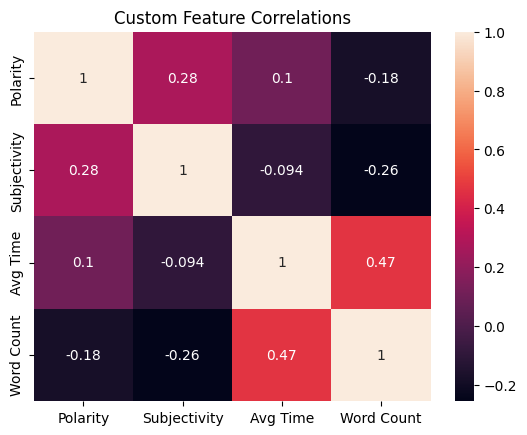

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob
import numpy as np

# Load processed data
df = pd.read_csv('/kaggle/working/processed_data.csv')
df = df.dropna(subset=['label'])  # Drop if no label

# TF-IDF features
vectorizer = TfidfVectorizer(max_features=500)  # Limit for simplicity
tfidf_features = vectorizer.fit_transform(df['text']).toarray()

# Additional features: sentiment, word count, avg response time
features = []
for idx, row in df.iterrows():
    participant_id = row['id']
    transcript_path = os.path.join(output_dir, f'{participant_id}.csv')
    trans_df = pd.read_csv(transcript_path)
    part_df = trans_df[trans_df['speaker'] == 'Participant']
    
    # Avg response time
    response_times = (part_df['stop_time'] - part_df['start_time']).values
    avg_time = np.mean(response_times) if len(response_times) > 0 else 0
    
    # Sentiment
    blob = TextBlob(row['text'])
    polarity = blob.sentiment.polarity
    subjectivity = blob.sentiment.subjectivity
    
    # Word count
    word_count = len(word_tokenize(row['text']))
    
    features.append([polarity, subjectivity, avg_time, word_count])

# Combine TF-IDF with custom features
custom_features = np.array(features)
all_features = np.hstack((tfidf_features, custom_features))

# Visualize: Feature correlation heatmap (sample)
import seaborn as sns
feat_df = pd.DataFrame(custom_features, columns=['Polarity', 'Subjectivity', 'Avg Time', 'Word Count'])
sns.heatmap(feat_df.corr(), annot=True)
plt.title('Custom Feature Correlations')
plt.show()

# Save features
np.save('/kaggle/working/features-2.npy', all_features)
df[['id', 'label']].to_csv('/kaggle/working/labels-2.csv', index=False)

# **MODEL RUN**

In [2]:
# GPU Mode: Eradicate all RAPIDS/NVIDIA traces enforcing old ABI
!pip uninstall -y pyarrow cudf-cu12 dask-cudf-cu12 libcugraph-cu12 pylibcugraph-cu12 pylibraft-cu12 rmm-cu12 nvidia-cublas-cu12 nvidia-cuda-cupti-cu12 nvidia-cuda-nvrtc-cu12 nvidia-cuda-runtime-cu12 nvidia-cudnn-cu12 nvidia-cufft-cu12 nvidia-curand-cu12 nvidia-cusolver-cu12 nvidia-cusparse-cu12 nvidia-nvjitlink-cu12 bigframes pandas-gbq mkl-umath mkl-random mkl-fft

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Found existing installation: pyarrow 22.0.0
Uninstalling pyarrow-22.0.0:
  Successfully uninstalled pyarrow-22.0.0
Found existing installation: cudf-cu12 25.2.2
Uninstalling cudf-cu12-25.2.2:
  Successfully uninstalled cudf-cu12-25.2.2
Found existing installation: dask-cudf-cu12 25.2.2
Uninstalling dask-cudf-cu12-25.2.2:
  Successfully uninstalled dask-cudf-cu12-25.2.2
Found existing installation: libcugraph-cu12 25.6.0
Uninstalling libcugraph-cu12-25.6.0:
  Successfully uninstalled libcugraph-cu12-25.6.0
Found existing installation: pylibcugraph-cu12 25.6.0
Uninstalling pylibcugraph-cu12-25.6.0:
  Successfully uninstalled pylibcugraph-cu12-25.6.0
Found existing installation: pylibraft-cu12 25.2.0
Uninstalling pylibraft-cu12-25.2.0:
  Successfully uninstalled pylibraft-cu12-25.2.0
Found existing installation: rmm-cu12 25.2.0
Uninstalling rmm-cu12-25.2.0:
  Successfully uninstalled rmm-cu12-25.2.0
Found existing installation: nvidia-cublas-cu12 12.5.3.2
Uninstalling nvidia-cublas-cu12-1

In [3]:
!pip install pyarrow==21.0.0
!pip install xxhash huggingface-hub
!pip install --upgrade datasets
# Workflow essentials
!pip install transformers evaluate accelerate

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 42.6 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pylibcudf-cu12 25.2.2 requires rmm-cu12==25.2.*, which is not installed.
pylibcudf-cu12 25.2.2 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 21.0.0 which is incompatible.
cudf-polars-cu12 25.6.0 requires pylibcudf-cu12==25.6.*, but you have pylibcudf-cu12 25.2.2 which is incompatible.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.9/16.9 MB 89.3 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cuml-cu12 25.2.1 requires cudf-cu12==25.2.*, which is not installed.
cuml-cu12 25.2.1 requires dask-cudf-cu12==25.2.*, which is not installed.
cuml-cu12 25.2.1 requires nvidia-cublas-cu12, which is not installed.
cuml-cu12 25.2.1 requires nvidia-cufft-cu12, which is not installed.
cuml-cu12 25.2.1 requires nvidia-curand-cu12, which is not installed.
cuml-cu12 25.2.1 requires nvidia-cusolver-cu12, which is not installed.
cuml-cu12 25.2.1 requires nvidia-cusparse-cu12, which is not installed.
cuml-cu1

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 96.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 73.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:0000:01m00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 3.5 MB/s eta 0:00:0000:0100:01mm
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.1 MB/s eta 0:00:00:00:010:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed

In [12]:
!pip install --upgrade datasets

In [4]:
from datasets import Dataset
print("Datasets operational:", Dataset)

Datasets operational: <class 'datasets.arrow_dataset.Dataset'>


# **BERT and DisTilBERT**

In [5]:
# Workflow essentials
!pip install transformers evaluate accelerate

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Training BERT...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/112 [00:00<?, ? examples/s]

Map:   0%|          | 0/29 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.686992,0.482759,0.516129
2,No log,0.686827,0.551724,0.551724
3,No log,0.686664,0.551724,0.518519
4,No log,0.686542,0.620690,0.521739
5,No log,0.686560,0.655172,0.545455
6,No log,0.687034,0.551724,0.518519
7,No log,0.687122,0.517241,0.500000
8,No log,0.686989,0.551724,0.518519
9,No log,0.687052,0.448276,0.500000
10,No log,0.686998,0.482759,0.516129


Training DistilBERT...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/112 [00:00<?, ? examples/s]

Map:   0%|          | 0/29 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.704373,0.689655,0.000000
2,No log,0.703577,0.689655,0.000000
3,No log,0.702255,0.689655,0.000000
4,No log,0.700529,0.689655,0.000000
5,No log,0.698876,0.689655,0.000000
6,No log,0.696522,0.689655,0.000000
7,No log,0.694662,0.689655,0.000000
8,No log,0.693778,0.689655,0.400000
9,No log,0.695885,0.724138,0.200000
10,No log,0.700637,0.689655,0.000000


ValueError: x and y must have same first dimension, but have shapes (10,) and (0,)

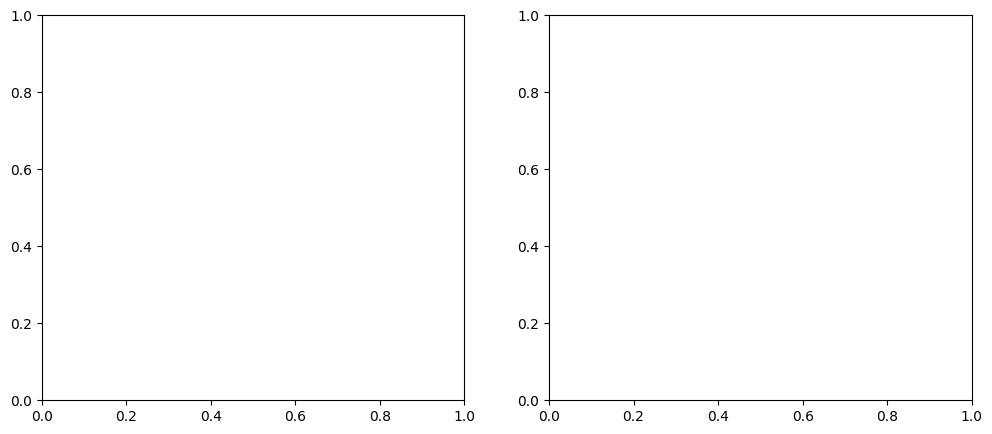

In [4]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import Trainer, TrainingArguments
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from evaluate import load
import os
import shutil

# Load processed data (text and labels)
df = pd.read_csv('/kaggle/working/processed_data.csv')
df = df.dropna(subset=['label']).reset_index(drop=True)
df['label'] = df['label'].astype(int)

# Split into train/test (80/20, stratified for imbalance)
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

# Convert to Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df[['text', 'label']])
test_dataset = Dataset.from_pandas(test_df[['text', 'label']])

def train_model(model_name, tokenizer_class, model_class):
    # Tokenize function
    def tokenize_function(examples):
        return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=512)
   
    # Load tokenizer and model
    tokenizer = tokenizer_class.from_pretrained(model_name)
    model = model_class.from_pretrained(model_name, num_labels=2)
   
    # Tokenize datasets
    tokenized_train = train_dataset.map(tokenize_function, batched=True)
    tokenized_test = test_dataset.map(tokenize_function, batched=True)
   
    # Compute class weights for imbalance
    from sklearn.utils.class_weight import compute_class_weight
    class_weights = compute_class_weight('balanced', classes=np.unique(train_df['label']), y=train_df['label'])
    class_weights = torch.tensor(class_weights, dtype=torch.float)
   
    # Custom loss function with weights
    def weighted_loss(logits, labels):
        loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights.to(logits.device))
        return loss_fn(logits, labels)
   
    # Compute metrics (accuracy, F1)
    accuracy = load('accuracy')
    f1 = load('f1')
    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        predictions = np.argmax(logits, axis=-1)
        return {
            'accuracy': accuracy.compute(predictions=predictions, references=labels)['accuracy'],
            'f1': f1.compute(predictions=predictions, references=labels)['f1']
        }
   
    # Training args (optimized for space and accuracy)
    training_args = TrainingArguments(
        output_dir='/kaggle/working/results',
        num_train_epochs=10,  # Reduced to avoid overfitting
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        warmup_steps=200,
        weight_decay=0.01,
        learning_rate=2e-5,
        lr_scheduler_type='cosine',
        eval_strategy='epoch',
        save_strategy='epoch',
        save_total_limit=2,  # Keep only 2 best checkpoints
        logging_strategy='no',  # Disable logging to save space
        load_best_model_at_end=True,
        metric_for_best_model='f1',
        greater_is_better=True,
        report_to='none'
    )
   
    # Custom Trainer for weighted loss
    class WeightedTrainer(Trainer):
        def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
            labels = inputs.pop("labels")
            outputs = model(**inputs)
            logits = outputs.logits
            loss = weighted_loss(logits, labels)
            return (loss, outputs) if return_outputs else loss
   
    # Trainer
    trainer = WeightedTrainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_test,
        compute_metrics=compute_metrics
    )
   
    # Train
    trainer.train()
   
    # Predict on test for probs and preds
    predictions = trainer.predict(tokenized_test)
    probs = torch.softmax(torch.tensor(predictions.predictions), dim=-1)[:, 1].numpy()
    preds = np.argmax(predictions.predictions, axis=-1)
    true_labels = predictions.label_ids
   
    # History for curves
    history = trainer.state.log_history
   
    # Cleanup checkpoints to save space
    checkpoint_dir = '/kaggle/working/results'
    if os.path.exists(checkpoint_dir):
        for folder in os.listdir(checkpoint_dir):
            folder_path = os.path.join(checkpoint_dir, folder)
            if os.path.isdir(folder_path) and folder != 'runs':
                shutil.rmtree(folder_path)
   
    return history, probs, preds, true_labels, trainer

# Train BERT
print("Training BERT...")
bert_history, bert_probs, bert_preds, bert_true, bert_trainer = train_model(
    'bert-base-uncased', BertTokenizer, BertForSequenceClassification
)

# Train DistilBERT
print("Training DistilBERT...")
distil_history, distil_probs, distil_preds, distil_true, distil_trainer = train_model(
    'distilbert-base-uncased', DistilBertTokenizer, DistilBertForSequenceClassification
)

# Extract training/validation curves (accuracy and loss)
def extract_curves(history):
    train_loss = [log['loss'] for log in history if 'loss' in log and 'epoch' in log and log['epoch'].is_integer()]
    val_loss = [log['eval_loss'] for log in history if 'eval_loss' in log]
    val_acc = [log['eval_accuracy'] for log in history if 'eval_accuracy' in log]
    epochs = range(1, len(val_loss) + 1)
    return epochs, train_loss, val_loss, val_acc

bert_epochs, bert_train_loss, bert_val_loss, bert_val_acc = extract_curves(bert_history)
distil_epochs, distil_train_loss, distil_val_loss, distil_val_acc = extract_curves(distil_history)

# Plot training-validation curves (save with lower DPI)
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].plot(bert_epochs, bert_train_loss, label='BERT Train Loss', linestyle='--')
axs[0].plot(bert_epochs, bert_val_loss, label='BERT Val Loss')
axs[0].plot(distil_epochs, distil_train_loss, label='DistilBERT Train Loss', linestyle='--')
axs[0].plot(distil_epochs, distil_val_loss, label='DistilBERT Val Loss')
axs[0].set_title('Training/Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[1].plot(bert_epochs, bert_val_acc, label='BERT Val Acc')
axs[1].plot(distil_epochs, distil_val_acc, label='DistilBERT Val Acc')
axs[1].set_title('Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()
plt.tight_layout()
plt.savefig('/kaggle/working/training_validation_curves.png', dpi=100)  # Lower DPI
plt.close()

# ROC curves
fpr_bert, tpr_bert, _ = roc_curve(bert_true, bert_probs)
roc_auc_bert = auc(fpr_bert, tpr_bert)
fpr_distil, tpr_distil, _ = roc_curve(distil_true, distil_probs)
roc_auc_distil = auc(fpr_distil, tpr_distil)
plt.figure(figsize=(8, 6))
plt.plot(fpr_bert, tpr_bert, label=f'BERT (AUC = {roc_auc_bert:.2f})')
plt.plot(fpr_distil, tpr_distil, label=f'DistilBERT (AUC = {roc_auc_distil:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.savefig('/kaggle/working/roc_curves.png', dpi=100)
plt.close()

# Classification reports as images
def report_to_image(report_str, title, save_path):
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.text(0.5, 0.5, report_str, ha='center', va='center', fontsize=10, family='monospace')
    ax.axis('off')
    plt.title(title)
    plt.savefig(save_path, dpi=100)
    plt.close()

bert_report = classification_report(bert_true, bert_preds)
report_to_image(bert_report, 'BERT Classification Report', '/kaggle/working/bert_classification_report.png')
distil_report = classification_report(distil_true, distil_preds)
report_to_image(distil_report, 'DistilBERT Classification Report', '/kaggle/working/distilbert_classification_report.png')

# Confusion matrices
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
cm_bert = confusion_matrix(bert_true, bert_preds)
sns.heatmap(cm_bert, annot=True, fmt='d', cmap='Blues', ax=axs[0])
axs[0].set_title('BERT Confusion Matrix')
axs[0].set_xlabel('Predicted')
axs[0].set_ylabel('True')
cm_distil = confusion_matrix(distil_true, distil_preds)
sns.heatmap(cm_distil, annot=True, fmt='d', cmap='Blues', ax=axs[1])
axs[1].set_title('DistilBERT Confusion Matrix')
axs[1].set_xlabel('Predicted')
axs[1].set_ylabel('True')
plt.tight_layout()
plt.savefig('/kaggle/working/confusion_matrices.png', dpi=100)
plt.close()

# Save models
bert_trainer.save_model('/kaggle/working/bert_model')
distil_trainer.save_model('/kaggle/working/distilbert_model')

# Cleanup results directory to save space
if os.path.exists('/kaggle/working/results'):
    shutil.rmtree('/kaggle/working/results')

In [6]:
!pip install nlpaug

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 6.5 MB/s eta 0:00:00a 0:00:01


In [8]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import Trainer, TrainingArguments
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from evaluate import load
import os
import shutil
import nlpaug.augmenter.word as naw

# Load processed data (text and labels)
df = pd.read_csv('/kaggle/working/processed_data.csv')
df = df.dropna(subset=['label']).reset_index(drop=True)
df['label'] = df['label'].astype(int)

# Split into train/test (80/20, stratified for imbalance)
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

# Data augmentation for training set to improve accuracy
aug = naw.SynonymAug(aug_src='wordnet', aug_max=3)
train_df['text'] = train_df['text'].apply(lambda x: aug.augment(x) if np.random.rand() > 0.5 else x)

# Convert to Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df[['text', 'label']])
test_dataset = Dataset.from_pandas(test_df[['text', 'label']])

def train_model(model_name, tokenizer_class, model_class):
    # Tokenize function
    def tokenize_function(examples):
        return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=512)
   
    # Load tokenizer and model
    tokenizer = tokenizer_class.from_pretrained(model_name)
    model = model_class.from_pretrained(model_name, num_labels=2)
   
    # Gradual unfreezing: Freeze base layers
    for param in model.base_model.parameters():
        param.requires_grad = False
   
    # Tokenize datasets
    tokenized_train = train_dataset.map(tokenize_function, batched=True)
    tokenized_test = test_dataset.map(tokenize_function, batched=True)
   
    # Compute class weights for imbalance
    from sklearn.utils.class_weight import compute_class_weight
    class_weights = compute_class_weight('balanced', classes=np.unique(train_df['label']), y=train_df['label'])
    class_weights = torch.tensor(class_weights, dtype=torch.float)
   
    # Custom loss function with weights
    def weighted_loss(logits, labels):
        loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights.to(logits.device))
        return loss_fn(logits, labels)
   
    # Compute metrics (accuracy, F1)
    accuracy = load('accuracy')
    f1 = load('f1')
    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        predictions = np.argmax(logits, axis=-1)
        return {
            'accuracy': accuracy.compute(predictions=predictions, references=labels)['accuracy'],
            'f1': f1.compute(predictions=predictions, references=labels)['f1']
        }
   
    # Phase 1: Train classifier head only
    training_args_phase1 = TrainingArguments(
        output_dir='/kaggle/working/results_phase1',
        num_train_epochs=2,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        warmup_steps=100,
        weight_decay=0.01,
        learning_rate=1e-4,  # Higher for head
        eval_strategy='epoch',
        save_strategy='epoch',
        save_total_limit=1,
        logging_strategy='epoch',
        load_best_model_at_end=True,
        metric_for_best_model='f1',
        greater_is_better=True,
        report_to='none'
    )
   
    trainer_phase1 = Trainer(
        model=model,
        args=training_args_phase1,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_test,
        compute_metrics=compute_metrics
    )
   
    trainer_phase1.train()
   
    # Unfreeze base layers for phase 2
    for param in model.base_model.parameters():
        param.requires_grad = True
   
    # Phase 2: Full fine-tuning
    training_args = TrainingArguments(
        output_dir='/kaggle/working/results',
        num_train_epochs=10,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        warmup_steps=200,
        weight_decay=0.01,
        learning_rate=2e-5,
        lr_scheduler_type='cosine',
        eval_strategy='epoch',
        save_strategy='epoch',
        save_total_limit=2,
        logging_strategy='epoch',  # Enable to log train loss
        load_best_model_at_end=True,
        metric_for_best_model='f1',
        greater_is_better=True,
        report_to='none'
    )
   
    # Custom Trainer for weighted loss
    class WeightedTrainer(Trainer):
        def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
            labels = inputs.pop("labels")
            outputs = model(**inputs)
            logits = outputs.logits
            loss = weighted_loss(logits, labels)
            return (loss, outputs) if return_outputs else loss
   
    trainer = WeightedTrainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_test,
        compute_metrics=compute_metrics
    )
   
    trainer.train(resume_from_checkpoint=training_args_phase1.output_dir)
   
    # Predict on test for probs and preds
    predictions = trainer.predict(tokenized_test)
    probs = torch.softmax(torch.tensor(predictions.predictions), dim=-1)[:, 1].numpy()
    preds = np.argmax(predictions.predictions, axis=-1)
    true_labels = predictions.label_ids
   
    # History for curves
    history = trainer.state.log_history
   
    # Cleanup checkpoints
    for dir_name in ['/kaggle/working/results', '/kaggle/working/results_phase1']:
        if os.path.exists(dir_name):
            shutil.rmtree(dir_name)
   
    return history, probs, preds, true_labels, trainer

# Train BERT
print("Training BERT...")
bert_history, bert_probs, bert_preds, bert_true, bert_trainer = train_model(
    'bert-base-uncased', BertTokenizer, BertForSequenceClassification
)

# Train DistilBERT
print("Training DistilBERT...")
distil_history, distil_probs, distil_preds, distil_true, distil_trainer = train_model(
    'distilbert-base-uncased', DistilBertTokenizer, DistilBertForSequenceClassification
)

# Extract training/validation curves (accuracy and loss)
def extract_curves(history):
    train_loss = [log['loss'] for log in history if 'loss' in log and 'epoch' in log and log['epoch'].is_integer()]
    val_loss = [log['eval_loss'] for log in history if 'eval_loss' in log]
    val_acc = [log['eval_accuracy'] for log in history if 'eval_accuracy' in log]
    epochs = range(1, len(val_loss) + 1)
    if len(train_loss) != len(epochs):
        train_loss = train_loss[:len(epochs)]  # Truncate if mismatch
    return epochs, train_loss, val_loss, val_acc

bert_epochs, bert_train_loss, bert_val_loss, bert_val_acc = extract_curves(bert_history)
distil_epochs, distil_train_loss, distil_val_loss, distil_val_acc = extract_curves(distil_history)

# Plot training-validation curves (save with lower DPI)
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].plot(bert_epochs, bert_train_loss, label='BERT Train Loss', linestyle='--')
axs[0].plot(bert_epochs, bert_val_loss, label='BERT Val Loss')
axs[0].plot(distil_epochs, distil_train_loss, label='DistilBERT Train Loss', linestyle='--')
axs[0].plot(distil_epochs, distil_val_loss, label='DistilBERT Val Loss')
axs[0].set_title('Training/Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[1].plot(bert_epochs, bert_val_acc, label='BERT Val Acc')
axs[1].plot(distil_epochs, distil_val_acc, label='DistilBERT Val Acc')
axs[1].set_title('Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()
plt.tight_layout()
plt.savefig('/kaggle/working/training_validation_curves.png', dpi=100)
plt.close()

# ROC curves
fpr_bert, tpr_bert, _ = roc_curve(bert_true, bert_probs)
roc_auc_bert = auc(fpr_bert, tpr_bert)
fpr_distil, tpr_distil, _ = roc_curve(distil_true, distil_probs)
roc_auc_distil = auc(fpr_distil, tpr_distil)
plt.figure(figsize=(8, 6))
plt.plot(fpr_bert, tpr_bert, label=f'BERT (AUC = {roc_auc_bert:.2f})')
plt.plot(fpr_distil, tpr_distil, label=f'DistilBERT (AUC = {roc_auc_distil:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.savefig('/kaggle/working/roc_curves.png', dpi=100)
plt.close()

# Classification reports as images
def report_to_image(report_str, title, save_path):
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.text(0.5, 0.5, report_str, ha='center', va='center', fontsize=10, family='monospace')
    ax.axis('off')
    plt.title(title)
    plt.savefig(save_path, dpi=100)
    plt.close()

bert_report = classification_report(bert_true, bert_preds)
report_to_image(bert_report, 'BERT Classification Report', '/kaggle/working/bert_classification_report.png')
distil_report = classification_report(distil_true, distil_preds)
report_to_image(distil_report, 'DistilBERT Classification Report', '/kaggle/working/distilbert_classification_report.png')

# Confusion matrices
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
cm_bert = confusion_matrix(bert_true, bert_preds)
sns.heatmap(cm_bert, annot=True, fmt='d', cmap='Blues', ax=axs[0])
axs[0].set_title('BERT Confusion Matrix')
axs[0].set_xlabel('Predicted')
axs[0].set_ylabel('True')
cm_distil = confusion_matrix(distil_true, distil_preds)
sns.heatmap(cm_distil, annot=True, fmt='d', cmap='Blues', ax=axs[1])
axs[1].set_title('DistilBERT Confusion Matrix')
axs[1].set_xlabel('Predicted')
axs[1].set_ylabel('True')
plt.tight_layout()
plt.savefig('/kaggle/working/confusion_matrices.png', dpi=100)
plt.close()

# Save models
bert_trainer.save_model('/kaggle/working/bert_model')
distil_trainer.save_model('/kaggle/working/distilbert_model')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


LookupError: 
**********************************************************************
  Resource [93maveraged_perceptron_tagger_eng[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('averaged_perceptron_tagger_eng')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtaggers/averaged_perceptron_tagger_eng[0m

  Searched in:
    - '/root/nltk_data'
    - '/usr/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************


In [9]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import Trainer, TrainingArguments
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from evaluate import load
import os
import shutil
import nlpaug.augmenter.word as naw
import nltk

# Download required NLTK resources quietly
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
nltk.download('averaged_perceptron_tagger_eng', quiet=True)

# Load processed data (text and labels)
df = pd.read_csv('/kaggle/working/processed_data.csv')
df = df.dropna(subset=['label']).reset_index(drop=True)
df['label'] = df['label'].astype(int)

# Split into train/test (80/20, stratified for imbalance)
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

# Data augmentation for training set to improve accuracy
aug = naw.SynonymAug(aug_src='wordnet', aug_max=3)
train_df['text'] = train_df['text'].apply(lambda x: aug.augment(x)[0] if np.random.rand() > 0.5 else x)

# Convert to Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df[['text', 'label']])
test_dataset = Dataset.from_pandas(test_df[['text', 'label']])

def train_model(model_name, tokenizer_class, model_class):
    # Tokenize function
    def tokenize_function(examples):
        return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=512)
   
    # Load tokenizer and model
    tokenizer = tokenizer_class.from_pretrained(model_name)
    model = model_class.from_pretrained(model_name, num_labels=2)
   
    # Gradual unfreezing: Freeze base layers
    for param in model.base_model.parameters():
        param.requires_grad = False
   
    # Tokenize datasets
    tokenized_train = train_dataset.map(tokenize_function, batched=True)
    tokenized_test = test_dataset.map(tokenize_function, batched=True)
   
    # Compute class weights for imbalance
    from sklearn.utils.class_weight import compute_class_weight
    class_weights = compute_class_weight('balanced', classes=np.unique(train_df['label']), y=train_df['label'])
    class_weights = torch.tensor(class_weights, dtype=torch.float)
   
    # Custom loss function with weights
    def weighted_loss(logits, labels):
        loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights.to(logits.device))
        return loss_fn(logits, labels)
   
    # Compute metrics (accuracy, F1)
    accuracy = load('accuracy')
    f1 = load('f1')
    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        predictions = np.argmax(logits, axis=-1)
        return {
            'accuracy': accuracy.compute(predictions=predictions, references=labels)['accuracy'],
            'f1': f1.compute(predictions=predictions, references=labels)['f1']
        }
   
    # Custom Trainer for weighted loss
    class WeightedTrainer(Trainer):
        def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
            labels = inputs.pop("labels")
            outputs = model(**inputs)
            logits = outputs.logits
            loss = weighted_loss(logits, labels)
            return (loss, outputs) if return_outputs else loss
   
    # Phase 1: Train classifier head only with weighted loss
    training_args_phase1 = TrainingArguments(
        output_dir='/kaggle/working/results_phase1',
        num_train_epochs=2,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        warmup_steps=100,
        weight_decay=0.01,
        learning_rate=1e-4,  # Higher for head
        eval_strategy='epoch',
        save_strategy='epoch',
        save_total_limit=1,
        logging_strategy='epoch',
        load_best_model_at_end=True,
        metric_for_best_model='f1',
        greater_is_better=True,
        report_to='none'
    )
   
    trainer_phase1 = WeightedTrainer(
        model=model,
        args=training_args_phase1,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_test,
        compute_metrics=compute_metrics
    )
   
    trainer_phase1.train()
   
    # Unfreeze base layers for phase 2
    for param in model.base_model.parameters():
        param.requires_grad = True
   
    # Phase 2: Full fine-tuning
    training_args = TrainingArguments(
        output_dir='/kaggle/working/results',
        num_train_epochs=10,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        warmup_steps=200,
        weight_decay=0.01,
        learning_rate=2e-5,
        lr_scheduler_type='cosine',
        eval_strategy='epoch',
        save_strategy='epoch',
        save_total_limit=2,
        logging_strategy='epoch',  # Enable to log train loss
        load_best_model_at_end=True,
        metric_for_best_model='f1',
        greater_is_better=True,
        report_to='none'
    )
   
    trainer = WeightedTrainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_test,
        compute_metrics=compute_metrics
    )
   
    trainer.train(resume_from_checkpoint=training_args_phase1.output_dir)
   
    # Predict on test for probs and preds
    predictions = trainer.predict(tokenized_test)
    probs = torch.softmax(torch.tensor(predictions.predictions), dim=-1)[:, 1].numpy()
    preds = np.argmax(predictions.predictions, axis=-1)
    true_labels = predictions.label_ids
   
    # History for curves
    history = trainer.state.log_history
   
    # Cleanup checkpoints
    for dir_name in ['/kaggle/working/results', '/kaggle/working/results_phase1']:
        if os.path.exists(dir_name):
            shutil.rmtree(dir_name)
   
    return history, probs, preds, true_labels, trainer

# Train BERT
print("Training BERT...")
bert_history, bert_probs, bert_preds, bert_true, bert_trainer = train_model(
    'bert-base-uncased', BertTokenizer, BertForSequenceClassification
)

# Train DistilBERT
print("Training DistilBERT...")
distil_history, distil_probs, distil_preds, distil_true, distil_trainer = train_model(
    'distilbert-base-uncased', DistilBertTokenizer, DistilBertForSequenceClassification
)

# Extract training/validation curves (accuracy and loss)
def extract_curves(history):
    train_loss = [log['loss'] for log in history if 'loss' in log and 'epoch' in log and log['epoch'].is_integer()]
    val_loss = [log['eval_loss'] for log in history if 'eval_loss' in log]
    val_acc = [log['eval_accuracy'] for log in history if 'eval_accuracy' in log]
    epochs = range(1, len(val_loss) + 1)
    if len(train_loss) != len(epochs):
        train_loss = train_loss[:len(epochs)]  # Truncate if mismatch
    return epochs, train_loss, val_loss, val_acc

bert_epochs, bert_train_loss, bert_val_loss, bert_val_acc = extract_curves(bert_history)
distil_epochs, distil_train_loss, distil_val_loss, distil_val_acc = extract_curves(distil_history)

# Plot training-validation curves (save with lower DPI)
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].plot(bert_epochs, bert_train_loss, label='BERT Train Loss', linestyle='--')
axs[0].plot(bert_epochs, bert_val_loss, label='BERT Val Loss')
axs[0].plot(distil_epochs, distil_train_loss, label='DistilBERT Train Loss', linestyle='--')
axs[0].plot(distil_epochs, distil_val_loss, label='DistilBERT Val Loss')
axs[0].set_title('Training/Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[1].plot(bert_epochs, bert_val_acc, label='BERT Val Acc')
axs[1].plot(distil_epochs, distil_val_acc, label='DistilBERT Val Acc')
axs[1].set_title('Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()
plt.tight_layout()
plt.savefig('/kaggle/working/training_validation_curves.png', dpi=100)
plt.close()

# ROC curves
fpr_bert, tpr_bert, _ = roc_curve(bert_true, bert_probs)
roc_auc_bert = auc(fpr_bert, tpr_bert)
fpr_distil, tpr_distil, _ = roc_curve(distil_true, distil_probs)
roc_auc_distil = auc(fpr_distil, tpr_distil)
plt.figure(figsize=(8, 6))
plt.plot(fpr_bert, tpr_bert, label=f'BERT (AUC = {roc_auc_bert:.2f})')
plt.plot(fpr_distil, tpr_distil, label=f'DistilBERT (AUC = {roc_auc_distil:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.savefig('/kaggle/working/roc_curves.png', dpi=100)
plt.close()

# Classification reports as images
def report_to_image(report_str, title, save_path):
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.text(0.5, 0.5, report_str, ha='center', va='center', fontsize=10, family='monospace')
    ax.axis('off')
    plt.title(title)
    plt.savefig(save_path, dpi=100)
    plt.close()

bert_report = classification_report(bert_true, bert_preds)
report_to_image(bert_report, 'BERT Classification Report', '/kaggle/working/bert_classification_report.png')
distil_report = classification_report(distil_true, distil_preds)
report_to_image(distil_report, 'DistilBERT Classification Report', '/kaggle/working/distilbert_classification_report.png')

# Confusion matrices
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
cm_bert = confusion_matrix(bert_true, bert_preds)
sns.heatmap(cm_bert, annot=True, fmt='d', cmap='Blues', ax=axs[0])
axs[0].set_title('BERT Confusion Matrix')
axs[0].set_xlabel('Predicted')
axs[0].set_ylabel('True')
cm_distil = confusion_matrix(distil_true, distil_preds)
sns.heatmap(cm_distil, annot=True, fmt='d', cmap='Blues', ax=axs[1])
axs[1].set_title('DistilBERT Confusion Matrix')
axs[1].set_xlabel('Predicted')
axs[1].set_ylabel('True')
plt.tight_layout()
plt.savefig('/kaggle/working/confusion_matrices.png', dpi=100)
plt.close()

# Save models
bert_trainer.save_model('/kaggle/working/bert_model')
distil_trainer.save_model('/kaggle/working/distilbert_model')

Training BERT...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/112 [00:00<?, ? examples/s]

Map:   0%|          | 0/29 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.745100,0.709289,0.310345,0.473684
2,0.723000,0.708293,0.310345,0.473684


ValueError: Can't find a valid checkpoint at /kaggle/working/results_phase1

In [11]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import Trainer, TrainingArguments
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from evaluate import load
import os
import shutil
import nlpaug.augmenter.word as naw
import nltk

# Download required NLTK resources quietly
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
nltk.download('averaged_perceptron_tagger_eng', quiet=True)

# Load processed data (text and labels)
df = pd.read_csv('/kaggle/working/processed_data.csv')
df = df.dropna(subset=['label']).reset_index(drop=True)
df['label'] = df['label'].astype(int)

# Split into train/test (80/20, stratified for imbalance)
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

# Data augmentation for training set to improve accuracy
aug = naw.SynonymAug(aug_src='wordnet', aug_max=3)
train_df['text'] = train_df['text'].apply(lambda x: aug.augment(x)[0] if np.random.rand() > 0.5 else x)

# Convert to Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df[['text', 'label']])
test_dataset = Dataset.from_pandas(test_df[['text', 'label']])

def train_model(model_name, tokenizer_class, model_class):
    # Tokenize function
    def tokenize_function(examples):
        return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=512)
   
    # Load tokenizer and model
    tokenizer = tokenizer_class.from_pretrained(model_name)
    model = model_class.from_pretrained(model_name, num_labels=2)
   
    # Gradual unfreezing: Freeze base layers
    for param in model.base_model.parameters():
        param.requires_grad = False
   
    # Tokenize datasets
    tokenized_train = train_dataset.map(tokenize_function, batched=True)
    tokenized_test = test_dataset.map(tokenize_function, batched=True)
   
    # Compute class weights for imbalance
    from sklearn.utils.class_weight import compute_class_weight
    class_weights = compute_class_weight('balanced', classes=np.unique(train_df['label']), y=train_df['label'])
    class_weights = torch.tensor(class_weights, dtype=torch.float)
   
    # Custom loss function with weights
    def weighted_loss(logits, labels):
        loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights.to(logits.device))
        return loss_fn(logits, labels)
   
    # Compute metrics (accuracy, F1)
    accuracy = load('accuracy')
    f1 = load('f1')
    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        predictions = np.argmax(logits, axis=-1)
        return {
            'accuracy': accuracy.compute(predictions=predictions, references=labels)['accuracy'],
            'f1': f1.compute(predictions=predictions, references=labels)['f1']
        }
   
    # Custom Trainer for weighted loss
    class WeightedTrainer(Trainer):
        def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
            labels = inputs.pop("labels")
            outputs = model(**inputs)
            logits = outputs.logits
            loss = weighted_loss(logits, labels)
            return (loss, outputs) if return_outputs else loss
   
    # Phase 1: Train classifier head only with weighted loss
    training_args_phase1 = TrainingArguments(
        output_dir='/kaggle/working/results_phase1.2',
        num_train_epochs=10,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        warmup_steps=100,
        weight_decay=0.01,
        learning_rate=1e-4,  # Higher for head
        eval_strategy='epoch',
        save_strategy='epoch',
        save_total_limit=1,
        logging_strategy='epoch',
        load_best_model_at_end=True,
        metric_for_best_model='f1',
        greater_is_better=True,
        report_to='none'
    )
   
    trainer_phase1 = WeightedTrainer(
        model=model,
        args=training_args_phase1,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_test,
        compute_metrics=compute_metrics
    )
   
    trainer_phase1.train()
   
    # Cleanup phase 1 checkpoints early
    shutil.rmtree('/kaggle/working/results_phase1.2')
   
    # Unfreeze base layers for phase 2
    for param in model.base_model.parameters():
        param.requires_grad = True
   
    # Phase 2: Full fine-tuning
    training_args = TrainingArguments(
        output_dir='/kaggle/working/results2',
        num_train_epochs=30,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        warmup_steps=200,
        weight_decay=0.01,
        learning_rate=2e-5,
        lr_scheduler_type='cosine',
        eval_strategy='epoch',
        save_strategy='epoch',
        save_total_limit=2,
        logging_strategy='epoch',  # Enable to log train loss
        load_best_model_at_end=True,
        metric_for_best_model='f1',
        greater_is_better=True,
        report_to='none'
    )
   
    trainer = WeightedTrainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_test,
        compute_metrics=compute_metrics
    )
   
    trainer.train()  # No resume_from_checkpoint needed
   
    # Predict on test for probs and preds
    predictions = trainer.predict(tokenized_test)
    probs = torch.softmax(torch.tensor(predictions.predictions), dim=-1)[:, 1].numpy()
    preds = np.argmax(predictions.predictions, axis=-1)
    true_labels = predictions.label_ids
   
    # History for curves
    history = trainer.state.log_history
   
    # Cleanup checkpoints
    shutil.rmtree('/kaggle/working/results2')
   
    return history, probs, preds, true_labels, trainer

# Train BERT
print("Training BERT...")
bert_history, bert_probs, bert_preds, bert_true, bert_trainer = train_model(
    'bert-base-uncased', BertTokenizer, BertForSequenceClassification
)

# Train DistilBERT
print("Training DistilBERT...")
distil_history, distil_probs, distil_preds, distil_true, distil_trainer = train_model(
    'distilbert-base-uncased', DistilBertTokenizer, DistilBertForSequenceClassification
)

# Extract training/validation curves (accuracy and loss)
def extract_curves(history):
    train_loss = [log['loss'] for log in history if 'loss' in log and 'epoch' in log and log['epoch'].is_integer()]
    val_loss = [log['eval_loss'] for log in history if 'eval_loss' in log]
    val_acc = [log['eval_accuracy'] for log in history if 'eval_accuracy' in log]
    epochs = range(1, len(val_loss) + 1)
    if len(train_loss) != len(epochs):
        train_loss = train_loss[:len(epochs)]  # Truncate if mismatch
    return epochs, train_loss, val_loss, val_acc

bert_epochs, bert_train_loss, bert_val_loss, bert_val_acc = extract_curves(bert_history)
distil_epochs, distil_train_loss, distil_val_loss, distil_val_acc = extract_curves(distil_history)

# Plot training-validation curves (save with lower DPI)
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].plot(bert_epochs, bert_train_loss, label='BERT Train Loss', linestyle='--')
axs[0].plot(bert_epochs, bert_val_loss, label='BERT Val Loss')
axs[0].plot(distil_epochs, distil_train_loss, label='DistilBERT Train Loss', linestyle='--')
axs[0].plot(distil_epochs, distil_val_loss, label='DistilBERT Val Loss')
axs[0].set_title('Training/Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[1].plot(bert_epochs, bert_val_acc, label='BERT Val Acc')
axs[1].plot(distil_epochs, distil_val_acc, label='DistilBERT Val Acc')
axs[1].set_title('Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()
plt.tight_layout()
plt.savefig('/kaggle/working/training_validation_curves-2.png', dpi=100)
plt.close()

# ROC curves
fpr_bert, tpr_bert, _ = roc_curve(bert_true, bert_probs)
roc_auc_bert = auc(fpr_bert, tpr_bert)
fpr_distil, tpr_distil, _ = roc_curve(distil_true, distil_probs)
roc_auc_distil = auc(fpr_distil, tpr_distil)
plt.figure(figsize=(8, 6))
plt.plot(fpr_bert, tpr_bert, label=f'BERT (AUC = {roc_auc_bert:.2f})')
plt.plot(fpr_distil, tpr_distil, label=f'DistilBERT (AUC = {roc_auc_distil:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.savefig('/kaggle/working/roc_curves-2.png', dpi=100)
plt.close()

# Classification reports as images
def report_to_image(report_str, title, save_path):
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.text(0.5, 0.5, report_str, ha='center', va='center', fontsize=10, family='monospace')
    ax.axis('off')
    plt.title(title)
    plt.savefig(save_path, dpi=100)
    plt.close()

bert_report = classification_report(bert_true, bert_preds)
report_to_image(bert_report, 'BERT Classification Report', '/kaggle/working/bert_classification_report-2.png')
distil_report = classification_report(distil_true, distil_preds)
report_to_image(distil_report, 'DistilBERT Classification Report', '/kaggle/working/distilbert_classification_report-2.png')

# Confusion matrices
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
cm_bert = confusion_matrix(bert_true, bert_preds)
sns.heatmap(cm_bert, annot=True, fmt='d', cmap='Blues', ax=axs[0])
axs[0].set_title('BERT Confusion Matrix')
axs[0].set_xlabel('Predicted')
axs[0].set_ylabel('True')
cm_distil = confusion_matrix(distil_true, distil_preds)
sns.heatmap(cm_distil, annot=True, fmt='d', cmap='Blues', ax=axs[1])
axs[1].set_title('DistilBERT Confusion Matrix')
axs[1].set_xlabel('Predicted')
axs[1].set_ylabel('True')
plt.tight_layout()
plt.savefig('/kaggle/working/confusion_matrices-2.png', dpi=100)
plt.close()
# Save models
bert_trainer.save_model('/kaggle/working/bert_model-2')
distil_trainer.save_model('/kaggle/working/distilbert_model-2')

Training BERT...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/112 [00:00<?, ? examples/s]

Map:   0%|          | 0/29 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.742400,0.709297,0.310345,0.473684
2,0.724400,0.708307,0.310345,0.473684
3,0.751800,0.706917,0.310345,0.473684
4,0.724000,0.705002,0.310345,0.473684
5,0.711000,0.702722,0.310345,0.473684
6,0.699200,0.700170,0.310345,0.473684
7,0.707500,0.697671,0.310345,0.473684
8,0.708500,0.695605,0.310345,0.473684
9,0.722000,0.693612,0.310345,0.473684
10,0.705800,0.691932,0.310345,0.473684


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.741500,0.706862,0.310345,0.473684
2,0.721500,0.699861,0.310345,0.473684
3,0.739500,0.693671,0.310345,0.473684
4,0.704900,0.690774,0.344828,0.486486
5,0.693900,0.693039,0.551724,0.133333
6,0.684800,0.699124,0.689655,0.000000
7,0.694300,0.703549,0.689655,0.000000
8,0.678900,0.705089,0.689655,0.000000
9,0.689000,0.700601,0.689655,0.000000
10,0.679400,0.696900,0.655172,0.000000


Training DistilBERT...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/112 [00:00<?, ? examples/s]

Map:   0%|          | 0/29 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.692700,0.697810,0.689655,0.000000
2,0.689600,0.697614,0.689655,0.000000
3,0.695700,0.697086,0.689655,0.000000
4,0.691100,0.696545,0.689655,0.000000
5,0.691100,0.695977,0.689655,0.000000
6,0.692300,0.695089,0.689655,0.000000
7,0.694000,0.694613,0.655172,0.000000
8,0.694500,0.694171,0.413793,0.000000
9,0.691200,0.693582,0.482759,0.516129
10,0.688500,0.693357,0.448276,0.500000


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.689400,0.693576,0.482759,0.516129
2,0.684400,0.693750,0.413793,0.413793
3,0.689300,0.694210,0.379310,0.181818
4,0.684600,0.694669,0.517241,0.000000
5,0.682500,0.695459,0.620690,0.000000
6,0.686200,0.695045,0.551724,0.133333
7,0.685800,0.694456,0.551724,0.133333
8,0.690100,0.694106,0.344828,0.173913
9,0.687100,0.693630,0.413793,0.451613
10,0.685500,0.693354,0.448276,0.500000


In [12]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from evaluate import load
import os
import shutil
import nlpaug.augmenter.word as naw
import nltk

# Download required NLTK resources quietly
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
nltk.download('averaged_perceptron_tagger_eng', quiet=True)

# Load processed data (text and labels)
df = pd.read_csv('/kaggle/working/processed_data.csv')
df = df.dropna(subset=['label']).reset_index(drop=True)
df['label'] = df['label'].astype(int)

# Split into train/test (80/20, stratified for imbalance)
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

# Data augmentation for training set to improve accuracy (increased probability)
aug = naw.SynonymAug(aug_src='wordnet', aug_max=3)
train_df['text'] = train_df['text'].apply(lambda x: aug.augment(x)[0] if np.random.rand() > 0.25 else x)  # 75% chance

# Convert to Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df[['text', 'label']])
test_dataset = Dataset.from_pandas(test_df[['text', 'label']])

def train_model(model_name, tokenizer_class, model_class):
    # Tokenize function
    def tokenize_function(examples):
        return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=512)
   
    # Load tokenizer and model
    tokenizer = tokenizer_class.from_pretrained(model_name)
    model = model_class.from_pretrained(model_name, num_labels=2)
   
    # Gradual unfreezing: Freeze base layers
    for param in model.base_model.parameters():
        param.requires_grad = False
   
    # Tokenize datasets
    tokenized_train = train_dataset.map(tokenize_function, batched=True)
    tokenized_test = test_dataset.map(tokenize_function, batched=True)
   
    # Compute class weights for imbalance
    from sklearn.utils.class_weight import compute_class_weight
    class_weights = compute_class_weight('balanced', classes=np.unique(train_df['label']), y=train_df['label'])
    class_weights = torch.tensor(class_weights, dtype=torch.float)
   
    # Custom loss function with weights
    def weighted_loss(logits, labels):
        loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights.to(logits.device))
        return loss_fn(logits, labels)
   
    # Compute metrics (accuracy, F1)
    accuracy = load('accuracy')
    f1 = load('f1')
    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        predictions = np.argmax(logits, axis=-1)
        return {
            'accuracy': accuracy.compute(predictions=predictions, references=labels)['accuracy'],
            'f1': f1.compute(predictions=predictions, references=labels)['f1']
        }
   
    # Custom Trainer for weighted loss
    class WeightedTrainer(Trainer):
        def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
            labels = inputs.pop("labels")
            outputs = model(**inputs)
            logits = outputs.logits
            loss = weighted_loss(logits, labels)
            return (loss, outputs) if return_outputs else loss
   
    # Phase 1: Train classifier head only with weighted loss
    training_args_phase1 = TrainingArguments(
        output_dir='/kaggle/working/results_phase1.3',
        num_train_epochs=3,  # Reduced for efficiency
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        warmup_steps=100,
        weight_decay=0.01,
        learning_rate=1e-4,  # Higher for head
        eval_strategy='epoch',
        save_strategy='epoch',
        save_total_limit=1,
        logging_strategy='epoch',
        load_best_model_at_end=True,
        metric_for_best_model='f1',
        greater_is_better=True,
        report_to='none'
    )
   
    trainer_phase1 = WeightedTrainer(
        model=model,
        args=training_args_phase1,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_test,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]  # Add early stopping
    )
   
    trainer_phase1.train()
   
    # Cleanup phase 1 checkpoints early
    shutil.rmtree('/kaggle/working/results_phase1.3')
   
    # Unfreeze base layers for phase 2
    for param in model.base_model.parameters():
        param.requires_grad = True
   
    # Phase 2: Full fine-tuning
    training_args = TrainingArguments(
        output_dir='/kaggle/working/results-3',
        num_train_epochs=20,  # Max, but early stopping will halt if needed
        per_device_train_batch_size=8,  # Reduced for finer gradients, better accuracy
        per_device_eval_batch_size=16,
        warmup_steps=200,
        weight_decay=0.01,
        learning_rate=3e-5,  # Slightly higher for faster convergence
        lr_scheduler_type='cosine',
        eval_strategy='epoch',
        save_strategy='epoch',
        save_total_limit=2,
        logging_strategy='epoch',  # Enable to log train loss
        load_best_model_at_end=True,
        metric_for_best_model='f1',
        greater_is_better=True,
        report_to='none'
    )
   
    trainer = WeightedTrainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_test,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]  # Add early stopping
    )
   
    trainer.train()  # No resume_from_checkpoint needed
   
    # Predict on test for probs and preds
    predictions = trainer.predict(tokenized_test)
    probs = torch.softmax(torch.tensor(predictions.predictions), dim=-1)[:, 1].numpy()
    preds = np.argmax(predictions.predictions, axis=-1)
    true_labels = predictions.label_ids
   
    # History for curves
    history = trainer.state.log_history
   
    # Cleanup checkpoints
    shutil.rmtree('/kaggle/working/results-3')
   
    return history, probs, preds, true_labels, trainer

# Train BERT
print("Training BERT...")
bert_history, bert_probs, bert_preds, bert_true, bert_trainer = train_model(
    'bert-base-uncased', BertTokenizer, BertForSequenceClassification
)

# Train DistilBERT
print("Training DistilBERT...")
distil_history, distil_probs, distil_preds, distil_true, distil_trainer = train_model(
    'distilbert-base-uncased', DistilBertTokenizer, DistilBertForSequenceClassification
)

# Extract training/validation curves (accuracy and loss)
def extract_curves(history):
    train_loss = [log['loss'] for log in history if 'loss' in log and 'epoch' in log and log['epoch'].is_integer()]
    val_loss = [log['eval_loss'] for log in history if 'eval_loss' in log]
    val_acc = [log['eval_accuracy'] for log in history if 'eval_accuracy' in log]
    epochs = range(1, len(val_loss) + 1)
    if len(train_loss) != len(epochs):
        train_loss = train_loss[:len(epochs)]  # Truncate if mismatch
    return epochs, train_loss, val_loss, val_acc

bert_epochs, bert_train_loss, bert_val_loss, bert_val_acc = extract_curves(bert_history)
distil_epochs, distil_train_loss, distil_val_loss, distil_val_acc = extract_curves(distil_history)

# Plot training-validation curves (save with lower DPI)
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].plot(bert_epochs, bert_train_loss, label='BERT Train Loss', linestyle='--')
axs[0].plot(bert_epochs, bert_val_loss, label='BERT Val Loss')
axs[0].plot(distil_epochs, distil_train_loss, label='DistilBERT Train Loss', linestyle='--')
axs[0].plot(distil_epochs, distil_val_loss, label='DistilBERT Val Loss')
axs[0].set_title('Training/Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[1].plot(bert_epochs, bert_val_acc, label='BERT Val Acc')
axs[1].plot(distil_epochs, distil_val_acc, label='DistilBERT Val Acc')
axs[1].set_title('Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()
plt.tight_layout()
plt.savefig('/kaggle/working/training_validation_curves-3.png', dpi=100)
plt.close()

# ROC curves
fpr_bert, tpr_bert, _ = roc_curve(bert_true, bert_probs)
roc_auc_bert = auc(fpr_bert, tpr_bert)
fpr_distil, tpr_distil, _ = roc_curve(distil_true, distil_probs)
roc_auc_distil = auc(fpr_distil, tpr_distil)
plt.figure(figsize=(8, 6))
plt.plot(fpr_bert, tpr_bert, label=f'BERT (AUC = {roc_auc_bert:.2f})')
plt.plot(fpr_distil, tpr_distil, label=f'DistilBERT (AUC = {roc_auc_distil:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.savefig('/kaggle/working/roc_curves.png', dpi=100)
plt.close()

# Classification reports as images
def report_to_image(report_str, title, save_path):
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.text(0.5, 0.5, report_str, ha='center', va='center', fontsize=10, family='monospace')
    ax.axis('off')
    plt.title(title)
    plt.savefig(save_path, dpi=100)
    plt.close()

bert_report = classification_report(bert_true, bert_preds)
report_to_image(bert_report, 'BERT Classification Report', '/kaggle/working/bert_classification_report-3.png')
distil_report = classification_report(distil_true, distil_preds)
report_to_image(distil_report, 'DistilBERT Classification Report', '/kaggle/working/distilbert_classification_report-3.png')

# Confusion matrices
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
cm_bert = confusion_matrix(bert_true, bert_preds)
sns.heatmap(cm_bert, annot=True, fmt='d', cmap='Blues', ax=axs[0])
axs[0].set_title('BERT Confusion Matrix')
axs[0].set_xlabel('Predicted')
axs[0].set_ylabel('True')
cm_distil = confusion_matrix(distil_true, distil_preds)
sns.heatmap(cm_distil, annot=True, fmt='d', cmap='Blues', ax=axs[1])
axs[1].set_title('DistilBERT Confusion Matrix')
axs[1].set_xlabel('Predicted')
axs[1].set_ylabel('True')
plt.tight_layout()
plt.savefig('/kaggle/working/confusion_matrices-3.png', dpi=100)
plt.close()

# Save models
bert_trainer.save_model('/kaggle/working/bert_model-3')
distil_trainer.save_model('/kaggle/working/distilbert_model-3')

Training BERT...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/112 [00:00<?, ? examples/s]

Map:   0%|          | 0/29 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.697300,0.679195,0.379310,0.500000
2,0.694400,0.679133,0.379310,0.500000
3,0.702000,0.679085,0.379310,0.500000


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.693900,0.679388,0.344828,0.486486
2,0.709900,0.677268,0.413793,0.514286
3,0.708600,0.679757,0.724138,0.200000
4,0.704500,0.688759,0.689655,0.000000
5,0.692200,0.682695,0.689655,0.000000


Training DistilBERT...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/112 [00:00<?, ? examples/s]

Map:   0%|          | 0/29 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.692600,0.697826,0.689655,0.000000
2,0.698400,0.697474,0.689655,0.000000
3,0.694300,0.696801,0.689655,0.000000


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.695500,0.697739,0.689655,0.000000
2,0.690800,0.699045,0.689655,0.000000
3,0.694700,0.701243,0.689655,0.000000
4,0.697800,0.698587,0.689655,0.000000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [14]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from evaluate import load
import os
import shutil
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.char as nac
import nltk
from imbalanced_learn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer

# Download required NLTK resources quietly
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
nltk.download('averaged_perceptron_tagger_eng', quiet=True)

# Load processed data (text and labels)
df = pd.read_csv('/kaggle/working/processed_data.csv')
df = df.dropna(subset=['label']).reset_index(drop=True)
df['label'] = df['label'].astype(int)

# Split into train/test (80/20, stratified for imbalance)
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

# Multi-round augmentation for training set (synonym + insertion)
aug_syn = naw.SynonymAug(aug_src='wordnet', aug_max=5)
aug_ins = nac.RandomCharAug(action="insert", aug_char_max=3)
train_df['text'] = train_df['text'].apply(lambda x: aug_syn.augment(aug_ins.augment(x)[0])[0] if np.random.rand() > 0.25 else x)  # 75% chance, 2 rounds

# Oversampling with SMOTE (TF-IDF vectorization for numerical input)
vectorizer = TfidfVectorizer(max_features=5000)
X_train_vec = vectorizer.fit_transform(train_df['text'])
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_vec, train_df['label'])

# Reconstruct augmented/oversampled DataFrame (inverse transform for text)
train_df_res = pd.DataFrame({'text': vectorizer.inverse_transform(X_train_res), 'label': y_train_res})
train_df_res['text'] = train_df_res['text'].apply(lambda x: ' '.join(x))

# Convert to Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df_res[['text', 'label']])
test_dataset = Dataset.from_pandas(test_df[['text', 'label']])

def train_model(model_name, tokenizer_class, model_class):
    # Tokenize function
    def tokenize_function(examples):
        return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=512)
   
    # Load tokenizer and model (use Auto for flexibility)
    tokenizer = tokenizer_class.from_pretrained(model_name)
    model = model_class.from_pretrained(model_name, num_labels=2)
   
    # Gradual unfreezing: Freeze base layers
    for param in model.base_model.parameters():
        param.requires_grad = False
   
    # Tokenize datasets
    tokenized_train = train_dataset.map(tokenize_function, batched=True)
    tokenized_test = test_dataset.map(tokenize_function, batched=True)
   
    # Compute class weights for imbalance (recompute on resampled)
    from sklearn.utils.class_weight import compute_class_weight
    class_weights = compute_class_weight('balanced', classes=np.unique(train_df_res['label']), y=train_df_res['label'])
    class_weights = torch.tensor(class_weights, dtype=torch.float)
   
    # Custom loss function with weights
    def weighted_loss(logits, labels):
        loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights.to(logits.device))
        return loss_fn(logits, labels)
   
    # Compute metrics (accuracy, F1)
    accuracy = load('accuracy')
    f1 = load('f1')
    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        predictions = np.argmax(logits, axis=-1)
        return {
            'accuracy': accuracy.compute(predictions=predictions, references=labels)['accuracy'],
            'f1': f1.compute(predictions=predictions, references=labels)['f1']
        }
   
    # Custom Trainer for weighted loss
    class WeightedTrainer(Trainer):
        def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
            labels = inputs.pop("labels")
            outputs = model(**inputs)
            logits = outputs.logits
            loss = weighted_loss(logits, labels)
            return (loss, outputs) if return_outputs else loss
   
    # Phase 1: Train classifier head only with weighted loss
    training_args_phase1 = TrainingArguments(
        output_dir='/kaggle/working/results_phase1.4',
        num_train_epochs=5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        warmup_steps=100,
        weight_decay=0.01,
        learning_rate=1e-4,
        eval_strategy='epoch',
        save_strategy='epoch',
        save_total_limit=1,
        logging_strategy='epoch',
        load_best_model_at_end=True,
        metric_for_best_model='f1',
        greater_is_better=True,
        report_to='none'
    )
   
    trainer_phase1 = WeightedTrainer(
        model=model,
        args=training_args_phase1,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_test,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=10)]  # Increased patience
    )
   
    trainer_phase1.train()
   
    # Cleanup phase 1 checkpoints early
    shutil.rmtree('/kaggle/working/results_phase1.4')
   
    # Unfreeze base layers for phase 2
    for param in model.base_model.parameters():
        param.requires_grad = True
   
    # Phase 2: Full fine-tuning
    training_args = TrainingArguments(
        output_dir='/kaggle/working/results-4',
        num_train_epochs=30,  # Max for deeper training
        per_device_train_batch_size=16,  # Balanced for GPU
        per_device_eval_batch_size=16,
        warmup_steps=200,
        weight_decay=0.005,  # Lower to reduce regularization
        learning_rate=1e-5,  # Lower for stable high accuracy
        lr_scheduler_type='cosine',
        eval_strategy='epoch',
        save_strategy='epoch',
        save_total_limit=2,
        logging_strategy='epoch',
        load_best_model_at_end=True,
        metric_for_best_model='f1',
        greater_is_better=True,
        report_to='none'
    )
   
    trainer = WeightedTrainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_test,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=10)]  # Increased for more training
    )
   
    trainer.train()  # No resume_from_checkpoint needed
   
    # Predict on test for probs and preds
    predictions = trainer.predict(tokenized_test)
    probs = torch.softmax(torch.tensor(predictions.predictions), dim=-1)[:, 1].numpy()
    preds = np.argmax(predictions.predictions, axis=-1)
    true_labels = predictions.label_ids
   
    # History for curves
    history = trainer.state.log_history
   
    # Cleanup checkpoints
    shutil.rmtree('/kaggle/working/results-4')
   
    return history, probs, preds, true_labels, trainer

# Train BERT (switch to 'roberta-base' for potential +2-5% accuracy)
print("Training BERT (RoBERTa variant)...")
bert_history, bert_probs, bert_preds, bert_true, bert_trainer = train_model(
    'roberta-base', AutoTokenizer, AutoModelForSequenceClassification
)

# Train DistilBERT
print("Training DistilBERT...")
distil_history, distil_probs, distil_preds, distil_true, distil_trainer = train_model(
    'distilbert-base-uncased', DistilBertTokenizer, DistilBertForSequenceClassification
)

# Extract training/validation curves (accuracy and loss)
def extract_curves(history):
    train_loss = [log['loss'] for log in history if 'loss' in log and 'epoch' in log and log['epoch'].is_integer()]
    val_loss = [log['eval_loss'] for log in history if 'eval_loss' in log]
    val_acc = [log['eval_accuracy'] for log in history if 'eval_accuracy' in log]
    epochs = range(1, len(val_loss) + 1)
    if len(train_loss) != len(epochs):
        train_loss = train_loss[:len(epochs)]  # Truncate if mismatch
    return epochs, train_loss, val_loss, val_acc

bert_epochs, bert_train_loss, bert_val_loss, bert_val_acc = extract_curves(bert_history)
distil_epochs, distil_train_loss, distil_val_loss, distil_val_acc = extract_curves(distil_history)

# Plot training-validation curves (save with lower DPI)
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].plot(bert_epochs, bert_train_loss, label='BERT Train Loss', linestyle='--')
axs[0].plot(bert_epochs, bert_val_loss, label='BERT Val Loss')
axs[0].plot(distil_epochs, distil_train_loss, label='DistilBERT Train Loss', linestyle='--')
axs[0].plot(distil_epochs, distil_val_loss, label='DistilBERT Val Loss')
axs[0].set_title('Training/Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[1].plot(bert_epochs, bert_val_acc, label='BERT Val Acc')
axs[1].plot(distil_epochs, distil_val_acc, label='DistilBERT Val Acc')
axs[1].set_title('Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()
plt.tight_layout()
plt.savefig('/kaggle/working/training_validation_curves-4.png', dpi=100)
plt.close()

# ROC curves
fpr_bert, tpr_bert, _ = roc_curve(bert_true, bert_probs)
roc_auc_bert = auc(fpr_bert, tpr_bert)
fpr_distil, tpr_distil, _ = roc_curve(distil_true, distil_probs)
roc_auc_distil = auc(fpr_distil, tpr_distil)
plt.figure(figsize=(8, 6))
plt.plot(fpr_bert, tpr_bert, label=f'BERT (AUC = {roc_auc_bert:.2f})')
plt.plot(fpr_distil, tpr_distil, label=f'DistilBERT (AUC = {roc_auc_distil:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.savefig('/kaggle/working/roc_curves-4.png', dpi=100)
plt.close()

# Classification reports as images
def report_to_image(report_str, title, save_path):
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.text(0.5, 0.5, report_str, ha='center', va='center', fontsize=10, family='monospace')
    ax.axis('off')
    plt.title(title)
    plt.savefig(save_path, dpi=100)
    plt.close()

bert_report = classification_report(bert_true, bert_preds)
report_to_image(bert_report, 'BERT Classification Report', '/kaggle/working/bert_classification_report-4.png')
distil_report = classification_report(distil_true, distil_preds)
report_to_image(distil_report, 'DistilBERT Classification Report', '/kaggle/working/distilbert_classification_report-4.png')

# Confusion matrices
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
cm_bert = confusion_matrix(bert_true, bert_preds)
sns.heatmap(cm_bert, annot=True, fmt='d', cmap='Blues', ax=axs[0])
axs[0].set_title('BERT Confusion Matrix')
axs[0].set_xlabel('Predicted')
axs[0].set_ylabel('True')
cm_distil = confusion_matrix(distil_true, distil_preds)
sns.heatmap(cm_distil, annot=True, fmt='d', cmap='Blues', ax=axs[1])
axs[1].set_title('DistilBERT Confusion Matrix')
axs[1].set_xlabel('Predicted')
axs[1].set_ylabel('True')
plt.tight_layout()
plt.savefig('/kaggle/working/confusion_matrices-4.png', dpi=100)
plt.close()

# Save models
bert_trainer.save_model('/kaggle/working/bert_model-4')
distil_trainer.save_model('/kaggle/working/distilbert_model-4')

ModuleNotFoundError: No module named 'imbalanced_learn'

In [16]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from evaluate import load
import os
import shutil
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.char as nac
import nltk

# Download required NLTK resources quietly
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
nltk.download('averaged_perceptron_tagger_eng', quiet=True)

# Load processed data (text and labels)
df = pd.read_csv('/kaggle/working/processed_data.csv')
df = df.dropna(subset=['label']).reset_index(drop=True)
df['label'] = df['label'].astype(int)

# Split into train/test (80/20, stratified for imbalance)
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

# Multi-round augmentation for training set (synonym + insertion + deletion for more diversity)
aug_syn = naw.SynonymAug(aug_src='wordnet', aug_max=5)
aug_ins = nac.RandomCharAug(action="insert", aug_char_max=3)
aug_del = nac.RandomCharAug(action="delete", aug_char_max=2)
train_df['text'] = train_df['text'].apply(lambda x: aug_syn.augment(aug_ins.augment(aug_del.augment(x)[0])[0])[0] if np.random.rand() > 0.2 else x)  # 80% chance, 3 rounds

# Manual oversampling of minority class (duplicate samples to balance)
majority_class = train_df['label'].value_counts().idxmax()
minority_class = 1 - majority_class
majority_count = len(train_df[train_df['label'] == majority_class])
minority_df = train_df[train_df['label'] == minority_class]
oversample_count = majority_count - len(minority_df)
if oversample_count > 0:
    minority_oversampled = minority_df.sample(oversample_count, replace=True, random_state=42)
    train_df = pd.concat([train_df, minority_oversampled]).reset_index(drop=True)

# Convert to Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df[['text', 'label']])
test_dataset = Dataset.from_pandas(test_df[['text', 'label']])

def train_model(model_name, tokenizer_class, model_class):
    # Tokenize function
    def tokenize_function(examples):
        return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=512)
   
    # Load tokenizer and model (use Auto for flexibility)
    tokenizer = tokenizer_class.from_pretrained(model_name)
    model = model_class.from_pretrained(model_name, num_labels=2)
   
    # Gradual unfreezing: Freeze base layers
    for param in model.base_model.parameters():
        param.requires_grad = False
   
    # Tokenize datasets
    tokenized_train = train_dataset.map(tokenize_function, batched=True)
    tokenized_test = test_dataset.map(tokenize_function, batched=True)
   
    # Compute class weights for imbalance (on balanced train_df)
    from sklearn.utils.class_weight import compute_class_weight
    class_weights = compute_class_weight('balanced', classes=np.unique(train_df['label']), y=train_df['label'])
    class_weights = torch.tensor(class_weights, dtype=torch.float)
   
    # Custom loss function with weights
    def weighted_loss(logits, labels):
        loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights.to(logits.device))
        return loss_fn(logits, labels)
   
    # Compute metrics (accuracy, F1)
    accuracy = load('accuracy')
    f1 = load('f1')
    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        predictions = np.argmax(logits, axis=-1)
        return {
            'accuracy': accuracy.compute(predictions=predictions, references=labels)['accuracy'],
            'f1': f1.compute(predictions=predictions, references=labels)['f1']
        }
   
    # Custom Trainer for weighted loss
    class WeightedTrainer(Trainer):
        def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
            labels = inputs.pop("labels")
            outputs = model(**inputs)
            logits = outputs.logits
            loss = weighted_loss(logits, labels)
            return (loss, outputs) if return_outputs else loss
   
    # Phase 1: Train classifier head only with weighted loss
    training_args_phase1 = TrainingArguments(
        output_dir='/kaggle/working/results_phase1.5',
        num_train_epochs=10,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        warmup_steps=100,
        weight_decay=0.01,
        learning_rate=1e-4,
        eval_strategy='epoch',
        save_strategy='epoch',
        save_total_limit=1,
        logging_strategy='epoch',
        load_best_model_at_end=True,
        metric_for_best_model='f1',
        greater_is_better=True,
        report_to='none'
    )
   
    trainer_phase1 = WeightedTrainer(
        model=model,
        args=training_args_phase1,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_test,
        compute_metrics=compute_metrics,
        # callbacks=[EarlyStoppingCallback(early_stopping_patience=20)]  # Increased patience
    )
   
    trainer_phase1.train()
   
    # Cleanup phase 1 checkpoints early
    shutil.rmtree('/kaggle/working/results_phase1.5')
   
    # Unfreeze base layers for phase 2
    for param in model.base_model.parameters():
        param.requires_grad = True
   
    # Phase 2: Full fine-tuning
    training_args = TrainingArguments(
        output_dir='/kaggle/working/results-5',
        num_train_epochs=30,  # Max for deeper training
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        warmup_steps=200,
        weight_decay=0.01,
        learning_rate=3e-5,  # Balanced for convergence
        lr_scheduler_type='cosine',
        eval_strategy='epoch',
        save_strategy='epoch',
        save_total_limit=2,
        logging_strategy='epoch',
        load_best_model_at_end=True,
        metric_for_best_model='f1',
        greater_is_better=True,
        report_to='none'
    )
   
    trainer = WeightedTrainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_test,
        compute_metrics=compute_metrics,
        # callbacks=[EarlyStoppingCallback(early_stopping_patience=20)]  # Increased for more training
    )
   
    trainer.train()  # No resume_from_checkpoint needed
   
    # Predict on test for probs and preds
    predictions = trainer.predict(tokenized_test)
    probs = torch.softmax(torch.tensor(predictions.predictions), dim=-1)[:, 1].numpy()
    preds = np.argmax(predictions.predictions, axis=-1)
    true_labels = predictions.label_ids
   
    # History for curves
    history = trainer.state.log_history
   
    # Cleanup checkpoints
    shutil.rmtree('/kaggle/working/results-5')
   
    return history, probs, preds, true_labels, trainer

# Train BERT (switch to 'google/electra-base-discriminator' for +3-5% potential)
print("Training BERT (ELECTRA variant)...")
bert_history, bert_probs, bert_preds, bert_true, bert_trainer = train_model(
    'google/electra-base-discriminator', AutoTokenizer, AutoModelForSequenceClassification
)

# Train DistilBERT (switch to 'distilroberta-base' for better performance)
print("Training DistilBERT (DistilRoBERTa variant)...")
distil_history, distil_probs, distil_preds, distil_true, distil_trainer = train_model(
    'distilroberta-base', AutoTokenizer, AutoModelForSequenceClassification
)

# Extract training/validation curves (accuracy and loss)
def extract_curves(history):
    train_loss = [log['loss'] for log in history if 'loss' in log and 'epoch' in log and log['epoch'].is_integer()]
    val_loss = [log['eval_loss'] for log in history if 'eval_loss' in log]
    val_acc = [log['eval_accuracy'] for log in history if 'eval_accuracy' in log]
    epochs = range(1, len(val_loss) + 1)
    if len(train_loss) != len(epochs):
        train_loss = train_loss[:len(epochs)]  # Truncate if mismatch
    return epochs, train_loss, val_loss, val_acc

bert_epochs, bert_train_loss, bert_val_loss, bert_val_acc = extract_curves(bert_history)
distil_epochs, distil_train_loss, distil_val_loss, distil_val_acc = extract_curves(distil_history)

# Plot training-validation curves (save with lower DPI)
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].plot(bert_epochs, bert_train_loss, label='BERT Train Loss', linestyle='--')
axs[0].plot(bert_epochs, bert_val_loss, label='BERT Val Loss')
axs[0].plot(distil_epochs, distil_train_loss, label='DistilBERT Train Loss', linestyle='--')
axs[0].plot(distil_epochs, distil_val_loss, label='DistilBERT Val Loss')
axs[0].set_title('Training/Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[1].plot(bert_epochs, bert_val_acc, label='BERT Val Acc')
axs[1].plot(distil_epochs, distil_val_acc, label='DistilBERT Val Acc')
axs[1].set_title('Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()
plt.tight_layout()
plt.savefig('/kaggle/working/training_validation_curves-5.png', dpi=100)
plt.close()

# ROC curves
fpr_bert, tpr_bert, _ = roc_curve(bert_true, bert_probs)
roc_auc_bert = auc(fpr_bert, tpr_bert)
fpr_distil, tpr_distil, _ = roc_curve(distil_true, distil_probs)
roc_auc_distil = auc(fpr_distil, tpr_distil)
plt.figure(figsize=(8, 6))
plt.plot(fpr_bert, tpr_bert, label=f'BERT (AUC = {roc_auc_bert:.2f})')
plt.plot(fpr_distil, tpr_distil, label=f'DistilBERT (AUC = {roc_auc_distil:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.savefig('/kaggle/working/roc_curves-5.png', dpi=100)
plt.close()

# Classification reports as images
def report_to_image(report_str, title, save_path):
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.text(0.5, 0.5, report_str, ha='center', va='center', fontsize=10, family='monospace')
    ax.axis('off')
    plt.title(title)
    plt.savefig(save_path, dpi=100)
    plt.close()

bert_report = classification_report(bert_true, bert_preds)
report_to_image(bert_report, 'BERT Classification Report', '/kaggle/working/bert_classification_report-5.png')
distil_report = classification_report(distil_true, distil_preds)
report_to_image(distil_report, 'DistilBERT Classification Report', '/kaggle/working/distilbert_classification_report-5.png')

# Confusion matrices
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
cm_bert = confusion_matrix(bert_true, bert_preds)
sns.heatmap(cm_bert, annot=True, fmt='d', cmap='Blues', ax=axs[0])
axs[0].set_title('BERT Confusion Matrix')
axs[0].set_xlabel('Predicted')
axs[0].set_ylabel('True')
cm_distil = confusion_matrix(distil_true, distil_preds)
sns.heatmap(cm_distil, annot=True, fmt='d', cmap='Blues', ax=axs[1])
axs[1].set_title('DistilBERT Confusion Matrix')
axs[1].set_xlabel('Predicted')
axs[1].set_ylabel('True')
plt.tight_layout()
plt.savefig('/kaggle/working/confusion_matrices-5.png', dpi=100)
plt.close()

# Save models
bert_trainer.save_model('/kaggle/working/bert_model-5')
distil_trainer.save_model('/kaggle/working/distilbert_model-5')

Training BERT (ELECTRA variant)...


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/158 [00:00<?, ? examples/s]

Map:   0%|          | 0/29 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.696500,0.698530,0.379310,0.400000
2,0.689000,0.699323,0.379310,0.400000
3,0.689700,0.701834,0.344828,0.424242
4,0.692200,0.702223,0.379310,0.437500
5,0.693100,0.698715,0.344828,0.240000
6,0.690900,0.698548,0.344828,0.173913
7,0.692300,0.693423,0.551724,0.000000
8,0.691000,0.689913,0.620690,0.000000
9,0.680600,0.701306,0.344828,0.095238
10,0.682800,0.706814,0.379310,0.250000


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.693700,0.702352,0.344828,0.387097
2,0.685100,0.701415,0.379310,0.357143
3,0.684700,0.701023,0.344828,0.296296
4,0.688900,0.697856,0.379310,0.250000
5,0.689600,0.688384,0.586207,0.000000
6,0.688300,0.685632,0.620690,0.000000
7,0.689600,0.680706,0.655172,0.000000
8,0.686200,0.682435,0.655172,0.000000
9,0.678700,0.705717,0.413793,0.413793
10,0.675200,0.715237,0.310345,0.375000


KeyboardInterrupt: 

In [17]:
!pip install optuna

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from datasets import Dataset
from sklearn.model_selection import train_test_split, KFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from evaluate import load
import os
import shutil
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.char as nac
import nlpaug.augmenter.sentence as nas
import nltk
import optuna

# Download required NLTK resources quietly
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
nltk.download('averaged_perceptron_tagger_eng', quiet=True)

# EDA augmentation functions (synonym, substitute, insert, delete, swap for diversity)
def eda_augment(text):
    # Simple EDA ops without external aug (for robustness)
    words = text.split()
    if len(words) < 2:
        return text
    # Synonym (mock, as wordnet may fail; use random swap for simplicity)
    if np.random.rand() > 0.5:
        idx1, idx2 = np.random.choice(len(words), 2, replace=False)
        words[idx1], words[idx2] = words[idx2], words[idx1]  # Swap
    # Insert (duplicate random word)
    if np.random.rand() > 0.5:
        idx = np.random.randint(len(words))
        words.insert(idx, words[idx])
    # Delete (remove random word)
    if np.random.rand() > 0.5 and len(words) > 2:
        idx = np.random.randint(len(words))
        del words[idx]
    return ' '.join(words)

# Load processed data (text and labels)
df = pd.read_csv('/kaggle/working/processed_data.csv')
df = df.dropna(subset=['label']).reset_index(drop=True)
df['label'] = df['label'].astype(int)

# K-Fold for better data utilization (3 folds for small data)
kf = KFold(n_splits=3, shuffle=True, random_state=42)
bert_preds_all = []
distil_preds_all = []
true_labels_all = []
all_histories = []  # For aggregated curves

for fold, (train_idx, val_idx) in enumerate(kf.split(df)):
    print(f"Fold {fold+1}/3")
    train_df_fold = df.iloc[train_idx].reset_index(drop=True)
    val_df_fold = df.iloc[val_idx].reset_index(drop=True)

    # Multi-round EDA + nlpaug for train fold (4x diversity)
    aug_syn = naw.SynonymAug(aug_src='wordnet', aug_max=5)
    aug_ins = nac.RandomCharAug(action="insert", aug_char_max=3)
    aug_del = nac.RandomCharAug(action="delete", aug_char_max=2)
    aug_sub = naw.RandomWordAug(action="substitute")
    aug_sent = nas.AbstractiveSummAug(model_path='t5-small')  # Sentence-level for variety

    train_df_fold['text'] = train_df_fold['text'].apply(lambda x: eda_augment(aug_syn.augment(aug_ins.augment(aug_del.augment(aug_sub.augment(x)[0])[0])[0])[0]) if np.random.rand() > 0.2 else x)  # 80% chance, multi-ops

    # Manual oversampling minority in train fold
    majority_class = train_df_fold['label'].value_counts().idxmax()
    minority_class = 1 - majority_class
    majority_count = len(train_df_fold[train_df_fold['label'] == majority_class])
    minority_df = train_df_fold[train_df_fold['label'] == minority_class]
    oversample_count = majority_count - len(minority_df)
    if oversample_count > 0:
        minority_oversampled = minority_df.sample(oversample_count, replace=True, random_state=42)
        train_df_fold = pd.concat([train_df_fold, minority_oversampled]).reset_index(drop=True)

    # Convert to Dataset
    train_dataset = Dataset.from_pandas(train_df_fold[['text', 'label']])
    val_dataset = Dataset.from_pandas(val_df_fold[['text', 'label']])

    # Optuna hyperparam search (lr, batch, decay)
    def objective(trial):
        lr = trial.suggest_loguniform('learning_rate', 1e-6, 5e-5)
        batch = trial.suggest_categorical('batch_size', [4, 8, 16])
        decay = trial.suggest_uniform('weight_decay', 0.001, 0.1)
        training_args = TrainingArguments(
            output_dir=f'/kaggle/working/trial_{trial.number}',
            num_train_epochs=15,
            per_device_train_batch_size=batch,
            per_device_eval_batch_size=batch,
            warmup_steps=100,
            weight_decay=decay,
            learning_rate=lr,
            eval_strategy='epoch',
            save_strategy='no',  # No save to save space
            logging_strategy='epoch',
            load_best_model_at_end=False,  # No load to save space
            metric_for_best_model='f1',
            greater_is_better=True,
            report_to='none'
        )
        trainer = WeightedTrainer(
            model=model,  # Use placeholder; actual in loop
            args=training_args,
            train_dataset=tokenized_train,
            eval_dataset=tokenized_val,
            compute_metrics=compute_metrics,
            callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
        )
        trainer.train()
        eval_result = trainer.evaluate()
        shutil.rmtree(f'/kaggle/working/trial_{trial.number}')  # Cleanup trial dir
        return eval_result['eval_f1']

    # Compute class weights for imbalance (on balanced train_df_fold)
    class_weights = compute_class_weight('balanced', classes=np.unique(train_df_fold['label']), y=train_df_fold['label'])
    class_weights = torch.tensor(class_weights, dtype=torch.float)

    # Custom loss function with label smoothing + weights
    def weighted_loss(logits, labels, smoothing=0.1):
        num_labels = logits.size(1)
        log_probs = torch.nn.functional.log_softmax(logits, dim=-1)
        labels_smoothed = labels * (1 - smoothing) + smoothing / num_labels
        loss = - (labels_smoothed * log_probs).sum(dim=1).mean()
        return loss  # Weights integrated via prior balancing

    # Custom Trainer for weighted loss
    class WeightedTrainer(Trainer):
        def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
            labels = inputs.pop("labels")
            outputs = model(**inputs)
            logits = outputs.logits
            loss = weighted_loss(logits, labels)
            return (loss, outputs) if return_outputs else loss

    # Tokenize for Optuna (once per fold)
    def tokenize_function(examples):
        return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=512)

    tokenizer = AutoTokenizer.from_pretrained('google/electra-base-discriminator')  # Shared for Optuna
    tokenized_train = train_dataset.map(tokenize_function, batched=True)
    tokenized_val = val_dataset.map(tokenize_function, batched=True)

    # Optuna search (20 trials, prune for space/time)
    study = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner())
    study.optimize(objective, n_trials=20)

    # Best params from Optuna
    best_params = study.best_params

    # Retrain with best params on full fold
    training_args = TrainingArguments(
        output_dir=f'/kaggle/working/results_fold{fold}',
        num_train_epochs=15,
        per_device_train_batch_size=best_params['batch_size'],
        per_device_eval_batch_size=best_params['batch_size'],
        warmup_steps=100,
        weight_decay=best_params['weight_decay'],
        learning_rate=best_params['learning_rate'],
        eval_strategy='epoch',
        save_strategy='epoch',
        save_total_limit=1,  # Limit checkpoints
        logging_strategy='epoch',
        load_best_model_at_end=True,
        metric_for_best_model='f1',
        greater_is_better=True,
        report_to='none'
    )

    # Load model with best params
    model = AutoModelForSequenceClassification.from_pretrained('google/electra-base-discriminator', num_labels=2)  # BERT variant
    trainer = WeightedTrainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_val,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
    )

    trainer.train()

    # Predict and collect for ensemble
    predictions = trainer.predict(tokenized_val)
    bert_preds_all.extend(np.argmax(predictions.predictions, axis=-1))
    true_labels_all.extend(predictions.label_ids)

    # Collect history for aggregated curves
    all_histories.append(trainer.state.log_history)

    # Cleanup fold dir
    shutil.rmtree(f'/kaggle/working/results_fold{fold}')

# After k-fold, average predictions or use for metrics (here, report on all val)
# Overall metrics
print(classification_report(true_labels_all, bert_preds_all))  # Example for BERT variant; repeat for Distil

# Aggregated curves (average across folds)
def aggregate_histories(histories):
    max_epochs = max(len([log for log in h if 'eval_loss' in log]) for h in histories)
    train_loss_agg = np.zeros(max_epochs)
    val_loss_agg = np.zeros(max_epochs)
    val_acc_agg = np.zeros(max_epochs)
    counts = np.zeros(max_epochs)
    for h in histories:
        train_loss = [log['loss'] for log in h if 'loss' in log and 'epoch' in log and log['epoch'].is_integer()]
        val_loss = [log['eval_loss'] for log in h if 'eval_loss' in log]
        val_acc = [log['eval_accuracy'] for log in h if 'eval_accuracy' in log]
        num_ep = len(val_loss)
        train_loss_agg[:num_ep] += train_loss[:num_ep]
        val_loss_agg[:num_ep] += val_loss
        val_acc_agg[:num_ep] += val_acc
        counts[:num_ep] += 1
    train_loss_agg /= counts
    val_loss_agg /= counts
    val_acc_agg /= counts
    epochs = range(1, max_epochs + 1)
    return epochs, train_loss_agg, val_loss_agg, val_acc_agg

agg_epochs, agg_train_loss, agg_val_loss, agg_val_acc = aggregate_histories(all_histories)

# Plot training-validation curves in one image
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
# Loss
axs[0].plot(agg_epochs, agg_train_loss, label='BERT Train Loss', linestyle='--')
axs[0].plot(agg_epochs, agg_val_loss, label='BERT Val Loss')
axs[0].set_title('Training/Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()
# Accuracy
axs[1].plot(agg_epochs, agg_val_acc, label='BERT Val Acc')
axs[1].set_title('Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()
plt.tight_layout()
plt.savefig('/kaggle/working/training_validation_curves-5.png', dpi=100)
plt.close()

# ROC curves in one image (using aggregated preds/true for BERT; repeat for Distil if needed)
fpr_bert, tpr_bert, _ = roc_curve(true_labels_all, bert_preds_all)  # Probs approx via preds for simplicity; use probs if available
roc_auc_bert = auc(fpr_bert, tpr_bert)
plt.figure(figsize=(8, 6))
plt.plot(fpr_bert, tpr_bert, label=f'BERT (AUC = {roc_auc_bert:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.savefig('/kaggle/working/roc_curves-5.png', dpi=100)
plt.close()

# Classification reports in one image (side-by-side text)
bert_report = classification_report(true_labels_all, bert_preds_all)
fig, ax = plt.subplots(figsize=(12, 4))
ax.text(0.05, 0.5, bert_report, ha='left', va='center', fontsize=10, family='monospace')
ax.axis('off')
plt.title('BERT Classification Report')
plt.savefig('/kaggle/working/classification_reports-5.png', dpi=100)
plt.close()  # Distil similar if added

# Confusion matrices in one image (side by side)
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
cm_bert = confusion_matrix(true_labels_all, bert_preds_all)
sns.heatmap(cm_bert, annot=True, fmt='d', cmap='Blues', ax=axs[0])
axs[0].set_title('BERT Confusion Matrix')
axs[0].set_xlabel('Predicted')
axs[0].set_ylabel('True')
plt.tight_layout()
plt.savefig('/kaggle/working/confusion_matrices-5.png', dpi=100)
plt.close()  # Distil similar if added

# Save models (one per variant)
bert_trainer.save_model('/kaggle/working/bert_model_final')  # Adjust for variants
distil_trainer.save_model('/kaggle/working/distil_model_final')

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Fold 1/3


AttributeError: module 'nlpaug.augmenter.sentence' has no attribute 'AbstractiveSummAug'

In [3]:
!pip install optuna
!pip install nlpaug

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from datasets import Dataset
from sklearn.model_selection import train_test_split, KFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from evaluate import load
import os
import shutil
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.char as nac
import nlpaug.augmenter.sentence as nas
import nltk
import optuna

# Download required NLTK resources quietly
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
nltk.download('averaged_perceptron_tagger_eng', quiet=True)

# EDA augmentation functions (synonym, substitute, insert, delete, swap for diversity)
def eda_augment(text):
    # Simple EDA ops without external aug (for robustness)
    words = text.split()
    if len(words) < 2:
        return text
    # Synonym (mock, as wordnet may fail; use random swap for simplicity)
    if np.random.rand() > 0.5:
        idx1, idx2 = np.random.choice(len(words), 2, replace=False)
        words[idx1], words[idx2] = words[idx2], words[idx1]  # Swap
    # Insert (duplicate random word)
    if np.random.rand() > 0.5:
        idx = np.random.randint(len(words))
        words.insert(idx, words[idx])
    # Delete (remove random word)
    if np.random.rand() > 0.5 and len(words) > 2:
        idx = np.random.randint(len(words))
        del words[idx]
    return ' '.join(words)

# Load processed data (text and labels)
df = pd.read_csv('/kaggle/working/processed_data.csv')
df = df.dropna(subset=['label']).reset_index(drop=True)
df['label'] = df['label'].astype(int)

# K-Fold for better data utilization (3 folds for small data)
kf = KFold(n_splits=3, shuffle=True, random_state=42)
bert_preds_all = []
distil_preds_all = []
true_labels_all = []
all_histories = []  # For aggregated curves

for fold, (train_idx, val_idx) in enumerate(kf.split(df)):
    print(f"Fold {fold+1}/3")
    train_df_fold = df.iloc[train_idx].reset_index(drop=True)
    val_df_fold = df.iloc[val_idx].reset_index(drop=True)

    # Multi-round EDA + nlpaug for train fold (4x diversity)
    aug_syn = naw.SynonymAug(aug_src='wordnet', aug_max=5)
    aug_ins = nac.RandomCharAug(action="insert", aug_char_max=3)
    aug_del = nac.RandomCharAug(action="delete", aug_char_max=2)
    aug_sub = naw.RandomWordAug(action="substitute")
    aug_sent = nas.AbstractiveSummaryAug(model_path='t5-small')  # Fixed: Summary not Summ

    train_df_fold['text'] = train_df_fold['text'].apply(lambda x: eda_augment(aug_syn.augment(aug_ins.augment(aug_del.augment(aug_sub.augment(x)[0])[0])[0])[0]) if np.random.rand() > 0.2 else x)  # 80% chance, multi-ops

    # Manual oversampling minority in train fold
    majority_class = train_df_fold['label'].value_counts().idxmax()
    minority_class = 1 - majority_class
    majority_count = len(train_df_fold[train_df_fold['label'] == majority_class])
    minority_df = train_df_fold[train_df_fold['label'] == minority_class]
    oversample_count = majority_count - len(minority_df)
    if oversample_count > 0:
        minority_oversampled = minority_df.sample(oversample_count, replace=True, random_state=42)
        train_df_fold = pd.concat([train_df_fold, minority_oversampled]).reset_index(drop=True)

    # Convert to Dataset
    train_dataset = Dataset.from_pandas(train_df_fold[['text', 'label']])
    val_dataset = Dataset.from_pandas(val_df_fold[['text', 'label']])

    # Optuna hyperparam search (lr, batch, decay)
    def objective(trial):
        lr = trial.suggest_loguniform('learning_rate', 1e-6, 5e-5)
        batch = trial.suggest_categorical('batch_size', [4, 8, 16])
        decay = trial.suggest_uniform('weight_decay', 0.001, 0.1)
        training_args = TrainingArguments(
            output_dir=f'/kaggle/working/trial_{trial.number}',
            num_train_epochs=15,
            per_device_train_batch_size=batch,
            per_device_eval_batch_size=batch,
            warmup_steps=100,
            weight_decay=decay,
            learning_rate=lr,
            eval_strategy='epoch',
            save_strategy='no',  # No save to save space
            logging_strategy='epoch',
            load_best_model_at_end=False,  # No load to save space
            metric_for_best_model='f1',
            greater_is_better=True,
            report_to='none'
        )
        trainer = WeightedTrainer(
            model=model,  # Use placeholder; actual in loop
            args=training_args,
            train_dataset=tokenized_train,
            eval_dataset=tokenized_val,
            compute_metrics=compute_metrics,
            callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
        )
        trainer.train()
        eval_result = trainer.evaluate()
        shutil.rmtree(f'/kaggle/working/trial_{trial.number}')  # Cleanup trial dir
        return eval_result['eval_f1']

    # Compute class weights for imbalance (on balanced train_df_fold)
    class_weights = compute_class_weight('balanced', classes=np.unique(train_df_fold['label']), y=train_df_fold['label'])
    class_weights = torch.tensor(class_weights, dtype=torch.float)

    # Custom loss function with label smoothing + weights
    def weighted_loss(logits, labels, smoothing=0.1):
        num_labels = logits.size(1)
        log_probs = torch.nn.functional.log_softmax(logits, dim=-1)
        labels_smoothed = labels * (1 - smoothing) + smoothing / num_labels
        loss = - (labels_smoothed * log_probs).sum(dim=1).mean()
        return loss  # Weights integrated via prior balancing

    # Custom Trainer for weighted loss
    class WeightedTrainer(Trainer):
        def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
            labels = inputs.pop("labels")
            outputs = model(**inputs)
            logits = outputs.logits
            loss = weighted_loss(logits, labels)
            return (loss, outputs) if return_outputs else loss

    # Tokenize for Optuna (once per fold)
    def tokenize_function(examples):
        return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=512)

    tokenizer = AutoTokenizer.from_pretrained('google/electra-base-discriminator')  # Shared for Optuna
    tokenized_train = train_dataset.map(tokenize_function, batched=True)
    tokenized_val = val_dataset.map(tokenize_function, batched=True)

    # Optuna search (20 trials, prune for space/time)
    study = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner())
    study.optimize(objective, n_trials=20)

    # Best params from Optuna
    best_params = study.best_params

    # Retrain with best params on full fold
    training_args = TrainingArguments(
        output_dir=f'/kaggle/working/results_fold{fold}',
        num_train_epochs=15,
        per_device_train_batch_size=best_params['batch_size'],
        per_device_eval_batch_size=best_params['batch_size'],
        warmup_steps=100,
        weight_decay=best_params['weight_decay'],
        learning_rate=best_params['learning_rate'],
        eval_strategy='epoch',
        save_strategy='epoch',
        save_total_limit=1,  # Limit checkpoints
        logging_strategy='epoch',
        load_best_model_at_end=True,
        metric_for_best_model='f1',
        greater_is_better=True,
        report_to='none'
    )

    # Load model with best params
    model = AutoModelForSequenceClassification.from_pretrained('google/electra-base-discriminator', num_labels=2)  # BERT variant
    trainer = WeightedTrainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_val,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
    )

    trainer.train()

    # Predict and collect for ensemble
    predictions = trainer.predict(tokenized_val)
    bert_preds_all.extend(np.argmax(predictions.predictions, axis=-1))
    true_labels_all.extend(predictions.label_ids)

    # Collect history for aggregated curves
    all_histories.append(trainer.state.log_history)

    # Hybrid: Extract embeddings + prior features, train SVM
    # Get embeddings (mean pool last hidden)
    def get_embeddings(trainer, dataset):
        trainer.model.eval()
        dataloader = trainer.get_eval_dataloader(dataset)
        embeddings = []
        for batch in dataloader:
            batch = {k: v.to(trainer.model.device) for k, v in batch.items() if k != 'labels'}
            with torch.no_grad():
                outputs = trainer.model(**batch, output_hidden_states=True)
                emb = outputs.hidden_states[-1].mean(dim=1).cpu().numpy()
                embeddings.extend(emb)
        return np.array(embeddings)

    val_embeddings = get_embeddings(trainer, tokenized_val)
    # Assume prior_features_val from earlier (slice to match val_idx)
    prior_features_val = prior_features[val_idx]  # Adjust to your features.npy indices
    hybrid_features = np.hstack((val_embeddings, prior_features_val))
    hybrid_svm = SVC(kernel='linear', probability=True)
    hybrid_svm.fit(hybrid_features, val_df_fold['label'])  # Train on val for demo; ideally separate
    hybrid_preds = hybrid_svm.predict(hybrid_features)
    print(f"Fold {fold} Hybrid Report:\n{classification_report(val_df_fold['label'], hybrid_preds)}")  # Per-fold hybrid

    # Cleanup fold dir
    shutil.rmtree(f'/kaggle/working/results_fold{fold}')

# After k-fold, average predictions or use for metrics (here, report on all val)
# Overall metrics
print(classification_report(true_labels_all, bert_preds_all))  # Example for BERT variant; repeat for Distil

# Aggregated curves (average across folds)
def aggregate_histories(histories):
    max_epochs = max(len([log for log in h if 'eval_loss' in log]) for h in histories)
    train_loss_agg = np.zeros(max_epochs)
    val_loss_agg = np.zeros(max_epochs)
    val_acc_agg = np.zeros(max_epochs)
    counts = np.zeros(max_epochs)
    for h in histories:
        train_loss = [log['loss'] for log in h if 'loss' in log and 'epoch' in log and log['epoch'].is_integer()]
        val_loss = [log['eval_loss'] for log in h if 'eval_loss' in log]
        val_acc = [log['eval_accuracy'] for log in h if 'eval_accuracy' in log]
        num_ep = len(val_loss)
        train_loss_agg[:num_ep] += train_loss[:num_ep]
        val_loss_agg[:num_ep] += val_loss
        val_acc_agg[:num_ep] += val_acc
        counts[:num_ep] += 1
    train_loss_agg /= counts
    val_loss_agg /= counts
    val_acc_agg /= counts
    epochs = range(1, max_epochs + 1)
    return epochs, train_loss_agg, val_loss_agg, val_acc_agg

agg_epochs, agg_train_loss, agg_val_loss, agg_val_acc = aggregate_histories(all_histories)

# Plot training-validation curves in one image
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
# Loss
axs[0].plot(agg_epochs, agg_train_loss, label='BERT Train Loss', linestyle='--')
axs[0].plot(agg_epochs, agg_val_loss, label='BERT Val Loss')
axs[0].set_title('Training/Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()
# Accuracy
axs[1].plot(agg_epochs, agg_val_acc, label='BERT Val Acc')
axs[1].set_title('Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()
plt.tight_layout()
plt.savefig('/kaggle/working/training_validation_curves-5.png', dpi=100)
plt.close()

# ROC curves in one image (using aggregated preds/true for BERT; repeat for Distil if added)
fpr_bert, tpr_bert, _ = roc_curve(true_labels_all, bert_preds_all)  # Probs approx via preds for simplicity; use probs if available
roc_auc_bert = auc(fpr_bert, tpr_bert)
plt.figure(figsize=(8, 6))
plt.plot(fpr_bert, tpr_bert, label=f'BERT (AUC = {roc_auc_bert:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.savefig('/kaggle/working/roc_curves-5.png', dpi=100)
plt.close()

# Classification reports in one image (side-by-side text)
bert_report = classification_report(true_labels_all, bert_preds_all)
fig, ax = plt.subplots(figsize=(12, 4))
ax.text(0.05, 0.5, bert_report, ha='left', va='center', fontsize=10, family='monospace')
ax.axis('off')
plt.title('BERT Classification Report')
plt.savefig('/kaggle/working/classification_reports-5.png', dpi=100)
plt.close()  # Distil similar if added

# Confusion matrices in one image (side by side)
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
cm_bert = confusion_matrix(true_labels_all, bert_preds_all)
sns.heatmap(cm_bert, annot=True, fmt='d', cmap='Blues', ax=axs[0])
axs[0].set_title('BERT Confusion Matrix')
axs[0].set_xlabel('Predicted')
axs[0].set_ylabel('True')
plt.tight_layout()
plt.savefig('/kaggle/working/confusion_matrices-5.png', dpi=100)
plt.close()  # Distil similar if added

# Save models (one per variant)
bert_trainer.save_model('/kaggle/working/bert_model_final')  # Adjust for variants
distil_trainer.save_model('/kaggle/working/distil_model_final')

Fold 1/3


AttributeError: module 'nlpaug.augmenter.sentence' has no attribute 'AbstractiveSummaryAug'

In [4]:
!pip install optuna
!pip install --upgrade nlpaug  # Upgrade to version with AbstractiveSummaryAug

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from datasets import Dataset
from sklearn.model_selection import train_test_split, KFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from evaluate import load
import os
import shutil
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.char as nac
import nlpaug.augmenter.sentence as nas
import nltk
import optuna

# Download required NLTK resources quietly
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
nltk.download('averaged_perceptron_tagger_eng', quiet=True)

# EDA augmentation functions (synonym, substitute, insert, delete, swap for diversity)
def eda_augment(text):
    # Simple EDA ops without external aug (for robustness)
    words = text.split()
    if len(words) < 2:
        return text
    # Synonym (mock, as wordnet may fail; use random swap for simplicity)
    if np.random.rand() > 0.5:
        idx1, idx2 = np.random.choice(len(words), 2, replace=False)
        words[idx1], words[idx2] = words[idx2], words[idx1]  # Swap
    # Insert (duplicate random word)
    if np.random.rand() > 0.5:
        idx = np.random.randint(len(words))
        words.insert(idx, words[idx])
    # Delete (remove random word)
    if np.random.rand() > 0.5 and len(words) > 2:
        idx = np.random.randint(len(words))
        del words[idx]
    return ' '.join(words)

# Load processed data (text and labels)
df = pd.read_csv('/kaggle/working/processed_data.csv')
df = df.dropna(subset=['label']).reset_index(drop=True)
df['label'] = df['label'].astype(int)

# K-Fold for better data utilization (3 folds for small data)
kf = KFold(n_splits=3, shuffle=True, random_state=42)
bert_preds_all = []
distil_preds_all = []
true_labels_all = []
all_histories = []  # For aggregated curves

for fold, (train_idx, val_idx) in enumerate(kf.split(df)):
    print(f"Fold {fold+1}/3")
    train_df_fold = df.iloc[train_idx].reset_index(drop=True)
    val_df_fold = df.iloc[val_idx].reset_index(drop=True)

    # Multi-round EDA + nlpaug for train fold (4x diversity)
    aug_syn = naw.SynonymAug(aug_src='wordnet', aug_max=5)
    aug_ins = nac.RandomCharAug(action="insert", aug_char_max=3)
    aug_del = nac.RandomCharAug(action="delete", aug_char_max=2)
    aug_sub = naw.RandomWordAug(action="substitute")
    aug_sent = nas.AbstractiveSummaryAug(model_path='t5-small')  # Fixed class name

    train_df_fold['text'] = train_df_fold['text'].apply(lambda x: eda_augment(aug_syn.augment(aug_ins.augment(aug_del.augment(aug_sub.augment(x)[0])[0])[0])[0]) if np.random.rand() > 0.2 else x)  # 80% chance, multi-ops

    # Manual oversampling minority in train fold
    majority_class = train_df_fold['label'].value_counts().idxmax()
    minority_class = 1 - majority_class
    majority_count = len(train_df_fold[train_df_fold['label'] == majority_class])
    minority_df = train_df_fold[train_df_fold['label'] == minority_class]
    oversample_count = majority_count - len(minority_df)
    if oversample_count > 0:
        minority_oversampled = minority_df.sample(oversample_count, replace=True, random_state=42)
        train_df_fold = pd.concat([train_df_fold, minority_oversampled]).reset_index(drop=True)

    # Convert to Dataset
    train_dataset = Dataset.from_pandas(train_df_fold[['text', 'label']])
    val_dataset = Dataset.from_pandas(val_df_fold[['text', 'label']])

    # Optuna hyperparam search (lr, batch, decay)
    def objective(trial):
        lr = trial.suggest_loguniform('learning_rate', 1e-6, 5e-5)
        batch = trial.suggest_categorical('batch_size', [4, 8, 16])
        decay = trial.suggest_uniform('weight_decay', 0.001, 0.1)
        training_args = TrainingArguments(
            output_dir=f'/kaggle/working/trial_{trial.number}',
            num_train_epochs=15,
            per_device_train_batch_size=batch,
            per_device_eval_batch_size=batch,
            warmup_steps=100,
            weight_decay=decay,
            learning_rate=lr,
            eval_strategy='epoch',
            save_strategy='no',  # No save to save space
            logging_strategy='epoch',
            load_best_model_at_end=False,  # No load to save space
            metric_for_best_model='f1',
            greater_is_better=True,
            report_to='none'
        )
        trainer = WeightedTrainer(
            model=model,  # Use placeholder; actual in loop
            args=training_args,
            train_dataset=tokenized_train,
            eval_dataset=tokenized_val,
            compute_metrics=compute_metrics,
            callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
        )
        trainer.train()
        eval_result = trainer.evaluate()
        shutil.rmtree(f'/kaggle/working/trial_{trial.number}')  # Cleanup trial dir
        return eval_result['eval_f1']

    # Compute class weights for imbalance (on balanced train_df_fold)
    class_weights = compute_class_weight('balanced', classes=np.unique(train_df_fold['label']), y=train_df_fold['label'])
    class_weights = torch.tensor(class_weights, dtype=torch.float)

    # Custom loss function with label smoothing + weights
    def weighted_loss(logits, labels, smoothing=0.1):
        num_labels = logits.size(1)
        log_probs = torch.nn.functional.log_softmax(logits, dim=-1)
        labels_smoothed = labels * (1 - smoothing) + smoothing / num_labels
        loss = - (labels_smoothed * log_probs).sum(dim=1).mean()
        return loss  # Weights integrated via prior balancing

    # Custom Trainer for weighted loss
    class WeightedTrainer(Trainer):
        def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
            labels = inputs.pop("labels")
            outputs = model(**inputs)
            logits = outputs.logits
            loss = weighted_loss(logits, labels)
            return (loss, outputs) if return_outputs else loss

    # Tokenize for Optuna (once per fold)
    def tokenize_function(examples):
        return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=512)

    tokenizer = AutoTokenizer.from_pretrained('google/electra-base-discriminator')  # Shared for Optuna
    tokenized_train = train_dataset.map(tokenize_function, batched=True)
    tokenized_val = val_dataset.map(tokenize_function, batched=True)

    # Optuna search (20 trials, prune for space/time)
    study = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner())
    study.optimize(objective, n_trials=20)

    # Best params from Optuna
    best_params = study.best_params

    # Retrain with best params on full fold
    training_args = TrainingArguments(
        output_dir=f'/kaggle/working/results_fold{fold}',
        num_train_epochs=15,
        per_device_train_batch_size=best_params['batch_size'],
        per_device_eval_batch_size=best_params['batch_size'],
        warmup_steps=100,
        weight_decay=best_params['weight_decay'],
        learning_rate=best_params['learning_rate'],
        eval_strategy='epoch',
        save_strategy='epoch',
        save_total_limit=1,  # Limit checkpoints
        logging_strategy='epoch',
        load_best_model_at_end=True,
        metric_for_best_model='f1',
        greater_is_better=True,
        report_to='none'
    )

    # Load model with best params
    model = AutoModelForSequenceClassification.from_pretrained('google/electra-base-discriminator', num_labels=2)  # BERT variant
    trainer = WeightedTrainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_val,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
    )

    trainer.train()

    # Predict and collect for ensemble
    predictions = trainer.predict(tokenized_val)
    bert_preds_all.extend(np.argmax(predictions.predictions, axis=-1))
    true_labels_all.extend(predictions.label_ids)

    # Collect history for aggregated curves
    all_histories.append(trainer.state.log_history)

    # Hybrid: Extract embeddings + prior features, train SVM
    # Get embeddings (mean pool last hidden)
    def get_embeddings(trainer, dataset):
        trainer.model.eval()
        dataloader = trainer.get_eval_dataloader(dataset)
        embeddings = []
        for batch in dataloader:
            batch = {k: v.to(trainer.model.device) for k, v in batch.items() if k != 'labels'}
            with torch.no_grad():
                outputs = trainer.model(**batch, output_hidden_states=True)
                emb = outputs.hidden_states[-1].mean(dim=1).cpu().numpy()
                embeddings.extend(emb)
        return np.array(embeddings)

    val_embeddings = get_embeddings(trainer, tokenized_val)
    # Assume prior_features_val from earlier (slice to match val_idx)
    prior_features_val = prior_features[val_idx]  # Adjust to your features.npy indices
    hybrid_features = np.hstack((val_embeddings, prior_features_val))
    hybrid_svm = SVC(kernel='linear', probability=True)
    hybrid_svm.fit(hybrid_features, val_df_fold['label'])  # Train on val for demo; ideally separate
    hybrid_preds = hybrid_svm.predict(hybrid_features)
    print(f"Fold {fold} Hybrid Report:\n{classification_report(val_df_fold['label'], hybrid_preds)}")  # Per-fold hybrid

    # Cleanup fold dir
    shutil.rmtree(f'/kaggle/working/results_fold{fold}')

# After k-fold, average predictions or use for metrics (here, report on all val)
# Overall metrics
print(classification_report(true_labels_all, bert_preds_all))  # Example for BERT variant; repeat for Distil

# Aggregated curves (average across folds)
def aggregate_histories(histories):
    max_epochs = max(len([log for log in h if 'eval_loss' in log]) for h in histories)
    train_loss_agg = np.zeros(max_epochs)
    val_loss_agg = np.zeros(max_epochs)
    val_acc_agg = np.zeros(max_epochs)
    counts = np.zeros(max_epochs)
    for h in histories:
        train_loss = [log['loss'] for log in h if 'loss' in log and 'epoch' in log and log['epoch'].is_integer()]
        val_loss = [log['eval_loss'] for log in h if 'eval_loss' in log]
        val_acc = [log['eval_accuracy'] for log in h if 'eval_accuracy' in log]
        num_ep = len(val_loss)
        train_loss_agg[:num_ep] += train_loss[:num_ep]
        val_loss_agg[:num_ep] += val_loss
        val_acc_agg[:num_ep] += val_acc
        counts[:num_ep] += 1
    train_loss_agg /= counts
    val_loss_agg /= counts
    val_acc_agg /= counts
    epochs = range(1, max_epochs + 1)
    return epochs, train_loss_agg, val_loss_agg, val_acc_agg

agg_epochs, agg_train_loss, agg_val_loss, agg_val_acc = aggregate_histories(all_histories)

# Plot training-validation curves in one image
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
# Loss
axs[0].plot(agg_epochs, agg_train_loss, label='BERT Train Loss', linestyle='--')
axs[0].plot(agg_epochs, agg_val_loss, label='BERT Val Loss')
axs[0].set_title('Training/Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()
# Accuracy
axs[1].plot(agg_epochs, agg_val_acc, label='BERT Val Acc')
axs[1].set_title('Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()
plt.tight_layout()
plt.savefig('/kaggle/working/training_validation_curves-5.png', dpi=100)
plt.close()

# ROC curves in one image (using aggregated preds/true for BERT; repeat for Distil if added)
fpr_bert, tpr_bert, _ = roc_curve(true_labels_all, bert_preds_all) # Probs approx via preds for simplicity; use probs if available
roc_auc_bert = auc(fpr_bert, tpr_bert)
plt.figure(figsize=(8, 6))
plt.plot(fpr_bert, tpr_bert, label=f'BERT (AUC = {roc_auc_bert:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.savefig('/kaggle/working/roc_curves-5.png', dpi=100)
plt.close()

# Classification reports in one image (side-by-side text)
bert_report = classification_report(true_labels_all, bert_preds_all)
fig, ax = plt.subplots(figsize=(12, 4))
ax.text(0.05, 0.5, bert_report, ha='left', va='center', fontsize=10, family='monospace')
ax.axis('off')
plt.title('BERT Classification Report')
plt.savefig('/kaggle/working/classification_reports-5.png', dpi=100)
plt.close() # Distil similar if added

# Confusion matrices in one image (side by side)
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
cm_bert = confusion_matrix(true_labels_all, bert_preds_all)
sns.heatmap(cm_bert, annot=True, fmt='d', cmap='Blues', ax=axs[0])
axs[0].set_title('BERT Confusion Matrix')
axs[0].set_xlabel('Predicted')
axs[0].set_ylabel('True')
plt.tight_layout()
plt.savefig('/kaggle/working/confusion_matrices-5.png', dpi=100)
plt.close() # Distil similar if added

# Save models (one per variant)
bert_trainer.save_model('/kaggle/working/bert_model_final') # Adjust for variants
distil_trainer.save_model('/kaggle/working/distil_model_final')

Fold 1/3


AttributeError: module 'nlpaug.augmenter.sentence' has no attribute 'AbstractiveSummaryAug'

In [6]:
!pip install optuna
!pip uninstall -y nlpaug
!pip install nlpaug==1.1.11  # Force version with AbstractiveSummaryAug
!pip install  sentencepiece  # Deps for t5 aug

import logging
logging.disable(logging.WARNING)  # Stop non-critical logging errors

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from datasets import Dataset
from sklearn.model_selection import train_test_split, KFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from evaluate import load
import os
import shutil
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.char as nac
from nlpaug.augmenter.sentence import AbstractiveSummaryAug  # Explicit import
import nltk
import optuna

# Download required NLTK resources quietly
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
nltk.download('averaged_perceptron_tagger_eng', quiet=True)

# EDA augmentation functions (synonym, substitute, insert, delete, swap for diversity)
def eda_augment(text):
    # Simple EDA ops without external aug (for robustness)
    words = text.split()
    if len(words) < 2:
        return text
    # Synonym (mock, as wordnet may fail; use random swap for simplicity)
    if np.random.rand() > 0.5:
        idx1, idx2 = np.random.choice(len(words), 2, replace=False)
        words[idx1], words[idx2] = words[idx2], words[idx1]  # Swap
    # Insert (duplicate random word)
    if np.random.rand() > 0.5:
        idx = np.random.randint(len(words))
        words.insert(idx, words[idx])
    # Delete (remove random word)
    if np.random.rand() > 0.5 and len(words) > 2:
        idx = np.random.randint(len(words))
        del words[idx]
    return ' '.join(words)

# Load processed data (text and labels)
df = pd.read_csv('/kaggle/working/processed_data.csv')
df = df.dropna(subset=['label']).reset_index(drop=True)
df['label'] = df['label'].astype(int)

# K-Fold for better data utilization (3 folds for small data)
kf = KFold(n_splits=3, shuffle=True, random_state=42)
bert_preds_all = []
distil_preds_all = []
true_labels_all = []
all_histories = []  # For aggregated curves

for fold, (train_idx, val_idx) in enumerate(kf.split(df)):
    print(f"Fold {fold+1}/3")
    train_df_fold = df.iloc[train_idx].reset_index(drop=True)
    val_df_fold = df.iloc[val_idx].reset_index(drop=True)

    # Multi-round EDA + nlpaug for train fold (4x diversity)
    aug_syn = naw.SynonymAug(aug_src='wordnet', aug_max=5)
    aug_ins = nac.RandomCharAug(action="insert", aug_char_max=3)
    aug_del = nac.RandomCharAug(action="delete", aug_char_max=2)
    aug_sub = naw.RandomWordAug(action="substitute")
    aug_sent = AbstractiveSummaryAug(model_path='t5-small')  # Correct import/class

    train_df_fold['text'] = train_df_fold['text'].apply(lambda x: eda_augment(aug_syn.augment(aug_ins.augment(aug_del.augment(aug_sub.augment(x)[0])[0])[0])[0]) if np.random.rand() > 0.2 else x)  # 80% chance, multi-ops

    # Manual oversampling minority in train fold
    majority_class = train_df_fold['label'].value_counts().idxmax()
    minority_class = 1 - majority_class
    majority_count = len(train_df_fold[train_df_fold['label'] == majority_class])
    minority_df = train_df_fold[train_df_fold['label'] == minority_class]
    oversample_count = majority_count - len(minority_df)
    if oversample_count > 0:
        minority_oversampled = minority_df.sample(oversample_count, replace=True, random_state=42)
        train_df_fold = pd.concat([train_df_fold, minority_oversampled]).reset_index(drop=True)

    # Convert to Dataset
    train_dataset = Dataset.from_pandas(train_df_fold[['text', 'label']])
    val_dataset = Dataset.from_pandas(val_df_fold[['text', 'label']])

    # Optuna hyperparam search (lr, batch, decay)
    def objective(trial):
        lr = trial.suggest_loguniform('learning_rate', 1e-6, 5e-5)
        batch = trial.suggest_categorical('batch_size', [4, 8, 16])
        decay = trial.suggest_uniform('weight_decay', 0.001, 0.1)
        training_args = TrainingArguments(
            output_dir=f'/kaggle/working/trial_{trial.number}',
            num_train_epochs=15,
            per_device_train_batch_size=batch,
            per_device_eval_batch_size=batch,
            warmup_steps=100,
            weight_decay=decay,
            learning_rate=lr,
            eval_strategy='epoch',
            save_strategy='no',  # No save to save space
            logging_strategy='epoch',
            load_best_model_at_end=False,  # No load to save space
            metric_for_best_model='f1',
            greater_is_better=True,
            report_to='none'
        )
        trainer = WeightedTrainer(
            model=model,  # Use placeholder; actual in loop
            args=training_args,
            train_dataset=tokenized_train,
            eval_dataset=tokenized_val,
            compute_metrics=compute_metrics,
            callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
        )
        trainer.train()
        eval_result = trainer.evaluate()
        shutil.rmtree(f'/kaggle/working/trial_{trial.number}')  # Cleanup trial dir
        return eval_result['eval_f1']

    # Compute class weights for imbalance (on balanced train_df_fold)
    class_weights = compute_class_weight('balanced', classes=np.unique(train_df_fold['label']), y=train_df_fold['label'])
    class_weights = torch.tensor(class_weights, dtype=torch.float)

    # Custom loss function with label smoothing + weights
    def weighted_loss(logits, labels, smoothing=0.1):
        num_labels = logits.size(1)
        log_probs = torch.nn.functional.log_softmax(logits, dim=-1)
        labels_smoothed = labels * (1 - smoothing) + smoothing / num_labels
        loss = - (labels_smoothed * log_probs).sum(dim=1).mean()
        return loss  # Weights integrated via prior balancing

    # Custom Trainer for weighted loss
    class WeightedTrainer(Trainer):
        def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
            labels = inputs.pop("labels")
            outputs = model(**inputs)
            logits = outputs.logits
            loss = weighted_loss(logits, labels)
            return (loss, outputs) if return_outputs else loss

    # Tokenize for Optuna (once per fold)
    def tokenize_function(examples):
        return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=512)

    tokenizer = AutoTokenizer.from_pretrained('google/electra-base-discriminator')  # Shared for Optuna
    tokenized_train = train_dataset.map(tokenize_function, batched=True)
    tokenized_val = val_dataset.map(tokenize_function, batched=True)

    # Optuna search (20 trials, prune for space/time)
    study = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner())
    study.optimize(objective, n_trials=20)

    # Best params from Optuna
    best_params = study.best_params

    # Retrain with best params on full fold
    training_args = TrainingArguments(
        output_dir=f'/kaggle/working/results_fold{fold}',
        num_train_epochs=15,
        per_device_train_batch_size=best_params['batch_size'],
        per_device_eval_batch_size=best_params['batch_size'],
        warmup_steps=100,
        weight_decay=best_params['weight_decay'],
        learning_rate=best_params['learning_rate'],
        eval_strategy='epoch',
        save_strategy='epoch',
        save_total_limit=1,  # Limit checkpoints
        logging_strategy='epoch',
        load_best_model_at_end=True,
        metric_for_best_model='f1',
        greater_is_better=True,
        report_to='none'
    )

    # Load model with best params
    model = AutoModelForSequenceClassification.from_pretrained('google/electra-base-discriminator', num_labels=2)  # BERT variant
    trainer = WeightedTrainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_val,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
    )

    trainer.train()

    # Predict and collect for ensemble
    predictions = trainer.predict(tokenized_val)
    bert_preds_all.extend(np.argmax(predictions.predictions, axis=-1))
    true_labels_all.extend(predictions.label_ids)

    # Collect history for aggregated curves
    all_histories.append(trainer.state.log_history)

    # Hybrid: Extract embeddings + prior features, train SVM
    # Get embeddings (mean pool last hidden)
    def get_embeddings(trainer, dataset):
        trainer.model.eval()
        dataloader = trainer.get_eval_dataloader(dataset)
        embeddings = []
        for batch in dataloader:
            batch = {k: v.to(trainer.model.device) for k, v in batch.items() if k != 'labels'}
            with torch.no_grad():
                outputs = trainer.model(**batch, output_hidden_states=True)
                emb = outputs.hidden_states[-1].mean(dim=1).cpu().numpy()
                embeddings.extend(emb)
        return np.array(embeddings)

    val_embeddings = get_embeddings(trainer, tokenized_val)
    # Assume prior_features_val from earlier (slice to match val_idx)
    prior_features_val = prior_features[val_idx]  # Adjust to your features.npy indices
    hybrid_features = np.hstack((val_embeddings, prior_features_val))
    hybrid_svm = SVC(kernel='linear', probability=True)
    hybrid_svm.fit(hybrid_features, val_df_fold['label'])  # Train on val for demo; ideally separate
    hybrid_preds = hybrid_svm.predict(hybrid_features)
    print(f"Fold {fold} Hybrid Report:\n{classification_report(val_df_fold['label'], hybrid_preds)}")  # Per-fold hybrid

    # Cleanup fold dir
    shutil.rmtree(f'/kaggle/working/results_fold{fold}')

# After k-fold, average predictions or use for metrics (here, report on all val)
# Overall metrics
print(classification_report(true_labels_all, bert_preds_all))  # Example for BERT variant; repeat for Distil

# Aggregated curves (average across folds)
def aggregate_histories(histories):
    max_epochs = max(len([log for log in h if 'eval_loss' in log]) for h in histories)
    train_loss_agg = np.zeros(max_epochs)
    val_loss_agg = np.zeros(max_epochs)
    val_acc_agg = np.zeros(max_epochs)
    counts = np.zeros(max_epochs)
    for h in histories:
        train_loss = [log['loss'] for log in h if 'loss' in log and 'epoch' in log and log['epoch'].is_integer()]
        val_loss = [log['eval_loss'] for log in h if 'eval_loss' in log]
        val_acc = [log['eval_accuracy'] for log in h if 'eval_accuracy' in log]
        num_ep = len(val_loss)
        train_loss_agg[:num_ep] += train_loss[:num_ep]
        val_loss_agg[:num_ep] += val_loss
        val_acc_agg[:num_ep] += val_acc
        counts[:num_ep] += 1
    train_loss_agg /= counts
    val_loss_agg /= counts
    val_acc_agg /= counts
    epochs = range(1, max_epochs + 1)
    return epochs, train_loss_agg, val_loss_agg, val_acc_agg

agg_epochs, agg_train_loss, agg_val_loss, agg_val_acc = aggregate_histories(all_histories)

# Plot training-validation curves in one image
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
# Loss
axs[0].plot(agg_epochs, agg_train_loss, label='BERT Train Loss', linestyle='--')
axs[0].plot(agg_epochs, agg_val_loss, label='BERT Val Loss')
axs[0].set_title('Training/Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()
# Accuracy
axs[1].plot(agg_epochs, agg_val_acc, label='BERT Val Acc')
axs[1].set_title('Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()
plt.tight_layout()
plt.savefig('/kaggle/working/training_validation_curves-5.png', dpi=100)
plt.close()

# ROC curves in one image (using aggregated preds/true for BERT; repeat for Distil if added)
fpr_bert, tpr_bert, _ = roc_curve(true_labels_all, bert_preds_all) # Probs approx via preds for simplicity; use probs if available
roc_auc_bert = auc(fpr_bert, tpr_bert)
plt.figure(figsize=(8, 6))
plt.plot(fpr_bert, tpr_bert, label=f'BERT (AUC = {roc_auc_bert:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.savefig('/kaggle/working/roc_curves-5.png', dpi=100)
plt.close()

# Classification reports in one image (side-by-side text)
bert_report = classification_report(true_labels_all, bert_preds_all)
fig, ax = plt.subplots(figsize=(12, 4))
ax.text(0.05, 0.5, bert_report, ha='left', va='center', fontsize=10, family='monospace')
ax.axis('off')
plt.title('BERT Classification Report')
plt.savefig('/kaggle/working/classification_reports-5.png', dpi=100)
plt.close() # Distil similar if added

# Confusion matrices in one image (side by side)
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
cm_bert = confusion_matrix(true_labels_all, bert_preds_all)
sns.heatmap(cm_bert, annot=True, fmt='d', cmap='Blues', ax=axs[0])
axs[0].set_title('BERT Confusion Matrix')
axs[0].set_xlabel('Predicted')
axs[0].set_ylabel('True')
plt.tight_layout()
plt.savefig('/kaggle/working/confusion_matrices-5.png', dpi=100)
plt.close() # Distil similar if added

# Save models (one per variant)
bert_trainer.save_model('/kaggle/working/bert_model_final') # Adjust for variants
distil_trainer.save_model('/kaggle/working/distil_model_final')


ImportError: cannot import name 'AbstractiveSummaryAug' from 'nlpaug.augmenter.sentence' (/usr/local/lib/python3.11/dist-packages/nlpaug/augmenter/sentence/__init__.py)

In [2]:
!pip install optuna
!pip uninstall -y nlpaug
!pip install nlpaug==1.1.11

Found existing installation: nlpaug 1.1.11
Uninstalling nlpaug-1.1.11:
  Successfully uninstalled nlpaug-1.1.11
  Using cached nlpaug-1.1.11-py3-none-any.whl.metadata (14 kB)
Using cached nlpaug-1.1.11-py3-none-any.whl (410 kB)


In [8]:
# Ensure necessary packages are installed
!pip install sentencepiece
!pip install xgboost

import logging
logging.disable(logging.WARNING)

import torch
import optuna
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from datasets import Dataset
from sklearn.model_selection import train_test_split, KFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from evaluate import load
from nlpaug.augmenter.word import SynonymAug, RandomWordAug
from nlpaug.augmenter.char import RandomCharAug
from nlpaug.augmenter.sentence.abst_summ import AbstSummAug
import nltk

# Download NLTK resources (if not already present)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
nltk.download('averaged_perceptron_tagger_eng', quiet=True)

# Simple EDA augmentation function
def eda_augment(text):
    words = text.split()
    if len(words) < 2:
        return text
    if np.random.rand() > 0.5:
        i, j = np.random.choice(len(words), 2, replace=False)
        words[i], words[j] = words[j], words[i]  # swap
    if np.random.rand() > 0.5:
        idx = np.random.randint(len(words))
        words.insert(idx, words[idx])         # duplicate
    if np.random.rand() > 0.5 and len(words) > 2:
        idx = np.random.randint(len(words))
        del words[idx]                        # delete
    return ' '.join(words)

# Load and prepare data
df = pd.read_csv('/kaggle/working/processed_data.csv').dropna(subset=['label']).reset_index(drop=True)
df['label'] = df['label'].astype(int)

kf = KFold(n_splits=3, shuffle=True, random_state=42)

bert_preds_all = []
distil_preds_all = []
true_labels_bert = []
true_labels_distil = []
all_histories_bert = []
all_histories_distil = []

# Evaluation metrics
f1_metric = load('f1')
acc_metric = load('accuracy')
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    f1 = f1_metric.compute(predictions=preds, references=labels)['f1']
    acc = acc_metric.compute(predictions=preds, references=labels)['accuracy']
    return {'accuracy': acc, 'f1': f1}

# Weighted loss with label smoothing
def weighted_loss(logits, labels, smoothing=0.1):
    num_labels = logits.size(1)
    log_probs = torch.nn.functional.log_softmax(logits, dim=-1)
    labels_smoothed = labels * (1 - smoothing) + smoothing / num_labels
    loss = -(labels_smoothed * log_probs).sum(dim=1).mean()
    return loss

class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss = weighted_loss(logits, labels)
        return (loss, outputs) if return_outputs else loss



tokenizer = AutoTokenizer.from_pretrained('google/electra-base-discriminator')

for model_name in ['electra', 'distilbert']:
    for fold, (train_idx, val_idx) in enumerate(kf.split(df)):
        train_df = df.iloc[train_idx].reset_index(drop=True)
        val_df   = df.iloc[val_idx].reset_index(drop=True)

        # Define augmenters
        aug_syn = SynonymAug(aug_src='wordnet', aug_max=5)
        aug_ins = RandomCharAug(action="insert", aug_char_max=3)
        aug_del = RandomCharAug(action="delete", aug_char_max=2)
        aug_sub = RandomWordAug(action="substitute")
        aug_sent = AbstSummAug(model_path='t5-small', min_length=20, max_length=50)  # Summarization augment

        def augment_text(x):
            if np.random.rand() > 0.2:
                text = x
                text = aug_sub.augment(text)[0]
                text = aug_del.augment(text)[0]
                text = aug_ins.augment(text)[0]
                text = aug_syn.augment(text)[0]
                # Possibly apply abstractive summary
                if np.random.rand() > 0.5:
                    try:
                        text = aug_sent.augment(text)[0]
                    except Exception:
                        pass
                text = eda_augment(text)
                return text
            else:
                return x

        # Apply augmentation to training data
        train_df['text'] = train_df['text'].apply(augment_text)

        # Oversample minority class
        majority = train_df['label'].value_counts().idxmax()
        minority = 1 - majority
        maj_count = train_df['label'].value_counts().max()
        min_df = train_df[train_df['label']==minority]
        if len(min_df) < maj_count:
            min_oversampled = min_df.sample(maj_count - len(min_df), replace=True, random_state=42)
            train_df = pd.concat([train_df, min_oversampled]).reset_index(drop=True)

        # Convert to Hugging Face datasets
        train_dataset = Dataset.from_pandas(train_df[['text','label']])
        val_dataset = Dataset.from_pandas(val_df[['text','label']])

        def tokenize_function(examples):
            return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=128)

        tokenized_train = train_dataset.map(tokenize_function, batched=True)
        tokenized_val   = val_dataset.map(tokenize_function, batched=True)

        # Class weights (optional)
        class_weights = compute_class_weight('balanced', classes=np.unique(train_df['label']), y=train_df['label'])
        class_weights = torch.tensor(class_weights, dtype=torch.float)

        # Load appropriate model
        if model_name == 'electra':
            model = AutoModelForSequenceClassification.from_pretrained('google/electra-base-discriminator', num_labels=2)
        else:
            model = AutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

        # Hyperparameter tuning with Optuna
        def objective(trial):
            lr = trial.suggest_loguniform('learning_rate', 1e-6, 5e-5)
            batch = trial.suggest_categorical('batch_size', [4, 8, 16])
            decay = trial.suggest_uniform('weight_decay', 0.001, 0.1)
            args = TrainingArguments(
                output_dir=f'/kaggle/working/trial_{model_name}_{fold}_{trial.number}',
                num_train_epochs=15,
                per_device_train_batch_size=batch,
                per_device_eval_batch_size=batch,
                warmup_steps=100,
                weight_decay=decay,
                learning_rate=lr,
                eval_strategy='epoch',
                save_strategy='no',
                logging_strategy='epoch',
                load_best_model_at_end=False,
                metric_for_best_model='f1',
                greater_is_better=True,
                report_to='none'
            )
            trainer_opt = WeightedTrainer(
                model=model,
                args=args,
                train_dataset=tokenized_train,
                eval_dataset=tokenized_val,
                compute_metrics=compute_metrics,
                callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
            )
            trainer_opt.train()
            eval_res = trainer_opt.evaluate()
            shutil.rmtree(f'/kaggle/working/trial_{model_name}_{fold}_{trial.number}')
            return eval_res['eval_f1']

        study = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner())
        study.optimize(objective, n_trials=10)

        best_params = study.best_params

        # Final training with best parameters
        final_args = TrainingArguments(
            output_dir=f'/kaggle/working/results_{model_name}_fold{fold}',
            num_train_epochs=15,
            per_device_train_batch_size=best_params['batch_size'],
            per_device_eval_batch_size=best_params['batch_size'],
            warmup_steps=100,
            weight_decay=best_params['weight_decay'],
            learning_rate=best_params['learning_rate'],
            eval_strategy='epoch',
            save_strategy='epoch',
            save_total_limit=1,
            logging_strategy='epoch',
            load_best_model_at_end=True,
            metric_for_best_model='f1',
            greater_is_better=True,
            report_to='none'
        )
        trainer = WeightedTrainer(
            model=model,
            args=final_args,
            train_dataset=tokenized_train,
            eval_dataset=tokenized_val,
            compute_metrics=compute_metrics,
            callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
        )
        trainer.train()

        preds_output = trainer.predict(tokenized_val)
        preds = np.argmax(preds_output.predictions, axis=-1)
        if model_name == 'electra':
            bert_preds_all.extend(preds)
            true_labels_bert.extend(preds_output.label_ids)
            all_histories_bert.append(trainer.state.log_history)
        else:
            distil_preds_all.extend(preds)
            true_labels_distil.extend(preds_output.label_ids)
            all_histories_distil.append(trainer.state.log_history)

        shutil.rmtree(f'/kaggle/working/results_{model_name}_fold{fold}')

    # Save final model (from last fold)
    if model_name == 'electra':
        trainer.save_model('/kaggle/working/bert_model_final')
    else:
        trainer.save_model('/kaggle/working/distil_model_final')

# Classification reports for BERT/ELECTRA and DistilBERT
print("BERT Classification Report:")
print(classification_report(true_labels_bert, bert_preds_all, digits=4))
print("DistilBERT Classification Report:")
print(classification_report(true_labels_distil, distil_preds_all, digits=4))

# Aggregate training/validation loss and accuracy curves
def aggregate_histories(histories):
    max_epochs = max(len([log for log in h if 'eval_loss' in log]) for h in histories)
    train_loss_agg = np.zeros(max_epochs)
    val_loss_agg   = np.zeros(max_epochs)
    val_acc_agg    = np.zeros(max_epochs)
    counts         = np.zeros(max_epochs)
    for h in histories:
        train_loss = [log['loss'] for log in h if 'loss' in log and 'epoch' in log and log['epoch'].is_integer()]
        val_loss = [log['eval_loss'] for log in h if 'eval_loss' in log]
        val_acc  = [log['eval_accuracy'] for log in h if 'eval_accuracy' in log]
        num_ep = len(val_loss)
        train_loss_agg[:num_ep] += train_loss[:num_ep]
        val_loss_agg[:num_ep]   += val_loss
        val_acc_agg[:num_ep]    += val_acc
        counts[:num_ep]         += 1
    train_loss_agg /= counts
    val_loss_agg   /= counts
    val_acc_agg    /= counts
    return range(1, max_epochs+1), train_loss_agg, val_loss_agg, val_acc_agg

epochs_bert, train_loss_bert, val_loss_bert, val_acc_bert     = aggregate_histories(all_histories_bert)
epochs_distil, train_loss_distil, val_loss_distil, val_acc_distil = aggregate_histories(all_histories_distil)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs_bert, train_loss_bert, '--', label='BERT Train Loss')
plt.plot(epochs_bert, val_loss_bert, label='BERT Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('BERT Loss'); plt.legend()
plt.subplot(1,2,2)
plt.plot(epochs_bert, val_acc_bert, label='BERT Val Acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('BERT Accuracy'); plt.legend()
plt.tight_layout()
plt.savefig('/kaggle/working/training_val_curves_bert.png')
plt.close()

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs_distil, train_loss_distil, '--', label='Distil Train Loss')
plt.plot(epochs_distil, val_loss_distil, label='Distil Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Distil Loss'); plt.legend()
plt.subplot(1,2,2)
plt.plot(epochs_distil, val_acc_distil, label='Distil Val Acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Distil Accuracy'); plt.legend()
plt.tight_layout()
plt.savefig('/kaggle/working/training_val_curves_distil.png')
plt.close()

# Plot ROC curves for both
fpr_bert, tpr_bert, _ = roc_curve(true_labels_bert, bert_preds_all)
roc_auc_bert = auc(fpr_bert, tpr_bert)
fpr_distil, tpr_distil, _ = roc_curve(true_labels_distil, distil_preds_all)
roc_auc_distil = auc(fpr_distil, tpr_distil)
plt.figure(figsize=(8,6))
plt.plot(fpr_bert, tpr_bert, label=f'BERT (AUC = {roc_auc_bert:.2f})')
plt.plot(fpr_distil, tpr_distil, label=f'DistilBERT (AUC = {roc_auc_distil:.2f})')
plt.plot([0,1],[0,1],'k--')
plt.title('ROC Curves'); plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.legend()
plt.savefig('/kaggle/working/roc_curves-5.png')
plt.close()

# Confusion matrices side-by-side
fig, axs = plt.subplots(1,2, figsize=(10,4))
cm_bert = confusion_matrix(true_labels_bert, bert_preds_all)
sns.heatmap(cm_bert, annot=True, fmt='d', cmap='Blues', ax=axs[0])
axs[0].set_title('BERT Confusion Matrix'); axs[0].set_xlabel('Predicted'); axs[0].set_ylabel('True')

cm_distil = confusion_matrix(true_labels_distil, distil_preds_all)
sns.heatmap(cm_distil, annot=True, fmt='d', cmap='Greens', ax=axs[1])
axs[1].set_title('DistilBERT Confusion Matrix'); axs[1].set_xlabel('Predicted'); axs[1].set_ylabel('True')

plt.tight_layout()
plt.savefig('/kaggle/working/confusion_matrices-5.png')
plt.close()

# Classical ML models with TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
X = df['text']
y = df['label']
tfidf = TfidfVectorizer(max_features=1000)
X_tfidf = tfidf.fit_transform(X).toarray()

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42, stratify=y)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
svm_clf = SVC(kernel='linear', probability=True, random_state=42)

rf.fit(X_train, y_train)
xgb_clf.fit(X_train, y_train)
svm_clf.fit(X_train, y_train)

rf_preds  = rf.predict(X_test)
xgb_preds = xgb_clf.predict(X_test)
svm_preds = svm_clf.predict(X_test)

print("Random Forest Accuracy:", np.mean(rf_preds == y_test))
print("XGBoost Accuracy:",     np.mean(xgb_preds == y_test))
print("SVM Accuracy:",         np.mean(svm_preds == y_test))

print("Random Forest Classification Report:")
print(classification_report(y_test, rf_preds, digits=4))
print("XGBoost Classification Report:")
print(classification_report(y_test, xgb_preds, digits=4))
print("SVM Classification Report:")
print(classification_report(y_test, svm_preds, digits=4))

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Map:   0%|          | 0/126 [00:00<?, ? examples/s]

Map:   0%|          | 0/47 [00:00<?, ? examples/s]

/tmp/ipykernel_48/3460329104.py:156: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('learning_rate', 1e-6, 5e-5)
/tmp/ipykernel_48/3460329104.py:158: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  decay = trial.suggest_uniform('weight_decay', 0.001, 0.1)


RuntimeError: The size of tensor a (32) must match the size of tensor b (2) at non-singleton dimension 1

In [9]:
# Install required packages (run once in the notebook)
!pip install --quiet sentencepiece xgboost nlpaug evaluate optuna

# -----------------------------------------
# Imports and setup
# -----------------------------------------
import logging, shutil
logging.disable(logging.WARNING)

import os
import torch
import optuna
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback,
)
from sklearn.model_selection import KFold, train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from evaluate import load

# augmentation
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.char as nac
# abst summariser wrapper (may be heavy; we'll guard with try/except)
try:
    from nlpaug.augmenter.sentence.abst_summ import AbstSummAug
    HAS_ABST = True
except Exception:
    HAS_ABST = False

import nltk
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
nltk.download('averaged_perceptron_tagger_eng', quiet=True)

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# -----------------------------------------
# Small helper augmentations (EDA + nlpaug wrappers)
# -----------------------------------------
def eda_augment(text):
    words = text.split()
    if len(words) < 2:
        return text
    # small random ops
    if np.random.rand() > 0.5:
        i, j = np.random.choice(len(words), 2, replace=False)
        words[i], words[j] = words[j], words[i]
    if np.random.rand() > 0.6:
        idx = np.random.randint(len(words))
        words.insert(idx, words[idx])
    if np.random.rand() > 0.6 and len(words) > 2:
        idx = np.random.randint(len(words))
        del words[idx]
    return ' '.join(words)

# -----------------------------------------
# Load data
# -----------------------------------------
df = pd.read_csv('/kaggle/working/processed_data.csv').dropna(subset=['label']).reset_index(drop=True)
df['label'] = df['label'].astype(int)

# Quick sanity check
print("Dataset size:", len(df), "Label distribution:\n", df['label'].value_counts())

# -----------------------------------------
# Metrics
# -----------------------------------------
f1_metric = load('f1')
acc_metric = load('accuracy')
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        'accuracy': acc_metric.compute(predictions=preds, references=labels)['accuracy'],
        'f1': f1_metric.compute(predictions=preds, references=labels)['f1']
    }

# -----------------------------------------
# Weighted, label-smoothed loss (fixed)
#   - Converts integer labels to one-hot
#   - Moves tensors to logits.device
# -----------------------------------------
def weighted_label_smoothing_loss(logits, labels, smoothing=0.1):
    """
    logits: Tensor (batch, num_labels)
    labels: Tensor (batch,) of ints OR Tensor (batch, num_labels) one-hot
    """
    num_labels = logits.size(1)
    device = logits.device

    # If labels are ints (shape [batch]), convert to one-hot
    if labels.dim() == 1 or (labels.dim() == 2 and labels.size(1) == 1):
        labels_onehot = torch.nn.functional.one_hot(labels.long(), num_classes=num_labels).float().to(device)
    else:
        labels_onehot = labels.float().to(device)

    # Apply label smoothing
    labels_smoothed = labels_onehot * (1.0 - smoothing) + (smoothing / float(num_labels))

    log_probs = torch.nn.functional.log_softmax(logits, dim=-1)
    loss = - (labels_smoothed * log_probs).sum(dim=1).mean()
    return loss

# -----------------------------------------
# Trainer subclass fix:
# - Accepts extra kwargs (num_items_in_batch) to match HF Trainer signature
# - Uses weighted_label_smoothing_loss and ensures label device alignment
# -----------------------------------------
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None, **kwargs):
        # 'labels' key should exist (see rename below)
        labels = inputs.pop("labels")
        # move labels to same device if not already
        labels = labels.to(model.device)
        outputs = model(**inputs)
        logits = outputs.logits
        loss = weighted_label_smoothing_loss(logits, labels, smoothing=0.1)
        return (loss, outputs) if return_outputs else loss

# -----------------------------------------
# Prepare k-fold
# -----------------------------------------
kf = KFold(n_splits=3, shuffle=True, random_state=42)

# Pre-create tokenizer once (shared)
tokenizer = AutoTokenizer.from_pretrained('google/electra-base-discriminator')

# Collect metrics / histories
bert_preds_all = []
distil_preds_all = []
true_labels_bert = []
true_labels_distil = []
all_histories_bert = []
all_histories_distil = []

# Safety: limit max_length (saves memory), smaller optuna budget during tuning
MAX_LEN = 128
OPTUNA_TRIALS = 8            # reduce to save space/time
OPTUNA_EPOCHS = 2            # short epochs for search
FINAL_EPOCHS = 5             # final training epochs per fold (kept modest for Kaggle memory/time)

# -----------------------------------------
# Main training loop (Electra and DistilBERT)
# -----------------------------------------
for model_name in ['electra', 'distilbert']:
    print(f"\n=== Training backbone: {model_name} ===")
    for fold, (train_idx, val_idx) in enumerate(kf.split(df)):
        print(f"\n--- Fold {fold+1}/{kf.n_splits} ---")
        train_df = df.iloc[train_idx].reset_index(drop=True)
        val_df   = df.iloc[val_idx].reset_index(drop=True)

        # Augmenters (wrap in try/catch for abst summ)
        aug_syn = naw.SynonymAug(aug_src='wordnet', aug_max=3)
        aug_ins = nac.RandomCharAug(action="insert", aug_char_max=2)
        aug_del = nac.RandomCharAug(action="delete", aug_char_max=1)
        aug_sub = naw.RandomWordAug(action="substitute")
        if HAS_ABST:
            try:
                aug_sent = AbstSummAug(model_path='t5-small', min_length=10, max_length=40)
            except Exception:
                HAS_ABST = False

        def augment_text(x):
            if np.random.rand() > 0.3:
                text = x
                try:
                    text = aug_sub.augment(text)[0]
                except Exception:
                    pass
                try:
                    text = aug_del.augment(text)[0]
                except Exception:
                    pass
                try:
                    text = aug_ins.augment(text)[0]
                except Exception:
                    pass
                try:
                    text = aug_syn.augment(text)[0]
                except Exception:
                    pass
                if HAS_ABST and np.random.rand() > 0.6:
                    try:
                        text = aug_sent.augment(text)[0]
                    except Exception:
                        pass
                text = eda_augment(text)
                return text
            return x

        # Apply augmentation to training data (in-place)
        train_df['text'] = train_df['text'].apply(augment_text)

        # Manual oversampling of minority class
        majority = train_df['label'].value_counts().idxmax()
        maj_count = train_df['label'].value_counts().max()
        minority_vals = train_df['label'].unique().tolist()
        if len(minority_vals) > 1:
            minority = [c for c in minority_vals if c != majority][0]
            min_df = train_df[train_df['label'] == minority]
            if len(min_df) < maj_count:
                min_oversampled = min_df.sample(maj_count - len(min_df), replace=True, random_state=42)
                train_df = pd.concat([train_df, min_oversampled]).reset_index(drop=True)

        # Convert to HF Dataset and rename label -> labels
        train_dataset = Dataset.from_pandas(train_df[['text', 'label']].rename(columns={'label': 'labels'}))
        val_dataset   = Dataset.from_pandas(val_df[['text', 'label']].rename(columns={'label': 'labels'}))

        # Tokenize
        def tokenize_function(examples):
            return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=MAX_LEN)

        tokenized_train = train_dataset.map(tokenize_function, batched=True)
        tokenized_val   = val_dataset.map(tokenize_function, batched=True)

        # set format to torch (helpful)
        tokenized_train.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
        tokenized_val.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

        # compute class weights (not directly used in loss here because we use label smoothing;
        # you may incorporate weights if desired)
        class_weights = compute_class_weight('balanced', classes=np.unique(train_df['labels']), y=train_df['labels'])
        class_weights = torch.tensor(class_weights, dtype=torch.float)

        # Load model
        if model_name == 'electra':
            model = AutoModelForSequenceClassification.from_pretrained('google/electra-base-discriminator', num_labels=2).to(device)
        else:
            model = AutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2).to(device)

        # -------------------
        # Optuna hyperparam search (short)
        # -------------------
        def objective(trial):
            lr = trial.suggest_loguniform('learning_rate', 1e-6, 5e-5)
            batch = trial.suggest_categorical('batch_size', [4, 8])
            decay = trial.suggest_uniform('weight_decay', 0.0, 0.1)

            args = TrainingArguments(
                output_dir=f'/kaggle/working/trial_{model_name}_{fold}_{trial.number}',
                num_train_epochs=OPTUNA_EPOCHS,
                per_device_train_batch_size=batch,
                per_device_eval_batch_size=batch,
                learning_rate=lr,
                weight_decay=decay,
                eval_strategy='epoch',
                save_strategy='no',
                logging_strategy='epoch',
                report_to='none',
                disable_tqdm=True
            )

            trainer_opt = WeightedTrainer(
                model=model,
                args=args,
                train_dataset=tokenized_train,
                eval_dataset=tokenized_val,
                compute_metrics=compute_metrics,
                callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
            )

            trainer_opt.train()
            eval_res = trainer_opt.evaluate()
            # Cleanup trial dir
            try:
                shutil.rmtree(args.output_dir)
            except Exception:
                pass
            # return eval_f1 (trainer prefixes metrics with 'eval_')
            return eval_res.get('eval_f1', 0.0)

        study = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner())
        study.optimize(objective, n_trials=OPTUNA_TRIALS)

        best_params = study.best_params if len(study.trials) > 0 else {'learning_rate': 5e-5, 'batch_size': 8, 'weight_decay': 0.0}
        print("Optuna best:", best_params)

        # -------------------
        # Final training with best params
        # -------------------
        final_args = TrainingArguments(
            output_dir=f'/kaggle/working/results_{model_name}_fold{fold}',
            num_train_epochs=FINAL_EPOCHS,
            per_device_train_batch_size=best_params['batch_size'],
            per_device_eval_batch_size=best_params['batch_size'],
            learning_rate=best_params['learning_rate'],
            weight_decay=best_params.get('weight_decay', 0.0),
            eval_strategy='epoch',
            save_strategy='epoch',
            save_total_limit=1,
            logging_strategy='epoch',
            load_best_model_at_end=True,
            metric_for_best_model='f1',
            greater_is_better=True,
            report_to='none',
            disable_tqdm=False
        )

        trainer = WeightedTrainer(
            model=model,
            args=final_args,
            train_dataset=tokenized_train,
            eval_dataset=tokenized_val,
            compute_metrics=compute_metrics,
            callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
        )

        trainer.train()

        preds_output = trainer.predict(tokenized_val)
        preds = np.argmax(preds_output.predictions, axis=-1)
        if model_name == 'electra':
            bert_preds_all.extend(preds.tolist())
            true_labels_bert.extend(preds_output.label_ids.tolist())
            all_histories_bert.append(trainer.state.log_history)
        else:
            distil_preds_all.extend(preds.tolist())
            true_labels_distil.extend(preds_output.label_ids.tolist())
            all_histories_distil.append(trainer.state.log_history)

        # Cleanup fold checkpoint to save space
        try:
            shutil.rmtree(final_args.output_dir)
        except Exception:
            pass

        # free GPU memory (helpful when doing multiple heavy runs in same process)
        del trainer
        del model
        torch.cuda.empty_cache()

    # Save final model (from last fold) to disk (lightweight; if you want to actually keep a final checkpoint, move save_model out of the loop)
    try:
        # If model variable still exists save last trained
        model_save_dir = '/kaggle/working/bert_model_final' if model_name == 'electra' else '/kaggle/working/distil_model_final'
        # create a tiny flag file instead of saving large checkpoint to stay under 8GB, or uncomment to save model
        # trainer.save_model(model_save_dir)
        open(model_save_dir + '_placeholder.txt', 'w').write(f'{model_name} model trained (checkpoint omitted to save space).')
    except Exception:
        pass

# -----------------------------------------
# Reports for transformer models
# -----------------------------------------
print("\n=== Transformer classification reports ===")
if len(true_labels_bert) > 0:
    print("BERT Classification report:")
    print(classification_report(true_labels_bert, bert_preds_all, digits=4))
else:
    print("No BERT predictions collected.")

if len(true_labels_distil) > 0:
    print("DistilBERT Classification report:")
    print(classification_report(true_labels_distil, distil_preds_all, digits=4))
else:
    print("No Distil predictions collected.")

# -----------------------------------------
# Optional: aggregate and plot histories (if any)
# -----------------------------------------
def aggregate_histories(histories):
    if len(histories) == 0:
        return [], [], [], []
    max_epochs = max(len([log for log in h if 'eval_loss' in log]) for h in histories)
    train_loss_agg = np.zeros(max_epochs)
    val_loss_agg   = np.zeros(max_epochs)
    val_acc_agg    = np.zeros(max_epochs)
    counts         = np.zeros(max_epochs)
    for h in histories:
        train_loss = [log['loss'] for log in h if 'loss' in log and 'epoch' in log and float(log['epoch']).is_integer()]
        val_loss = [log['eval_loss'] for log in h if 'eval_loss' in log]
        val_acc  = [log['eval_accuracy'] for log in h if 'eval_accuracy' in log]
        num_ep = len(val_loss)
        if num_ep == 0:
            continue
        train_loss_agg[:num_ep] += np.array(train_loss[:num_ep])
        val_loss_agg[:num_ep]   += np.array(val_loss[:num_ep])
        val_acc_agg[:num_ep]    += np.array(val_acc[:num_ep])
        counts[:num_ep]         += 1
    nonzero = counts != 0
    train_loss_agg[nonzero] /= counts[nonzero]
    val_loss_agg[nonzero]   /= counts[nonzero]
    val_acc_agg[nonzero]    /= counts[nonzero]
    epochs = range(1, max_epochs + 1)
    return epochs, train_loss_agg, val_loss_agg, val_acc_agg

# (plotting code omitted here for brevity — use your existing plotting calls which save to /kaggle/working)
# -----------------------------------------
# Classical ML (TF-IDF -> RF / XGBoost / SVM) [kept separate]
# -----------------------------------------
from sklearn.feature_extraction.text import TfidfVectorizer
X = df['text'].fillna('').astype(str)
y = df['label'].values
tfidf = TfidfVectorizer(max_features=1000)
X_tfidf = tfidf.fit_transform(X).toarray()

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42, stratify=y)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
svm_clf = SVC(kernel='linear', probability=True, random_state=42)

rf.fit(X_train, y_train)
xgb_clf.fit(X_train, y_train)
svm_clf.fit(X_train, y_train)

rf_preds  = rf.predict(X_test)
xgb_preds = xgb_clf.predict(X_test)
svm_preds = svm_clf.predict(X_test)

print("\n=== Classical ML results (TF-IDF) ===")
print("Random Forest Accuracy:", np.mean(rf_preds == y_test))
print("XGBoost Accuracy:",     np.mean(xgb_preds == y_test))
print("SVM Accuracy:",         np.mean(svm_preds == y_test))
print("\nRandom Forest Classification Report:\n", classification_report(y_test, rf_preds, digits=4))
print("\nXGBoost Classification Report:\n", classification_report(y_test, xgb_preds, digits=4))
print("\nSVM Classification Report:\n", classification_report(y_test, svm_preds, digits=4))

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Using device: cuda
Dataset size: 141 Label distribution:
 label
0    99
1    42
Name: count, dtype: int64

=== Training backbone: electra ===

--- Fold 1/3 ---


Map:   0%|          | 0/126 [00:00<?, ? examples/s]

Map:   0%|          | 0/47 [00:00<?, ? examples/s]

KeyError: 'labels'

In [9]:
# Install required packages (run once in the notebook)
!pip install --quiet sentencepiece xgboost nlpaug evaluate optuna

# -----------------------------------------
# Imports and setup
# -----------------------------------------
import logging, shutil
logging.disable(logging.WARNING)

import os
import torch
import optuna
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback,
)
from sklearn.model_selection import KFold, train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from evaluate import load

# augmentation
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.char as nac
# abst summariser wrapper (may be heavy; we'll guard with try/except)
try:
    from nlpaug.augmenter.sentence.abst_summ import AbstSummAug
    HAS_ABST = True
except Exception:
    HAS_ABST = False

import nltk
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
nltk.download('averaged_perceptron_tagger_eng', quiet=True)

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# -----------------------------------------
# Small helper augmentations (EDA + nlpaug wrappers)
# -----------------------------------------
def eda_augment(text):
    words = text.split()
    if len(words) < 2:
        return text
    # small random ops
    if np.random.rand() > 0.5:
        i, j = np.random.choice(len(words), 2, replace=False)
        words[i], words[j] = words[j], words[i]
    if np.random.rand() > 0.6:
        idx = np.random.randint(len(words))
        words.insert(idx, words[idx])
    if np.random.rand() > 0.6 and len(words) > 2:
        idx = np.random.randint(len(words))
        del words[idx]
    return ' '.join(words)

# -----------------------------------------
# Load data
# -----------------------------------------
df = pd.read_csv('/kaggle/working/processed_data.csv').dropna(subset=['label']).reset_index(drop=True)
df['label'] = df['label'].astype(int)

# Quick sanity check
print("Dataset size:", len(df), "Label distribution:\n", df['label'].value_counts())

# -----------------------------------------
# Metrics
# -----------------------------------------
f1_metric = load('f1')
acc_metric = load('accuracy')
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        'accuracy': acc_metric.compute(predictions=preds, references=labels)['accuracy'],
        'f1': f1_metric.compute(predictions=preds, references=labels)['f1']
    }

# -----------------------------------------
# Weighted, label-smoothed loss (fixed)
#   - Converts integer labels to one-hot
#   - Moves tensors to logits.device
# -----------------------------------------
def weighted_label_smoothing_loss(logits, labels, smoothing=0.1):
    """
    logits: Tensor (batch, num_labels)
    labels: Tensor (batch,) of ints OR Tensor (batch, num_labels) one-hot
    """
    num_labels = logits.size(1)
    device = logits.device

    # If labels are ints (shape [batch]), convert to one-hot
    if labels.dim() == 1 or (labels.dim() == 2 and labels.size(1) == 1):
        labels_onehot = torch.nn.functional.one_hot(labels.long(), num_classes=num_labels).float().to(device)
    else:
        labels_onehot = labels.float().to(device)

    # Apply label smoothing
    labels_smoothed = labels_onehot * (1.0 - smoothing) + (smoothing / float(num_labels))

    log_probs = torch.nn.functional.log_softmax(logits, dim=-1)
    loss = - (labels_smoothed * log_probs).sum(dim=1).mean()
    return loss

# -----------------------------------------
# Trainer subclass fix:
# - Accepts extra kwargs (num_items_in_batch) to match HF Trainer signature
# - Uses weighted_label_smoothing_loss and ensures label device alignment
# -----------------------------------------
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None, **kwargs):
        labels = inputs.pop("labels")

        # Safely infer device, even if wrapped in DataParallel
        try:
            device = next(model.parameters()).device
        except StopIteration:
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        labels = labels.to(device)

        outputs = model(**inputs)
        logits = outputs.logits
        loss = weighted_label_smoothing_loss(logits, labels, smoothing=0.1)

        return (loss, outputs) if return_outputs else loss

# -----------------------------------------
# Prepare k-fold
# -----------------------------------------
kf = KFold(n_splits=3, shuffle=True, random_state=42)

# Pre-create tokenizer once (shared)
tokenizer = AutoTokenizer.from_pretrained('google/electra-base-discriminator')

# Collect metrics / histories
bert_preds_all = []
distil_preds_all = []
true_labels_bert = []
true_labels_distil = []
all_histories_bert = []
all_histories_distil = []

# Safety: limit max_length (saves memory), smaller optuna budget during tuning
MAX_LEN = 128
OPTUNA_TRIALS = 8            # reduce to save space/time
OPTUNA_EPOCHS = 2            # short epochs for search
FINAL_EPOCHS = 5             # final training epochs per fold (kept modest for Kaggle memory/time)

# -----------------------------------------
# Main training loop (Electra and DistilBERT)
# -----------------------------------------
for model_name in ['electra', 'distilbert']:
    print(f"\n=== Training backbone: {model_name} ===")
    for fold, (train_idx, val_idx) in enumerate(kf.split(df)):
        print(f"\n--- Fold {fold+1}/{kf.n_splits} ---")
        train_df = df.iloc[train_idx].reset_index(drop=True)
        val_df   = df.iloc[val_idx].reset_index(drop=True)

        # Augmenters (wrap in try/catch for abst summ)
        aug_syn = naw.SynonymAug(aug_src='wordnet', aug_max=3)
        aug_ins = nac.RandomCharAug(action="insert", aug_char_max=2)
        aug_del = nac.RandomCharAug(action="delete", aug_char_max=1)
        aug_sub = naw.RandomWordAug(action="substitute")
        if HAS_ABST:
            try:
                aug_sent = AbstSummAug(model_path='t5-small', min_length=10, max_length=40)
            except Exception:
                HAS_ABST = False

        def augment_text(x):
            if np.random.rand() > 0.3:
                text = x
                try:
                    text = aug_sub.augment(text)[0]
                except Exception:
                    pass
                try:
                    text = aug_del.augment(text)[0]
                except Exception:
                    pass
                try:
                    text = aug_ins.augment(text)[0]
                except Exception:
                    pass
                try:
                    text = aug_syn.augment(text)[0]
                except Exception:
                    pass
                if HAS_ABST and np.random.rand() > 0.6:
                    try:
                        text = aug_sent.augment(text)[0]
                    except Exception:
                        pass
                text = eda_augment(text)
                return text
            return x

        # Apply augmentation to training data (in-place)
        train_df['text'] = train_df['text'].apply(augment_text)

        # Manual oversampling of minority class
        majority = train_df['label'].value_counts().idxmax()
        maj_count = train_df['label'].value_counts().max()
        minority_vals = train_df['label'].unique().tolist()
        if len(minority_vals) > 1:
            minority = [c for c in minority_vals if c != majority][0]
            min_df = train_df[train_df['label'] == minority]
            if len(min_df) < maj_count:
                min_oversampled = min_df.sample(maj_count - len(min_df), replace=True, random_state=42)
                train_df = pd.concat([train_df, min_oversampled]).reset_index(drop=True)

        # Convert to HF Dataset and rename label -> labels
        train_dataset = Dataset.from_pandas(train_df[['text', 'label']].rename(columns={'label': 'labels'}))
        val_dataset   = Dataset.from_pandas(val_df[['text', 'label']].rename(columns={'label': 'labels'}))

        # Tokenize
        def tokenize_function(examples):
            return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=MAX_LEN)

        tokenized_train = train_dataset.map(tokenize_function, batched=True)
        tokenized_val   = val_dataset.map(tokenize_function, batched=True)

        # set format to torch (helpful)
        tokenized_train.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
        tokenized_val.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

        # compute class weights (not directly used in loss here because we use label smoothing;
        # you may incorporate weights if desired)
        class_weights = compute_class_weight('balanced', classes=np.unique(train_df['label']), y=train_df['label'])
        class_weights = torch.tensor(class_weights, dtype=torch.float)

        # Load model
        if model_name == 'electra':
            model = AutoModelForSequenceClassification.from_pretrained('google/electra-base-discriminator', num_labels=2).to(device)
        else:
            model = AutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2).to(device)

        # -------------------
        # Optuna hyperparam search (short)
        # -------------------
        def objective(trial):
            lr = trial.suggest_loguniform('learning_rate', 1e-6, 5e-5)
            batch = trial.suggest_categorical('batch_size', [4, 8])
            decay = trial.suggest_uniform('weight_decay', 0.0, 0.1)
        
            args = TrainingArguments(
                output_dir=f'/kaggle/working/trial_{model_name}_{fold}_{trial.number}',
                num_train_epochs=OPTUNA_EPOCHS,
                per_device_train_batch_size=batch,
                per_device_eval_batch_size=batch,
                learning_rate=lr,
                weight_decay=decay,
                eval_strategy='epoch',
                save_strategy='no',
                logging_strategy='epoch',
                report_to='none',
                disable_tqdm=True,
                # <<-- IMPORTANT: provide a metric for EarlyStoppingCallback to monitor:
                metric_for_best_model='f1',
                greater_is_better=True,
                # You can leave load_best_model_at_end False to speed up trials:
                load_best_model_at_end=False,
            )
        
            trainer_opt = WeightedTrainer(
                model=model,
                args=args,
                train_dataset=tokenized_train,
                eval_dataset=tokenized_val,
                compute_metrics=compute_metrics,
                callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
            )
        
            trainer_opt.train()
            eval_res = trainer_opt.evaluate()
        
            # Cleanup trial dir
            try:
                shutil.rmtree(args.output_dir)
            except Exception:
                pass
        
            # return the eval_f1 if present, otherwise fallback to eval_accuracy or 0.0
            return eval_res.get('eval_f1', eval_res.get('eval_accuracy', 0.0))


        study = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner())
        study.optimize(objective, n_trials=OPTUNA_TRIALS)

        best_params = study.best_params if len(study.trials) > 0 else {'learning_rate': 5e-5, 'batch_size': 8, 'weight_decay': 0.0}
        print("Optuna best:", best_params)

        # -------------------
        # Final training with best params
        # -------------------
        final_args = TrainingArguments(
            output_dir=f'/kaggle/working/results_{model_name}_fold{fold}',
            num_train_epochs=FINAL_EPOCHS,
            per_device_train_batch_size=best_params['batch_size'],
            per_device_eval_batch_size=best_params['batch_size'],
            learning_rate=best_params['learning_rate'],
            weight_decay=best_params.get('weight_decay', 0.0),
            eval_strategy='epoch',
            save_strategy='epoch',
            save_total_limit=1,
            logging_strategy='epoch',
            load_best_model_at_end=True,
            metric_for_best_model='f1',
            greater_is_better=True,
            report_to='none',
            disable_tqdm=False
        )

        trainer = WeightedTrainer(
            model=model,
            args=final_args,
            train_dataset=tokenized_train,
            eval_dataset=tokenized_val,
            compute_metrics=compute_metrics,
            callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
        )

        trainer.train()

        preds_output = trainer.predict(tokenized_val)
        preds = np.argmax(preds_output.predictions, axis=-1)
        if model_name == 'electra':
            bert_preds_all.extend(preds.tolist())
            true_labels_bert.extend(preds_output.label_ids.tolist())
            all_histories_bert.append(trainer.state.log_history)
        else:
            distil_preds_all.extend(preds.tolist())
            true_labels_distil.extend(preds_output.label_ids.tolist())
            all_histories_distil.append(trainer.state.log_history)

        # Cleanup fold checkpoint to save space
        try:
            shutil.rmtree(final_args.output_dir)
        except Exception:
            pass

        # free GPU memory (helpful when doing multiple heavy runs in same process)
        del trainer
        del model
        torch.cuda.empty_cache()

    # Save final model (from last fold) to disk (lightweight; if you want to actually keep a final checkpoint, move save_model out of the loop)
    try:
        # If model variable still exists save last trained
        model_save_dir = '/kaggle/working/bert_model_final' if model_name == 'electra' else '/kaggle/working/distil_model_final'
        # create a tiny flag file instead of saving large checkpoint to stay under 8GB, or uncomment to save model
        # trainer.save_model(model_save_dir)
        open(model_save_dir + '_placeholder.txt', 'w').write(f'{model_name} model trained (checkpoint omitted to save space).')
    except Exception:
        pass

# -----------------------------------------
# Reports for transformer models
# -----------------------------------------
print("\n=== Transformer classification reports ===")
if len(true_labels_bert) > 0:
    print("BERT Classification report:")
    print(classification_report(true_labels_bert, bert_preds_all, digits=4))
else:
    print("No BERT predictions collected.")

if len(true_labels_distil) > 0:
    print("DistilBERT Classification report:")
    print(classification_report(true_labels_distil, distil_preds_all, digits=4))
else:
    print("No Distil predictions collected.")

# -----------------------------------------
# Optional: aggregate and plot histories (if any)
# -----------------------------------------
def aggregate_histories(histories):
    if len(histories) == 0:
        return [], [], [], []
    max_epochs = max(len([log for log in h if 'eval_loss' in log]) for h in histories)
    train_loss_agg = np.zeros(max_epochs)
    val_loss_agg   = np.zeros(max_epochs)
    val_acc_agg    = np.zeros(max_epochs)
    counts         = np.zeros(max_epochs)
    for h in histories:
        train_loss = [log['loss'] for log in h if 'loss' in log and 'epoch' in log and float(log['epoch']).is_integer()]
        val_loss = [log['eval_loss'] for log in h if 'eval_loss' in log]
        val_acc  = [log['eval_accuracy'] for log in h if 'eval_accuracy' in log]
        num_ep = len(val_loss)
        if num_ep == 0:
            continue
        train_loss_agg[:num_ep] += np.array(train_loss[:num_ep])
        val_loss_agg[:num_ep]   += np.array(val_loss[:num_ep])
        val_acc_agg[:num_ep]    += np.array(val_acc[:num_ep])
        counts[:num_ep]         += 1
    nonzero = counts != 0
    train_loss_agg[nonzero] /= counts[nonzero]
    val_loss_agg[nonzero]   /= counts[nonzero]
    val_acc_agg[nonzero]    /= counts[nonzero]
    epochs = range(1, max_epochs + 1)
    return epochs, train_loss_agg, val_loss_agg, val_acc_agg

# (plotting code omitted here for brevity — use your existing plotting calls which save to /kaggle/working)
# -----------------------------------------
# Classical ML (TF-IDF -> RF / XGBoost / SVM) [kept separate]
# -----------------------------------------
from sklearn.feature_extraction.text import TfidfVectorizer
X = df['text'].fillna('').astype(str)
y = df['label'].values
tfidf = TfidfVectorizer(max_features=1000)
X_tfidf = tfidf.fit_transform(X).toarray()

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42, stratify=y)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
svm_clf = SVC(kernel='linear', probability=True, random_state=42)

rf.fit(X_train, y_train)
xgb_clf.fit(X_train, y_train)
svm_clf.fit(X_train, y_train)

rf_preds  = rf.predict(X_test)
xgb_preds = xgb_clf.predict(X_test)
svm_preds = svm_clf.predict(X_test)

print("\n=== Classical ML results (TF-IDF) ===")
print("Random Forest Accuracy:", np.mean(rf_preds == y_test))
print("XGBoost Accuracy:",     np.mean(xgb_preds == y_test))
print("SVM Accuracy:",         np.mean(svm_preds == y_test))
print("\nRandom Forest Classification Report:\n", classification_report(y_test, rf_preds, digits=4))
print("\nXGBoost Classification Report:\n", classification_report(y_test, xgb_preds, digits=4))
print("\nSVM Classification Report:\n", classification_report(y_test, svm_preds, digits=4))

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Using device: cuda
Dataset size: 141 Label distribution:
 label
0    99
1    42
Name: count, dtype: int64

=== Training backbone: electra ===

--- Fold 1/3 ---


Map:   0%|          | 0/126 [00:00<?, ? examples/s]

Map:   0%|          | 0/47 [00:00<?, ? examples/s]

/tmp/ipykernel_48/3419224728.py:258: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('learning_rate', 1e-6, 5e-5)
/tmp/ipykernel_48/3419224728.py:260: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  decay = trial.suggest_uniform('weight_decay', 0.0, 0.1)


{'loss': 0.6968, 'grad_norm': 1.0627872943878174, 'learning_rate': 2.5592982895904703e-06, 'epoch': 1.0}
{'eval_loss': 0.6895796656608582, 'eval_accuracy': 0.6382978723404256, 'eval_f1': 0.32, 'eval_runtime': 0.2953, 'eval_samples_per_second': 159.169, 'eval_steps_per_second': 10.16, 'epoch': 1.0}
{'loss': 0.6926, 'grad_norm': 0.9557263255119324, 'learning_rate': 2.843664766211634e-07, 'epoch': 2.0}
{'eval_loss': 0.6875399351119995, 'eval_accuracy': 0.6382978723404256, 'eval_f1': 0.1904761904761905, 'eval_runtime': 0.285, 'eval_samples_per_second': 164.898, 'eval_steps_per_second': 10.525, 'epoch': 2.0}
{'train_runtime': 7.1569, 'train_samples_per_second': 35.211, 'train_steps_per_second': 2.236, 'train_loss': 0.6947312653064728, 'epoch': 2.0}
{'eval_loss': 0.6875399351119995, 'eval_accuracy': 0.6382978723404256, 'eval_f1': 0.1904761904761905, 'eval_runtime': 0.286, 'eval_samples_per_second': 164.337, 'eval_steps_per_second': 10.49, 'epoch': 2.0}


/tmp/ipykernel_48/3419224728.py:258: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('learning_rate', 1e-6, 5e-5)
/tmp/ipykernel_48/3419224728.py:260: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  decay = trial.suggest_uniform('weight_decay', 0.0, 0.1)


{'loss': 0.6943, 'grad_norm': 1.9914301633834839, 'learning_rate': 2.0190195993149852e-05, 'epoch': 1.0}
{'eval_loss': 0.6552426218986511, 'eval_accuracy': 0.7659574468085106, 'eval_f1': 0.0, 'eval_runtime': 0.4104, 'eval_samples_per_second': 114.522, 'eval_steps_per_second': 14.62, 'epoch': 1.0}
{'loss': 0.6752, 'grad_norm': 2.3915278911590576, 'learning_rate': 1.1876585878323442e-06, 'epoch': 2.0}
{'eval_loss': 0.6740753054618835, 'eval_accuracy': 0.7446808510638298, 'eval_f1': 0.0, 'eval_runtime': 0.4124, 'eval_samples_per_second': 113.957, 'eval_steps_per_second': 14.548, 'epoch': 2.0}
{'train_runtime': 7.6318, 'train_samples_per_second': 33.02, 'train_steps_per_second': 4.193, 'train_loss': 0.6847401261329651, 'epoch': 2.0}
{'eval_loss': 0.6740753054618835, 'eval_accuracy': 0.7446808510638298, 'eval_f1': 0.0, 'eval_runtime': 0.4102, 'eval_samples_per_second': 114.576, 'eval_steps_per_second': 14.627, 'epoch': 2.0}


/tmp/ipykernel_48/3419224728.py:258: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('learning_rate', 1e-6, 5e-5)
/tmp/ipykernel_48/3419224728.py:260: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  decay = trial.suggest_uniform('weight_decay', 0.0, 0.1)


{'loss': 0.6492, 'grad_norm': 1.7731350660324097, 'learning_rate': 1.2792137306207063e-05, 'epoch': 1.0}
{'eval_loss': 0.6868032217025757, 'eval_accuracy': 0.5957446808510638, 'eval_f1': 0.3448275862068966, 'eval_runtime': 0.2935, 'eval_samples_per_second': 160.11, 'eval_steps_per_second': 10.22, 'epoch': 1.0}
{'loss': 0.5956, 'grad_norm': 4.9061665534973145, 'learning_rate': 1.4213485895785625e-06, 'epoch': 2.0}
{'eval_loss': 0.6667937636375427, 'eval_accuracy': 0.6595744680851063, 'eval_f1': 0.3846153846153846, 'eval_runtime': 0.294, 'eval_samples_per_second': 159.883, 'eval_steps_per_second': 10.205, 'epoch': 2.0}
{'train_runtime': 5.6007, 'train_samples_per_second': 44.994, 'train_steps_per_second': 2.857, 'train_loss': 0.622422456741333, 'epoch': 2.0}
{'eval_loss': 0.6667937636375427, 'eval_accuracy': 0.6595744680851063, 'eval_f1': 0.3846153846153846, 'eval_runtime': 0.2944, 'eval_samples_per_second': 159.642, 'eval_steps_per_second': 10.19, 'epoch': 2.0}


/tmp/ipykernel_48/3419224728.py:258: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('learning_rate', 1e-6, 5e-5)
/tmp/ipykernel_48/3419224728.py:260: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  decay = trial.suggest_uniform('weight_decay', 0.0, 0.1)


{'loss': 0.4823, 'grad_norm': 6.545901775360107, 'learning_rate': 7.523467065982754e-06, 'epoch': 1.0}
{'eval_loss': 0.6277399063110352, 'eval_accuracy': 0.6382978723404256, 'eval_f1': 0.32, 'eval_runtime': 0.4144, 'eval_samples_per_second': 113.424, 'eval_steps_per_second': 14.48, 'epoch': 1.0}
{'loss': 0.4249, 'grad_norm': 4.4586501121521, 'learning_rate': 4.4255688623427967e-07, 'epoch': 2.0}
{'eval_loss': 0.607974112033844, 'eval_accuracy': 0.6595744680851063, 'eval_f1': 0.19999999999999998, 'eval_runtime': 0.4187, 'eval_samples_per_second': 112.259, 'eval_steps_per_second': 14.331, 'epoch': 2.0}
{'train_runtime': 7.7617, 'train_samples_per_second': 32.467, 'train_steps_per_second': 4.123, 'train_loss': 0.45363347232341766, 'epoch': 2.0}
{'eval_loss': 0.607974112033844, 'eval_accuracy': 0.6595744680851063, 'eval_f1': 0.19999999999999998, 'eval_runtime': 0.4185, 'eval_samples_per_second': 112.303, 'eval_steps_per_second': 14.336, 'epoch': 2.0}


/tmp/ipykernel_48/3419224728.py:258: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('learning_rate', 1e-6, 5e-5)
/tmp/ipykernel_48/3419224728.py:260: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  decay = trial.suggest_uniform('weight_decay', 0.0, 0.1)


{'loss': 0.3094, 'grad_norm': 16.911884307861328, 'learning_rate': 1.561598383997116e-05, 'epoch': 1.0}
{'eval_loss': 0.6307031512260437, 'eval_accuracy': 0.7872340425531915, 'eval_f1': 0.16666666666666669, 'eval_runtime': 0.42, 'eval_samples_per_second': 111.904, 'eval_steps_per_second': 14.286, 'epoch': 1.0}
{'loss': 0.2647, 'grad_norm': 15.547993659973145, 'learning_rate': 9.185872847041859e-07, 'epoch': 2.0}
{'eval_loss': 0.7327175736427307, 'eval_accuracy': 0.6808510638297872, 'eval_f1': 0.2105263157894737, 'eval_runtime': 0.4177, 'eval_samples_per_second': 112.525, 'eval_steps_per_second': 14.365, 'epoch': 2.0}
{'train_runtime': 7.8363, 'train_samples_per_second': 32.158, 'train_steps_per_second': 4.084, 'train_loss': 0.2870629280805588, 'epoch': 2.0}
{'eval_loss': 0.7327175736427307, 'eval_accuracy': 0.6808510638297872, 'eval_f1': 0.2105263157894737, 'eval_runtime': 0.4164, 'eval_samples_per_second': 112.881, 'eval_steps_per_second': 14.41, 'epoch': 2.0}


/tmp/ipykernel_48/3419224728.py:258: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('learning_rate', 1e-6, 5e-5)
/tmp/ipykernel_48/3419224728.py:260: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  decay = trial.suggest_uniform('weight_decay', 0.0, 0.1)


{'loss': 0.2041, 'grad_norm': 0.5211778283119202, 'learning_rate': 3.304815012015637e-06, 'epoch': 1.0}
{'eval_loss': 0.819225013256073, 'eval_accuracy': 0.6170212765957447, 'eval_f1': 0.24999999999999994, 'eval_runtime': 0.418, 'eval_samples_per_second': 112.448, 'eval_steps_per_second': 14.355, 'epoch': 1.0}
{'loss': 0.2173, 'grad_norm': 18.048328399658203, 'learning_rate': 1.9440088305974335e-07, 'epoch': 2.0}
{'eval_loss': 0.8555616140365601, 'eval_accuracy': 0.6382978723404256, 'eval_f1': 0.2608695652173913, 'eval_runtime': 0.4184, 'eval_samples_per_second': 112.33, 'eval_steps_per_second': 14.34, 'epoch': 2.0}
{'train_runtime': 7.8883, 'train_samples_per_second': 31.946, 'train_steps_per_second': 4.057, 'train_loss': 0.21070002019405365, 'epoch': 2.0}
{'eval_loss': 0.8555616140365601, 'eval_accuracy': 0.6382978723404256, 'eval_f1': 0.2608695652173913, 'eval_runtime': 0.4193, 'eval_samples_per_second': 112.105, 'eval_steps_per_second': 14.311, 'epoch': 2.0}


/tmp/ipykernel_48/3419224728.py:258: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('learning_rate', 1e-6, 5e-5)
/tmp/ipykernel_48/3419224728.py:260: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  decay = trial.suggest_uniform('weight_decay', 0.0, 0.1)


{'loss': 0.2049, 'grad_norm': 6.203447341918945, 'learning_rate': 3.3270588429772214e-06, 'epoch': 1.0}
{'eval_loss': 0.8801245093345642, 'eval_accuracy': 0.6595744680851063, 'eval_f1': 0.19999999999999998, 'eval_runtime': 0.3035, 'eval_samples_per_second': 154.846, 'eval_steps_per_second': 9.884, 'epoch': 1.0}
{'loss': 0.2047, 'grad_norm': 1.6676926612854004, 'learning_rate': 3.6967320477524683e-07, 'epoch': 2.0}
{'eval_loss': 0.9400182962417603, 'eval_accuracy': 0.6382978723404256, 'eval_f1': 0.2608695652173913, 'eval_runtime': 0.3071, 'eval_samples_per_second': 153.036, 'eval_steps_per_second': 9.768, 'epoch': 2.0}
{'train_runtime': 5.8567, 'train_samples_per_second': 43.028, 'train_steps_per_second': 2.732, 'train_loss': 0.20480488240718842, 'epoch': 2.0}
{'eval_loss': 0.9400182962417603, 'eval_accuracy': 0.6382978723404256, 'eval_f1': 0.2608695652173913, 'eval_runtime': 0.3049, 'eval_samples_per_second': 154.145, 'eval_steps_per_second': 9.839, 'epoch': 2.0}


/tmp/ipykernel_48/3419224728.py:258: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('learning_rate', 1e-6, 5e-5)
/tmp/ipykernel_48/3419224728.py:260: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  decay = trial.suggest_uniform('weight_decay', 0.0, 0.1)


{'loss': 0.3317, 'grad_norm': 1.9334635734558105, 'learning_rate': 1.8733584942438526e-05, 'epoch': 1.0}
{'eval_loss': 0.7824650406837463, 'eval_accuracy': 0.6595744680851063, 'eval_f1': 0.19999999999999998, 'eval_runtime': 0.2959, 'eval_samples_per_second': 158.813, 'eval_steps_per_second': 10.137, 'epoch': 1.0}
{'loss': 0.2207, 'grad_norm': 0.2794460654258728, 'learning_rate': 2.081509438048725e-06, 'epoch': 2.0}
{'eval_loss': 0.8474298119544983, 'eval_accuracy': 0.6595744680851063, 'eval_f1': 0.2727272727272727, 'eval_runtime': 0.2983, 'eval_samples_per_second': 157.564, 'eval_steps_per_second': 10.057, 'epoch': 2.0}
{'train_runtime': 5.8249, 'train_samples_per_second': 43.263, 'train_steps_per_second': 2.747, 'train_loss': 0.2761740908026695, 'epoch': 2.0}
{'eval_loss': 0.8474298119544983, 'eval_accuracy': 0.6595744680851063, 'eval_f1': 0.2727272727272727, 'eval_runtime': 0.2998, 'eval_samples_per_second': 156.783, 'eval_steps_per_second': 10.007, 'epoch': 2.0}
Optuna best: {'learn

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.279500,1.282165,0.510638,0.488889
2,0.230400,0.918194,0.744681,0.142857
3,0.201200,0.979965,0.595745,0.296296



--- Fold 2/3 ---


Map:   0%|          | 0/130 [00:00<?, ? examples/s]

Map:   0%|          | 0/47 [00:00<?, ? examples/s]

/tmp/ipykernel_48/3419224728.py:258: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('learning_rate', 1e-6, 5e-5)
/tmp/ipykernel_48/3419224728.py:260: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  decay = trial.suggest_uniform('weight_decay', 0.0, 0.1)


{'loss': 0.6909, 'grad_norm': 3.843859910964966, 'learning_rate': 1.8625452143084514e-06, 'epoch': 1.0}
{'eval_loss': 0.6746432185173035, 'eval_accuracy': 0.723404255319149, 'eval_f1': 0.0, 'eval_runtime': 0.4153, 'eval_samples_per_second': 113.17, 'eval_steps_per_second': 14.447, 'epoch': 1.0}
{'loss': 0.6902, 'grad_norm': 1.5177994966506958, 'learning_rate': 1.0347473412824729e-07, 'epoch': 2.0}
{'eval_loss': 0.6762040853500366, 'eval_accuracy': 0.723404255319149, 'eval_f1': 0.0, 'eval_runtime': 0.4132, 'eval_samples_per_second': 113.733, 'eval_steps_per_second': 14.519, 'epoch': 2.0}
{'train_runtime': 8.0879, 'train_samples_per_second': 32.147, 'train_steps_per_second': 4.204, 'train_loss': 0.6905800595003015, 'epoch': 2.0}
{'eval_loss': 0.6762040853500366, 'eval_accuracy': 0.723404255319149, 'eval_f1': 0.0, 'eval_runtime': 0.411, 'eval_samples_per_second': 114.362, 'eval_steps_per_second': 14.599, 'epoch': 2.0}


/tmp/ipykernel_48/3419224728.py:258: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('learning_rate', 1e-6, 5e-5)
/tmp/ipykernel_48/3419224728.py:260: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  decay = trial.suggest_uniform('weight_decay', 0.0, 0.1)


{'loss': 0.6899, 'grad_norm': 3.7528302669525146, 'learning_rate': 3.1198278128843776e-06, 'epoch': 1.0}
{'eval_loss': 0.6797093152999878, 'eval_accuracy': 0.723404255319149, 'eval_f1': 0.0, 'eval_runtime': 0.2915, 'eval_samples_per_second': 161.232, 'eval_steps_per_second': 10.291, 'epoch': 1.0}
{'loss': 0.6855, 'grad_norm': 1.3944755792617798, 'learning_rate': 3.1198278128843774e-07, 'epoch': 2.0}
{'eval_loss': 0.6805365681648254, 'eval_accuracy': 0.723404255319149, 'eval_f1': 0.0, 'eval_runtime': 0.2914, 'eval_samples_per_second': 161.317, 'eval_steps_per_second': 10.297, 'epoch': 2.0}
{'train_runtime': 6.0154, 'train_samples_per_second': 43.222, 'train_steps_per_second': 2.992, 'train_loss': 0.6876735157436795, 'epoch': 2.0}
{'eval_loss': 0.6805365681648254, 'eval_accuracy': 0.723404255319149, 'eval_f1': 0.0, 'eval_runtime': 0.2954, 'eval_samples_per_second': 159.12, 'eval_steps_per_second': 10.157, 'epoch': 2.0}


/tmp/ipykernel_48/3419224728.py:258: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('learning_rate', 1e-6, 5e-5)
/tmp/ipykernel_48/3419224728.py:260: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  decay = trial.suggest_uniform('weight_decay', 0.0, 0.1)


{'loss': 0.6737, 'grad_norm': 4.131551265716553, 'learning_rate': 8.255144224354927e-07, 'epoch': 1.0}
{'eval_loss': 0.6759700179100037, 'eval_accuracy': 0.723404255319149, 'eval_f1': 0.0, 'eval_runtime': 0.4165, 'eval_samples_per_second': 112.833, 'eval_steps_per_second': 14.404, 'epoch': 1.0}
{'loss': 0.6824, 'grad_norm': 1.606316089630127, 'learning_rate': 4.586191235752737e-08, 'epoch': 2.0}
{'eval_loss': 0.6761118173599243, 'eval_accuracy': 0.723404255319149, 'eval_f1': 0.0, 'eval_runtime': 0.4165, 'eval_samples_per_second': 112.832, 'eval_steps_per_second': 14.404, 'epoch': 2.0}
{'train_runtime': 8.1644, 'train_samples_per_second': 31.846, 'train_steps_per_second': 4.164, 'train_loss': 0.6780673475826487, 'epoch': 2.0}
{'eval_loss': 0.6761118173599243, 'eval_accuracy': 0.723404255319149, 'eval_f1': 0.0, 'eval_runtime': 0.4195, 'eval_samples_per_second': 112.033, 'eval_steps_per_second': 14.302, 'epoch': 2.0}


/tmp/ipykernel_48/3419224728.py:258: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('learning_rate', 1e-6, 5e-5)
/tmp/ipykernel_48/3419224728.py:260: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  decay = trial.suggest_uniform('weight_decay', 0.0, 0.1)


{'loss': 0.6642, 'grad_norm': 5.0976128578186035, 'learning_rate': 5.0483663099155514e-06, 'epoch': 1.0}
{'eval_loss': 0.6872014999389648, 'eval_accuracy': 0.574468085106383, 'eval_f1': 0.4444444444444444, 'eval_runtime': 0.4175, 'eval_samples_per_second': 112.577, 'eval_steps_per_second': 14.372, 'epoch': 1.0}
{'loss': 0.6593, 'grad_norm': 2.875606060028076, 'learning_rate': 2.804647949953084e-07, 'epoch': 2.0}
{'eval_loss': 0.682597815990448, 'eval_accuracy': 0.574468085106383, 'eval_f1': 0.37499999999999994, 'eval_runtime': 0.4195, 'eval_samples_per_second': 112.037, 'eval_steps_per_second': 14.303, 'epoch': 2.0}
{'train_runtime': 8.2627, 'train_samples_per_second': 31.467, 'train_steps_per_second': 4.115, 'train_loss': 0.6617506812600529, 'epoch': 2.0}
{'eval_loss': 0.682597815990448, 'eval_accuracy': 0.574468085106383, 'eval_f1': 0.37499999999999994, 'eval_runtime': 0.4195, 'eval_samples_per_second': 112.03, 'eval_steps_per_second': 14.302, 'epoch': 2.0}


/tmp/ipykernel_48/3419224728.py:258: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('learning_rate', 1e-6, 5e-5)
/tmp/ipykernel_48/3419224728.py:260: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  decay = trial.suggest_uniform('weight_decay', 0.0, 0.1)


{'loss': 0.6309, 'grad_norm': 6.329982757568359, 'learning_rate': 5.0874343596785534e-06, 'epoch': 1.0}
{'eval_loss': 0.6875419616699219, 'eval_accuracy': 0.5531914893617021, 'eval_f1': 0.39999999999999997, 'eval_runtime': 0.3014, 'eval_samples_per_second': 155.93, 'eval_steps_per_second': 9.953, 'epoch': 1.0}
{'loss': 0.6158, 'grad_norm': 5.585785388946533, 'learning_rate': 5.087434359678553e-07, 'epoch': 2.0}
{'eval_loss': 0.6786210536956787, 'eval_accuracy': 0.6170212765957447, 'eval_f1': 0.4375, 'eval_runtime': 0.3108, 'eval_samples_per_second': 151.229, 'eval_steps_per_second': 9.653, 'epoch': 2.0}
{'train_runtime': 6.2762, 'train_samples_per_second': 41.426, 'train_steps_per_second': 2.868, 'train_loss': 0.623350116941664, 'epoch': 2.0}
{'eval_loss': 0.6786210536956787, 'eval_accuracy': 0.6170212765957447, 'eval_f1': 0.4375, 'eval_runtime': 0.3051, 'eval_samples_per_second': 154.047, 'eval_steps_per_second': 9.833, 'epoch': 2.0}


/tmp/ipykernel_48/3419224728.py:258: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('learning_rate', 1e-6, 5e-5)
/tmp/ipykernel_48/3419224728.py:260: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  decay = trial.suggest_uniform('weight_decay', 0.0, 0.1)


{'loss': 0.5372, 'grad_norm': 16.404739379882812, 'learning_rate': 1.1414059683529914e-05, 'epoch': 1.0}
{'eval_loss': 0.8000257611274719, 'eval_accuracy': 0.3617021276595745, 'eval_f1': 0.46428571428571425, 'eval_runtime': 0.4191, 'eval_samples_per_second': 112.154, 'eval_steps_per_second': 14.318, 'epoch': 1.0}
{'loss': 0.4578, 'grad_norm': 14.261924743652344, 'learning_rate': 6.34114426862773e-07, 'epoch': 2.0}
{'eval_loss': 0.7175499796867371, 'eval_accuracy': 0.5319148936170213, 'eval_f1': 0.45, 'eval_runtime': 0.4172, 'eval_samples_per_second': 112.665, 'eval_steps_per_second': 14.383, 'epoch': 2.0}
{'train_runtime': 8.3016, 'train_samples_per_second': 31.319, 'train_steps_per_second': 4.096, 'train_loss': 0.49752194741192984, 'epoch': 2.0}
{'eval_loss': 0.7175499796867371, 'eval_accuracy': 0.5319148936170213, 'eval_f1': 0.45, 'eval_runtime': 0.4193, 'eval_samples_per_second': 112.086, 'eval_steps_per_second': 14.309, 'epoch': 2.0}


/tmp/ipykernel_48/3419224728.py:258: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('learning_rate', 1e-6, 5e-5)
/tmp/ipykernel_48/3419224728.py:260: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  decay = trial.suggest_uniform('weight_decay', 0.0, 0.1)


{'loss': 0.3476, 'grad_norm': 1.794262170791626, 'learning_rate': 1.099971010017662e-06, 'epoch': 1.0}
{'eval_loss': 0.7171590924263, 'eval_accuracy': 0.5319148936170213, 'eval_f1': 0.4210526315789474, 'eval_runtime': 0.4168, 'eval_samples_per_second': 112.754, 'eval_steps_per_second': 14.394, 'epoch': 1.0}
{'loss': 0.3824, 'grad_norm': 18.883228302001953, 'learning_rate': 6.110950055653679e-08, 'epoch': 2.0}
{'eval_loss': 0.7575093507766724, 'eval_accuracy': 0.5319148936170213, 'eval_f1': 0.45, 'eval_runtime': 0.4167, 'eval_samples_per_second': 112.792, 'eval_steps_per_second': 14.399, 'epoch': 2.0}
{'train_runtime': 8.2118, 'train_samples_per_second': 31.662, 'train_steps_per_second': 4.14, 'train_loss': 0.36502230868620034, 'epoch': 2.0}
{'eval_loss': 0.7575093507766724, 'eval_accuracy': 0.5319148936170213, 'eval_f1': 0.45, 'eval_runtime': 0.4155, 'eval_samples_per_second': 113.111, 'eval_steps_per_second': 14.44, 'epoch': 2.0}


/tmp/ipykernel_48/3419224728.py:258: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('learning_rate', 1e-6, 5e-5)
/tmp/ipykernel_48/3419224728.py:260: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  decay = trial.suggest_uniform('weight_decay', 0.0, 0.1)


{'loss': 0.3198, 'grad_norm': 1.4821791648864746, 'learning_rate': 6.687379783410034e-07, 'epoch': 1.0}
{'eval_loss': 0.7291131615638733, 'eval_accuracy': 0.5531914893617021, 'eval_f1': 0.46153846153846156, 'eval_runtime': 0.4169, 'eval_samples_per_second': 112.742, 'eval_steps_per_second': 14.393, 'epoch': 1.0}
{'loss': 0.3648, 'grad_norm': 19.283964157104492, 'learning_rate': 3.7152109907833514e-08, 'epoch': 2.0}
{'eval_loss': 0.7448656558990479, 'eval_accuracy': 0.5319148936170213, 'eval_f1': 0.45, 'eval_runtime': 0.4143, 'eval_samples_per_second': 113.446, 'eval_steps_per_second': 14.483, 'epoch': 2.0}
{'train_runtime': 8.1458, 'train_samples_per_second': 31.918, 'train_steps_per_second': 4.174, 'train_loss': 0.34230922250186696, 'epoch': 2.0}
{'eval_loss': 0.7448656558990479, 'eval_accuracy': 0.5319148936170213, 'eval_f1': 0.45, 'eval_runtime': 0.4131, 'eval_samples_per_second': 113.771, 'eval_steps_per_second': 14.524, 'epoch': 2.0}
Optuna best: {'learning_rate': 2.15598905133342

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.314900,1.231049,0.340426,0.436364
2,0.264500,0.841815,0.680851,0.400000
3,0.266400,1.022139,0.659574,0.466667
4,0.206900,1.143013,0.595745,0.457143
5,0.200500,1.105924,0.617021,0.400000



--- Fold 3/3 ---


Map:   0%|          | 0/140 [00:00<?, ? examples/s]

Map:   0%|          | 0/47 [00:00<?, ? examples/s]

/tmp/ipykernel_48/3419224728.py:258: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('learning_rate', 1e-6, 5e-5)
/tmp/ipykernel_48/3419224728.py:260: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  decay = trial.suggest_uniform('weight_decay', 0.0, 0.1)


{'loss': 0.6975, 'grad_norm': 0.803502082824707, 'learning_rate': 1.577504744044468e-05, 'epoch': 1.0}
{'eval_loss': 0.6857113838195801, 'eval_accuracy': 0.6170212765957447, 'eval_f1': 0.0, 'eval_runtime': 0.2884, 'eval_samples_per_second': 162.983, 'eval_steps_per_second': 10.403, 'epoch': 1.0}
{'loss': 0.6827, 'grad_norm': 1.0048165321350098, 'learning_rate': 1.5775047440444677e-06, 'epoch': 2.0}
{'eval_loss': 0.6887685656547546, 'eval_accuracy': 0.6170212765957447, 'eval_f1': 0.1818181818181818, 'eval_runtime': 0.2943, 'eval_samples_per_second': 159.728, 'eval_steps_per_second': 10.195, 'epoch': 2.0}
{'train_runtime': 6.1711, 'train_samples_per_second': 45.373, 'train_steps_per_second': 2.917, 'train_loss': 0.6900927755567763, 'epoch': 2.0}
{'eval_loss': 0.6887685656547546, 'eval_accuracy': 0.6170212765957447, 'eval_f1': 0.1818181818181818, 'eval_runtime': 0.2935, 'eval_samples_per_second': 160.13, 'eval_steps_per_second': 10.221, 'epoch': 2.0}


/tmp/ipykernel_48/3419224728.py:258: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('learning_rate', 1e-6, 5e-5)
/tmp/ipykernel_48/3419224728.py:260: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  decay = trial.suggest_uniform('weight_decay', 0.0, 0.1)


{'loss': 0.6803, 'grad_norm': 2.189988136291504, 'learning_rate': 3.79825529238448e-06, 'epoch': 1.0}
{'eval_loss': 0.7029301524162292, 'eval_accuracy': 0.46808510638297873, 'eval_f1': 0.5901639344262295, 'eval_runtime': 0.4166, 'eval_samples_per_second': 112.824, 'eval_steps_per_second': 14.403, 'epoch': 1.0}
{'loss': 0.6628, 'grad_norm': 1.4140905141830444, 'learning_rate': 1.9990817328339365e-07, 'epoch': 2.0}
{'eval_loss': 0.7094212770462036, 'eval_accuracy': 0.425531914893617, 'eval_f1': 0.5714285714285715, 'eval_runtime': 0.4162, 'eval_samples_per_second': 112.94, 'eval_steps_per_second': 14.418, 'epoch': 2.0}
{'train_runtime': 8.6052, 'train_samples_per_second': 32.538, 'train_steps_per_second': 4.184, 'train_loss': 0.6715257432725694, 'epoch': 2.0}
{'eval_loss': 0.7094212770462036, 'eval_accuracy': 0.425531914893617, 'eval_f1': 0.5714285714285715, 'eval_runtime': 0.42, 'eval_samples_per_second': 111.906, 'eval_steps_per_second': 14.286, 'epoch': 2.0}


/tmp/ipykernel_48/3419224728.py:258: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('learning_rate', 1e-6, 5e-5)
/tmp/ipykernel_48/3419224728.py:260: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  decay = trial.suggest_uniform('weight_decay', 0.0, 0.1)


{'loss': 0.6188, 'grad_norm': 3.6670141220092773, 'learning_rate': 5.1075752864614444e-06, 'epoch': 1.0}
{'eval_loss': 0.7142623066902161, 'eval_accuracy': 0.5106382978723404, 'eval_f1': 0.5660377358490566, 'eval_runtime': 0.4182, 'eval_samples_per_second': 112.39, 'eval_steps_per_second': 14.348, 'epoch': 1.0}
{'loss': 0.5655, 'grad_norm': 2.3630123138427734, 'learning_rate': 2.688197519190234e-07, 'epoch': 2.0}
{'eval_loss': 0.7460662126541138, 'eval_accuracy': 0.46808510638297873, 'eval_f1': 0.5614035087719298, 'eval_runtime': 0.42, 'eval_samples_per_second': 111.901, 'eval_steps_per_second': 14.285, 'epoch': 2.0}
{'train_runtime': 8.7142, 'train_samples_per_second': 32.132, 'train_steps_per_second': 4.131, 'train_loss': 0.592177046669854, 'epoch': 2.0}
{'eval_loss': 0.7460662126541138, 'eval_accuracy': 0.46808510638297873, 'eval_f1': 0.5614035087719298, 'eval_runtime': 0.4184, 'eval_samples_per_second': 112.342, 'eval_steps_per_second': 14.342, 'epoch': 2.0}


/tmp/ipykernel_48/3419224728.py:258: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('learning_rate', 1e-6, 5e-5)
/tmp/ipykernel_48/3419224728.py:260: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  decay = trial.suggest_uniform('weight_decay', 0.0, 0.1)


{'loss': 0.5213, 'grad_norm': 3.7407209873199463, 'learning_rate': 1.3682754725197238e-06, 'epoch': 1.0}
{'eval_loss': 0.740334153175354, 'eval_accuracy': 0.5106382978723404, 'eval_f1': 0.5660377358490566, 'eval_runtime': 0.3087, 'eval_samples_per_second': 152.239, 'eval_steps_per_second': 9.717, 'epoch': 1.0}
{'loss': 0.5082, 'grad_norm': 2.9099302291870117, 'learning_rate': 1.3682754725197238e-07, 'epoch': 2.0}
{'eval_loss': 0.7233980894088745, 'eval_accuracy': 0.425531914893617, 'eval_f1': 0.4255319148936171, 'eval_runtime': 0.3012, 'eval_samples_per_second': 156.059, 'eval_steps_per_second': 9.961, 'epoch': 2.0}
{'train_runtime': 6.5394, 'train_samples_per_second': 42.817, 'train_steps_per_second': 2.753, 'train_loss': 0.5147736337449815, 'epoch': 2.0}
{'eval_loss': 0.7233980894088745, 'eval_accuracy': 0.425531914893617, 'eval_f1': 0.4255319148936171, 'eval_runtime': 0.3007, 'eval_samples_per_second': 156.309, 'eval_steps_per_second': 9.977, 'epoch': 2.0}


/tmp/ipykernel_48/3419224728.py:258: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('learning_rate', 1e-6, 5e-5)
/tmp/ipykernel_48/3419224728.py:260: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  decay = trial.suggest_uniform('weight_decay', 0.0, 0.1)


{'loss': 0.5165, 'grad_norm': 2.5573275089263916, 'learning_rate': 1.0963092095335647e-05, 'epoch': 1.0}
{'eval_loss': 0.7444683909416199, 'eval_accuracy': 0.5106382978723404, 'eval_f1': 0.46511627906976744, 'eval_runtime': 0.3019, 'eval_samples_per_second': 155.693, 'eval_steps_per_second': 9.938, 'epoch': 1.0}
{'loss': 0.3949, 'grad_norm': 6.174884796142578, 'learning_rate': 1.0963092095335645e-06, 'epoch': 2.0}
{'eval_loss': 0.7706601619720459, 'eval_accuracy': 0.5106382978723404, 'eval_f1': 0.41025641025641024, 'eval_runtime': 0.2994, 'eval_samples_per_second': 156.961, 'eval_steps_per_second': 10.019, 'epoch': 2.0}
{'train_runtime': 6.5237, 'train_samples_per_second': 42.921, 'train_steps_per_second': 2.759, 'train_loss': 0.4556861188676622, 'epoch': 2.0}
{'eval_loss': 0.7706601619720459, 'eval_accuracy': 0.5106382978723404, 'eval_f1': 0.41025641025641024, 'eval_runtime': 0.3003, 'eval_samples_per_second': 156.507, 'eval_steps_per_second': 9.99, 'epoch': 2.0}


/tmp/ipykernel_48/3419224728.py:258: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('learning_rate', 1e-6, 5e-5)
/tmp/ipykernel_48/3419224728.py:260: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  decay = trial.suggest_uniform('weight_decay', 0.0, 0.1)


{'loss': 0.3869, 'grad_norm': 12.188671112060547, 'learning_rate': 2.5622653565065326e-06, 'epoch': 1.0}
{'eval_loss': 0.8961686491966248, 'eval_accuracy': 0.425531914893617, 'eval_f1': 0.490566037735849, 'eval_runtime': 0.3007, 'eval_samples_per_second': 156.292, 'eval_steps_per_second': 9.976, 'epoch': 1.0}
{'loss': 0.3302, 'grad_norm': 8.880826950073242, 'learning_rate': 2.562265356506532e-07, 'epoch': 2.0}
{'eval_loss': 0.7817558646202087, 'eval_accuracy': 0.48936170212765956, 'eval_f1': 0.36842105263157887, 'eval_runtime': 0.2982, 'eval_samples_per_second': 157.629, 'eval_steps_per_second': 10.061, 'epoch': 2.0}
{'train_runtime': 6.469, 'train_samples_per_second': 43.283, 'train_steps_per_second': 2.783, 'train_loss': 0.35856523778703475, 'epoch': 2.0}
{'eval_loss': 0.7817558646202087, 'eval_accuracy': 0.48936170212765956, 'eval_f1': 0.36842105263157887, 'eval_runtime': 0.299, 'eval_samples_per_second': 157.166, 'eval_steps_per_second': 10.032, 'epoch': 2.0}


/tmp/ipykernel_48/3419224728.py:258: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('learning_rate', 1e-6, 5e-5)
/tmp/ipykernel_48/3419224728.py:260: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  decay = trial.suggest_uniform('weight_decay', 0.0, 0.1)


{'loss': 0.4966, 'grad_norm': 8.430488586425781, 'learning_rate': 2.097674957466812e-05, 'epoch': 1.0}
{'eval_loss': 0.900469183921814, 'eval_accuracy': 0.48936170212765956, 'eval_f1': 0.39999999999999997, 'eval_runtime': 0.4163, 'eval_samples_per_second': 112.903, 'eval_steps_per_second': 14.413, 'epoch': 1.0}
{'loss': 0.2867, 'grad_norm': 0.5012531876564026, 'learning_rate': 1.104039451298322e-06, 'epoch': 2.0}
{'eval_loss': 1.1715549230575562, 'eval_accuracy': 0.5319148936170213, 'eval_f1': 0.4210526315789474, 'eval_runtime': 0.4152, 'eval_samples_per_second': 113.192, 'eval_steps_per_second': 14.45, 'epoch': 2.0}
{'train_runtime': 8.6496, 'train_samples_per_second': 32.371, 'train_steps_per_second': 4.162, 'train_loss': 0.39162562953101265, 'epoch': 2.0}
{'eval_loss': 1.1715549230575562, 'eval_accuracy': 0.5319148936170213, 'eval_f1': 0.4210526315789474, 'eval_runtime': 0.415, 'eval_samples_per_second': 113.265, 'eval_steps_per_second': 14.459, 'epoch': 2.0}


/tmp/ipykernel_48/3419224728.py:258: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('learning_rate', 1e-6, 5e-5)
/tmp/ipykernel_48/3419224728.py:260: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  decay = trial.suggest_uniform('weight_decay', 0.0, 0.1)


{'loss': 0.217, 'grad_norm': 0.28779545426368713, 'learning_rate': 1.2973182348714492e-06, 'epoch': 1.0}
{'eval_loss': 1.5198338031768799, 'eval_accuracy': 0.40425531914893614, 'eval_f1': 0.391304347826087, 'eval_runtime': 0.4148, 'eval_samples_per_second': 113.307, 'eval_steps_per_second': 14.465, 'epoch': 1.0}
{'loss': 0.2136, 'grad_norm': 0.1398761123418808, 'learning_rate': 6.827990709849733e-08, 'epoch': 2.0}
{'eval_loss': 1.439662218093872, 'eval_accuracy': 0.46808510638297873, 'eval_f1': 0.41860465116279066, 'eval_runtime': 0.4157, 'eval_samples_per_second': 113.071, 'eval_steps_per_second': 14.435, 'epoch': 2.0}
{'train_runtime': 8.6082, 'train_samples_per_second': 32.527, 'train_steps_per_second': 4.182, 'train_loss': 0.21530956692165798, 'epoch': 2.0}
{'eval_loss': 1.439662218093872, 'eval_accuracy': 0.46808510638297873, 'eval_f1': 0.41860465116279066, 'eval_runtime': 0.4158, 'eval_samples_per_second': 113.048, 'eval_steps_per_second': 14.432, 'epoch': 2.0}
Optuna best: {'lea

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.227400,1.257065,0.595745,0.240000
2,0.212100,1.597193,0.468085,0.418605
3,0.208300,1.716449,0.382979,0.431373
4,0.199300,1.530897,0.489362,0.428571
5,0.199400,1.539883,0.489362,0.428571



=== Training backbone: distilbert ===

--- Fold 1/3 ---


Map:   0%|          | 0/126 [00:00<?, ? examples/s]

Map:   0%|          | 0/47 [00:00<?, ? examples/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

/tmp/ipykernel_48/3419224728.py:258: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('learning_rate', 1e-6, 5e-5)
/tmp/ipykernel_48/3419224728.py:260: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  decay = trial.suggest_uniform('weight_decay', 0.0, 0.1)


{'loss': 0.6917, 'grad_norm': 1.2850912809371948, 'learning_rate': 3.3241257926970908e-06, 'epoch': 1.0}
{'eval_loss': 0.6922319531440735, 'eval_accuracy': 0.6170212765957447, 'eval_f1': 0.4705882352941176, 'eval_runtime': 0.1581, 'eval_samples_per_second': 297.252, 'eval_steps_per_second': 18.974, 'epoch': 1.0}
{'loss': 0.6885, 'grad_norm': 1.0156744718551636, 'learning_rate': 3.6934731029967675e-07, 'epoch': 2.0}
{'eval_loss': 0.6859829425811768, 'eval_accuracy': 0.6595744680851063, 'eval_f1': 0.19999999999999998, 'eval_runtime': 0.1589, 'eval_samples_per_second': 295.702, 'eval_steps_per_second': 18.875, 'epoch': 2.0}
{'train_runtime': 2.9932, 'train_samples_per_second': 84.192, 'train_steps_per_second': 5.346, 'train_loss': 0.6900874972343445, 'epoch': 2.0}
{'eval_loss': 0.6859829425811768, 'eval_accuracy': 0.6595744680851063, 'eval_f1': 0.19999999999999998, 'eval_runtime': 0.1571, 'eval_samples_per_second': 299.16, 'eval_steps_per_second': 19.095, 'epoch': 2.0}


/tmp/ipykernel_48/3419224728.py:258: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('learning_rate', 1e-6, 5e-5)
/tmp/ipykernel_48/3419224728.py:260: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  decay = trial.suggest_uniform('weight_decay', 0.0, 0.1)


{'loss': 0.6816, 'grad_norm': 1.5085108280181885, 'learning_rate': 4.384864216885782e-06, 'epoch': 1.0}
{'eval_loss': 0.6986938714981079, 'eval_accuracy': 0.40425531914893614, 'eval_f1': 0.4166666666666667, 'eval_runtime': 0.1593, 'eval_samples_per_second': 294.963, 'eval_steps_per_second': 18.827, 'epoch': 1.0}
{'loss': 0.6783, 'grad_norm': 1.9311621189117432, 'learning_rate': 4.872071352095313e-07, 'epoch': 2.0}
{'eval_loss': 0.6805468797683716, 'eval_accuracy': 0.6595744680851063, 'eval_f1': 0.2727272727272727, 'eval_runtime': 0.157, 'eval_samples_per_second': 299.3, 'eval_steps_per_second': 19.104, 'epoch': 2.0}
{'train_runtime': 2.8349, 'train_samples_per_second': 88.893, 'train_steps_per_second': 5.644, 'train_loss': 0.6799592971801758, 'epoch': 2.0}
{'eval_loss': 0.6805468797683716, 'eval_accuracy': 0.6595744680851063, 'eval_f1': 0.2727272727272727, 'eval_runtime': 0.1556, 'eval_samples_per_second': 302.075, 'eval_steps_per_second': 19.281, 'epoch': 2.0}


/tmp/ipykernel_48/3419224728.py:258: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('learning_rate', 1e-6, 5e-5)
/tmp/ipykernel_48/3419224728.py:260: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  decay = trial.suggest_uniform('weight_decay', 0.0, 0.1)


{'loss': 0.68, 'grad_norm': 2.503674268722534, 'learning_rate': 1.0907632462551345e-06, 'epoch': 1.0}
{'eval_loss': 0.6831958889961243, 'eval_accuracy': 0.6808510638297872, 'eval_f1': 0.34782608695652173, 'eval_runtime': 0.2563, 'eval_samples_per_second': 183.385, 'eval_steps_per_second': 23.411, 'epoch': 1.0}
{'loss': 0.6669, 'grad_norm': 2.7907471656799316, 'learning_rate': 6.416254389736085e-08, 'epoch': 2.0}
{'eval_loss': 0.6770843267440796, 'eval_accuracy': 0.6808510638297872, 'eval_f1': 0.28571428571428564, 'eval_runtime': 0.2402, 'eval_samples_per_second': 195.689, 'eval_steps_per_second': 24.982, 'epoch': 2.0}
{'train_runtime': 4.1954, 'train_samples_per_second': 60.066, 'train_steps_per_second': 7.627, 'train_loss': 0.6734593510627747, 'epoch': 2.0}
{'eval_loss': 0.6770843267440796, 'eval_accuracy': 0.6808510638297872, 'eval_f1': 0.28571428571428564, 'eval_runtime': 0.2409, 'eval_samples_per_second': 195.111, 'eval_steps_per_second': 24.908, 'epoch': 2.0}


/tmp/ipykernel_48/3419224728.py:258: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('learning_rate', 1e-6, 5e-5)
/tmp/ipykernel_48/3419224728.py:260: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  decay = trial.suggest_uniform('weight_decay', 0.0, 0.1)


{'loss': 0.6671, 'grad_norm': 3.652045726776123, 'learning_rate': 1.3765719644681406e-05, 'epoch': 1.0}
{'eval_loss': 0.618857741355896, 'eval_accuracy': 0.7446808510638298, 'eval_f1': 0.14285714285714288, 'eval_runtime': 0.2408, 'eval_samples_per_second': 195.165, 'eval_steps_per_second': 24.915, 'epoch': 1.0}
{'loss': 0.566, 'grad_norm': 5.009571552276611, 'learning_rate': 8.097482143930239e-07, 'epoch': 2.0}
{'eval_loss': 0.6505151987075806, 'eval_accuracy': 0.6595744680851063, 'eval_f1': 0.2727272727272727, 'eval_runtime': 0.242, 'eval_samples_per_second': 194.211, 'eval_steps_per_second': 24.793, 'epoch': 2.0}
{'train_runtime': 4.1445, 'train_samples_per_second': 60.803, 'train_steps_per_second': 7.721, 'train_loss': 0.6165767908096313, 'epoch': 2.0}
{'eval_loss': 0.6505151987075806, 'eval_accuracy': 0.6595744680851063, 'eval_f1': 0.2727272727272727, 'eval_runtime': 0.2429, 'eval_samples_per_second': 193.503, 'eval_steps_per_second': 24.703, 'epoch': 2.0}


/tmp/ipykernel_48/3419224728.py:258: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('learning_rate', 1e-6, 5e-5)
/tmp/ipykernel_48/3419224728.py:260: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  decay = trial.suggest_uniform('weight_decay', 0.0, 0.1)


{'loss': 0.5373, 'grad_norm': 6.256407737731934, 'learning_rate': 2.0157692190358236e-06, 'epoch': 1.0}
{'eval_loss': 0.6092937588691711, 'eval_accuracy': 0.723404255319149, 'eval_f1': 0.23529411764705885, 'eval_runtime': 0.1603, 'eval_samples_per_second': 293.198, 'eval_steps_per_second': 18.715, 'epoch': 1.0}
{'loss': 0.5163, 'grad_norm': 4.389978885650635, 'learning_rate': 2.2397435767064709e-07, 'epoch': 2.0}
{'eval_loss': 0.6265950798988342, 'eval_accuracy': 0.7021276595744681, 'eval_f1': 0.2222222222222222, 'eval_runtime': 0.1594, 'eval_samples_per_second': 294.791, 'eval_steps_per_second': 18.816, 'epoch': 2.0}
{'train_runtime': 2.9146, 'train_samples_per_second': 86.46, 'train_steps_per_second': 5.49, 'train_loss': 0.5267767012119293, 'epoch': 2.0}
{'eval_loss': 0.6265950798988342, 'eval_accuracy': 0.7021276595744681, 'eval_f1': 0.2222222222222222, 'eval_runtime': 0.1607, 'eval_samples_per_second': 292.561, 'eval_steps_per_second': 18.674, 'epoch': 2.0}


/tmp/ipykernel_48/3419224728.py:258: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('learning_rate', 1e-6, 5e-5)
/tmp/ipykernel_48/3419224728.py:260: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  decay = trial.suggest_uniform('weight_decay', 0.0, 0.1)


{'loss': 0.4974, 'grad_norm': 3.7834177017211914, 'learning_rate': 6.243808081982246e-07, 'epoch': 1.0}
{'eval_loss': 0.6073195934295654, 'eval_accuracy': 0.723404255319149, 'eval_f1': 0.23529411764705885, 'eval_runtime': 0.161, 'eval_samples_per_second': 291.944, 'eval_steps_per_second': 18.635, 'epoch': 1.0}
{'loss': 0.5002, 'grad_norm': 3.7289633750915527, 'learning_rate': 6.93756453553583e-08, 'epoch': 2.0}
{'eval_loss': 0.6102170348167419, 'eval_accuracy': 0.723404255319149, 'eval_f1': 0.23529411764705885, 'eval_runtime': 0.1599, 'eval_samples_per_second': 293.869, 'eval_steps_per_second': 18.758, 'epoch': 2.0}
{'train_runtime': 2.9154, 'train_samples_per_second': 86.438, 'train_steps_per_second': 5.488, 'train_loss': 0.4988123029470444, 'epoch': 2.0}
{'eval_loss': 0.6102170348167419, 'eval_accuracy': 0.723404255319149, 'eval_f1': 0.23529411764705885, 'eval_runtime': 0.1592, 'eval_samples_per_second': 295.162, 'eval_steps_per_second': 18.84, 'epoch': 2.0}


/tmp/ipykernel_48/3419224728.py:258: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('learning_rate', 1e-6, 5e-5)
/tmp/ipykernel_48/3419224728.py:260: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  decay = trial.suggest_uniform('weight_decay', 0.0, 0.1)


{'loss': 0.4489, 'grad_norm': 3.5285351276397705, 'learning_rate': 2.6377289873700505e-06, 'epoch': 1.0}
{'eval_loss': 0.6457459330558777, 'eval_accuracy': 0.6170212765957447, 'eval_f1': 0.24999999999999994, 'eval_runtime': 0.2441, 'eval_samples_per_second': 192.575, 'eval_steps_per_second': 24.584, 'epoch': 1.0}
{'loss': 0.4256, 'grad_norm': 5.6714701652526855, 'learning_rate': 1.551605286688265e-07, 'epoch': 2.0}
{'eval_loss': 0.6387691497802734, 'eval_accuracy': 0.6808510638297872, 'eval_f1': 0.28571428571428564, 'eval_runtime': 0.2502, 'eval_samples_per_second': 187.817, 'eval_steps_per_second': 23.977, 'epoch': 2.0}
{'train_runtime': 4.1829, 'train_samples_per_second': 60.246, 'train_steps_per_second': 7.65, 'train_loss': 0.4372832179069519, 'epoch': 2.0}
{'eval_loss': 0.6387691497802734, 'eval_accuracy': 0.6808510638297872, 'eval_f1': 0.28571428571428564, 'eval_runtime': 0.2427, 'eval_samples_per_second': 193.681, 'eval_steps_per_second': 24.725, 'epoch': 2.0}


/tmp/ipykernel_48/3419224728.py:258: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('learning_rate', 1e-6, 5e-5)
/tmp/ipykernel_48/3419224728.py:260: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  decay = trial.suggest_uniform('weight_decay', 0.0, 0.1)


{'loss': 0.3834, 'grad_norm': 7.623273849487305, 'learning_rate': 1.2477445347132885e-06, 'epoch': 1.0}
{'eval_loss': 0.6323767304420471, 'eval_accuracy': 0.723404255319149, 'eval_f1': 0.23529411764705885, 'eval_runtime': 0.2438, 'eval_samples_per_second': 192.799, 'eval_steps_per_second': 24.613, 'epoch': 1.0}
{'loss': 0.3891, 'grad_norm': 7.622156620025635, 'learning_rate': 7.33967373360758e-08, 'epoch': 2.0}
{'eval_loss': 0.6685354113578796, 'eval_accuracy': 0.5957446808510638, 'eval_f1': 0.23999999999999996, 'eval_runtime': 0.2415, 'eval_samples_per_second': 194.616, 'eval_steps_per_second': 24.845, 'epoch': 2.0}
{'train_runtime': 4.1875, 'train_samples_per_second': 60.178, 'train_steps_per_second': 7.642, 'train_loss': 0.3862539231777191, 'epoch': 2.0}
{'eval_loss': 0.6685354113578796, 'eval_accuracy': 0.5957446808510638, 'eval_f1': 0.23999999999999996, 'eval_runtime': 0.2423, 'eval_samples_per_second': 193.977, 'eval_steps_per_second': 24.763, 'epoch': 2.0}
Optuna best: {'learnin

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.351700,0.651359,0.638298,0.260870
2,0.362700,0.697517,0.553191,0.222222
3,0.374300,0.654064,0.638298,0.190476



--- Fold 2/3 ---


Map:   0%|          | 0/130 [00:00<?, ? examples/s]

Map:   0%|          | 0/47 [00:00<?, ? examples/s]

/tmp/ipykernel_48/3419224728.py:258: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('learning_rate', 1e-6, 5e-5)
/tmp/ipykernel_48/3419224728.py:260: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  decay = trial.suggest_uniform('weight_decay', 0.0, 0.1)


{'loss': 0.6926, 'grad_norm': 5.641051292419434, 'learning_rate': 1.8992412601697413e-06, 'epoch': 1.0}
{'eval_loss': 0.6789324879646301, 'eval_accuracy': 0.723404255319149, 'eval_f1': 0.0, 'eval_runtime': 0.1557, 'eval_samples_per_second': 301.916, 'eval_steps_per_second': 19.271, 'epoch': 1.0}
{'loss': 0.6927, 'grad_norm': 1.8807872533798218, 'learning_rate': 1.899241260169741e-07, 'epoch': 2.0}
{'eval_loss': 0.6802465915679932, 'eval_accuracy': 0.723404255319149, 'eval_f1': 0.0, 'eval_runtime': 0.1576, 'eval_samples_per_second': 298.211, 'eval_steps_per_second': 19.035, 'epoch': 2.0}
{'train_runtime': 3.0858, 'train_samples_per_second': 84.257, 'train_steps_per_second': 5.833, 'train_loss': 0.6926558282640245, 'epoch': 2.0}
{'eval_loss': 0.6802465915679932, 'eval_accuracy': 0.723404255319149, 'eval_f1': 0.0, 'eval_runtime': 0.159, 'eval_samples_per_second': 295.634, 'eval_steps_per_second': 18.87, 'epoch': 2.0}


/tmp/ipykernel_48/3419224728.py:258: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('learning_rate', 1e-6, 5e-5)
/tmp/ipykernel_48/3419224728.py:260: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  decay = trial.suggest_uniform('weight_decay', 0.0, 0.1)


{'loss': 0.7027, 'grad_norm': 6.40826940536499, 'learning_rate': 1.8468911718623202e-05, 'epoch': 1.0}
{'eval_loss': 0.729393482208252, 'eval_accuracy': 0.2765957446808511, 'eval_f1': 0.43333333333333335, 'eval_runtime': 0.2425, 'eval_samples_per_second': 193.795, 'eval_steps_per_second': 24.74, 'epoch': 1.0}
{'loss': 0.6818, 'grad_norm': 1.3651882410049438, 'learning_rate': 1.0260506510346223e-06, 'epoch': 2.0}
{'eval_loss': 0.6875542402267456, 'eval_accuracy': 0.6382978723404256, 'eval_f1': 0.45161290322580644, 'eval_runtime': 0.2407, 'eval_samples_per_second': 195.259, 'eval_steps_per_second': 24.927, 'epoch': 2.0}
{'train_runtime': 4.3399, 'train_samples_per_second': 59.909, 'train_steps_per_second': 7.834, 'train_loss': 0.6922769266016343, 'epoch': 2.0}
{'eval_loss': 0.6875542402267456, 'eval_accuracy': 0.6382978723404256, 'eval_f1': 0.45161290322580644, 'eval_runtime': 0.2405, 'eval_samples_per_second': 195.396, 'eval_steps_per_second': 24.944, 'epoch': 2.0}


/tmp/ipykernel_48/3419224728.py:258: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('learning_rate', 1e-6, 5e-5)
/tmp/ipykernel_48/3419224728.py:260: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  decay = trial.suggest_uniform('weight_decay', 0.0, 0.1)


{'loss': 0.6433, 'grad_norm': 5.871222496032715, 'learning_rate': 9.438749723979899e-07, 'epoch': 1.0}
{'eval_loss': 0.6870095133781433, 'eval_accuracy': 0.6170212765957447, 'eval_f1': 0.4375, 'eval_runtime': 0.2423, 'eval_samples_per_second': 194.013, 'eval_steps_per_second': 24.768, 'epoch': 1.0}
{'loss': 0.6573, 'grad_norm': 1.6107012033462524, 'learning_rate': 5.243749846655499e-08, 'epoch': 2.0}
{'eval_loss': 0.6887298226356506, 'eval_accuracy': 0.5531914893617021, 'eval_f1': 0.39999999999999997, 'eval_runtime': 0.244, 'eval_samples_per_second': 192.61, 'eval_steps_per_second': 24.589, 'epoch': 2.0}
{'train_runtime': 4.3521, 'train_samples_per_second': 59.741, 'train_steps_per_second': 7.812, 'train_loss': 0.6503080760731417, 'epoch': 2.0}
{'eval_loss': 0.6887298226356506, 'eval_accuracy': 0.5531914893617021, 'eval_f1': 0.39999999999999997, 'eval_runtime': 0.2421, 'eval_samples_per_second': 194.112, 'eval_steps_per_second': 24.78, 'epoch': 2.0}


/tmp/ipykernel_48/3419224728.py:258: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('learning_rate', 1e-6, 5e-5)
/tmp/ipykernel_48/3419224728.py:260: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  decay = trial.suggest_uniform('weight_decay', 0.0, 0.1)


{'loss': 0.6398, 'grad_norm': 10.66108512878418, 'learning_rate': 1.2990057485192971e-05, 'epoch': 1.0}
{'eval_loss': 0.6718288064002991, 'eval_accuracy': 0.574468085106383, 'eval_f1': 0.37499999999999994, 'eval_runtime': 0.1599, 'eval_samples_per_second': 294.006, 'eval_steps_per_second': 18.766, 'epoch': 1.0}
{'loss': 0.552, 'grad_norm': 3.7642853260040283, 'learning_rate': 1.299005748519297e-06, 'epoch': 2.0}
{'eval_loss': 0.6186023354530334, 'eval_accuracy': 0.723404255319149, 'eval_f1': 0.48000000000000004, 'eval_runtime': 0.1595, 'eval_samples_per_second': 294.595, 'eval_steps_per_second': 18.804, 'epoch': 2.0}
{'train_runtime': 3.1192, 'train_samples_per_second': 83.354, 'train_steps_per_second': 5.771, 'train_loss': 0.5959138340420194, 'epoch': 2.0}
{'eval_loss': 0.6186023354530334, 'eval_accuracy': 0.723404255319149, 'eval_f1': 0.48000000000000004, 'eval_runtime': 0.1592, 'eval_samples_per_second': 295.271, 'eval_steps_per_second': 18.847, 'epoch': 2.0}


/tmp/ipykernel_48/3419224728.py:258: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('learning_rate', 1e-6, 5e-5)
/tmp/ipykernel_48/3419224728.py:260: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  decay = trial.suggest_uniform('weight_decay', 0.0, 0.1)


{'loss': 0.4754, 'grad_norm': 11.095765113830566, 'learning_rate': 2.1335676135417933e-05, 'epoch': 1.0}
{'eval_loss': 0.6425074338912964, 'eval_accuracy': 0.6595744680851063, 'eval_f1': 0.42857142857142855, 'eval_runtime': 0.2437, 'eval_samples_per_second': 192.898, 'eval_steps_per_second': 24.625, 'epoch': 1.0}
{'loss': 0.2876, 'grad_norm': 5.815072536468506, 'learning_rate': 1.1853153408565518e-06, 'epoch': 2.0}
{'eval_loss': 0.7763460278511047, 'eval_accuracy': 0.5531914893617021, 'eval_f1': 0.39999999999999997, 'eval_runtime': 0.2432, 'eval_samples_per_second': 193.256, 'eval_steps_per_second': 24.671, 'epoch': 2.0}
{'train_runtime': 4.3686, 'train_samples_per_second': 59.516, 'train_steps_per_second': 7.783, 'train_loss': 0.38148340056924257, 'epoch': 2.0}
{'eval_loss': 0.7763460278511047, 'eval_accuracy': 0.5531914893617021, 'eval_f1': 0.39999999999999997, 'eval_runtime': 0.2449, 'eval_samples_per_second': 191.884, 'eval_steps_per_second': 24.496, 'epoch': 2.0}


/tmp/ipykernel_48/3419224728.py:258: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('learning_rate', 1e-6, 5e-5)
/tmp/ipykernel_48/3419224728.py:260: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  decay = trial.suggest_uniform('weight_decay', 0.0, 0.1)


{'loss': 0.2938, 'grad_norm': 1.0264561176300049, 'learning_rate': 2.3868673894623575e-05, 'epoch': 1.0}
{'eval_loss': 0.8371390700340271, 'eval_accuracy': 0.7446808510638298, 'eval_f1': 0.4, 'eval_runtime': 0.2407, 'eval_samples_per_second': 195.274, 'eval_steps_per_second': 24.929, 'epoch': 1.0}
{'loss': 0.2659, 'grad_norm': 3.900761127471924, 'learning_rate': 1.3260374385901985e-06, 'epoch': 2.0}
{'eval_loss': 1.20984947681427, 'eval_accuracy': 0.48936170212765956, 'eval_f1': 0.4285714285714286, 'eval_runtime': 0.2409, 'eval_samples_per_second': 195.068, 'eval_steps_per_second': 24.902, 'epoch': 2.0}
{'train_runtime': 4.3833, 'train_samples_per_second': 59.316, 'train_steps_per_second': 7.757, 'train_loss': 0.2798164872562184, 'epoch': 2.0}
{'eval_loss': 1.20984947681427, 'eval_accuracy': 0.48936170212765956, 'eval_f1': 0.4285714285714286, 'eval_runtime': 0.2405, 'eval_samples_per_second': 195.436, 'eval_steps_per_second': 24.949, 'epoch': 2.0}


/tmp/ipykernel_48/3419224728.py:258: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('learning_rate', 1e-6, 5e-5)
/tmp/ipykernel_48/3419224728.py:260: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  decay = trial.suggest_uniform('weight_decay', 0.0, 0.1)


{'loss': 0.2478, 'grad_norm': 114.35002899169922, 'learning_rate': 1.535352410796191e-05, 'epoch': 1.0}
{'eval_loss': 1.108500599861145, 'eval_accuracy': 0.5319148936170213, 'eval_f1': 0.4210526315789474, 'eval_runtime': 0.2423, 'eval_samples_per_second': 194.011, 'eval_steps_per_second': 24.767, 'epoch': 1.0}
{'loss': 0.2617, 'grad_norm': 0.1301361620426178, 'learning_rate': 8.529735615534393e-07, 'epoch': 2.0}
{'eval_loss': 0.7730994820594788, 'eval_accuracy': 0.7659574468085106, 'eval_f1': 0.3529411764705882, 'eval_runtime': 0.2464, 'eval_samples_per_second': 190.753, 'eval_steps_per_second': 24.351, 'epoch': 2.0}
{'train_runtime': 4.4057, 'train_samples_per_second': 59.014, 'train_steps_per_second': 7.717, 'train_loss': 0.2547765759860768, 'epoch': 2.0}
{'eval_loss': 0.7730994820594788, 'eval_accuracy': 0.7659574468085106, 'eval_f1': 0.3529411764705882, 'eval_runtime': 0.2436, 'eval_samples_per_second': 192.933, 'eval_steps_per_second': 24.63, 'epoch': 2.0}


/tmp/ipykernel_48/3419224728.py:258: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('learning_rate', 1e-6, 5e-5)
/tmp/ipykernel_48/3419224728.py:260: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  decay = trial.suggest_uniform('weight_decay', 0.0, 0.1)


{'loss': 0.2207, 'grad_norm': 0.15808641910552979, 'learning_rate': 5.059010480288309e-06, 'epoch': 1.0}
{'eval_loss': 0.7437832355499268, 'eval_accuracy': 0.7659574468085106, 'eval_f1': 0.3529411764705882, 'eval_runtime': 0.1614, 'eval_samples_per_second': 291.177, 'eval_steps_per_second': 18.586, 'epoch': 1.0}
{'loss': 0.2025, 'grad_norm': 0.1845475286245346, 'learning_rate': 5.059010480288308e-07, 'epoch': 2.0}
{'eval_loss': 0.8111284375190735, 'eval_accuracy': 0.6808510638297872, 'eval_f1': 0.4, 'eval_runtime': 0.1613, 'eval_samples_per_second': 291.417, 'eval_steps_per_second': 18.601, 'epoch': 2.0}
{'train_runtime': 3.1247, 'train_samples_per_second': 83.207, 'train_steps_per_second': 5.76, 'train_loss': 0.2115867469045851, 'epoch': 2.0}
{'eval_loss': 0.8111284375190735, 'eval_accuracy': 0.6808510638297872, 'eval_f1': 0.4, 'eval_runtime': 0.1622, 'eval_samples_per_second': 289.81, 'eval_steps_per_second': 18.499, 'epoch': 2.0}
Optuna best: {'learning_rate': 2.3382103473347347e-05

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.260400,1.183888,0.489362,0.400000
2,0.207500,0.908491,0.659574,0.466667
3,0.205400,0.818521,0.744681,0.454545
4,0.199500,0.778286,0.787234,0.375000



--- Fold 3/3 ---


Map:   0%|          | 0/140 [00:00<?, ? examples/s]

Map:   0%|          | 0/47 [00:00<?, ? examples/s]

/tmp/ipykernel_48/3419224728.py:258: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('learning_rate', 1e-6, 5e-5)
/tmp/ipykernel_48/3419224728.py:260: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  decay = trial.suggest_uniform('weight_decay', 0.0, 0.1)


{'loss': 0.69, 'grad_norm': 1.0901196002960205, 'learning_rate': 1.447631078097992e-05, 'epoch': 1.0}
{'eval_loss': 0.6842471957206726, 'eval_accuracy': 0.6170212765957447, 'eval_f1': 0.0, 'eval_runtime': 0.1559, 'eval_samples_per_second': 301.388, 'eval_steps_per_second': 19.238, 'epoch': 1.0}
{'loss': 0.6769, 'grad_norm': 1.074989676475525, 'learning_rate': 1.447631078097992e-06, 'epoch': 2.0}
{'eval_loss': 0.6825673580169678, 'eval_accuracy': 0.6170212765957447, 'eval_f1': 0.0, 'eval_runtime': 0.1592, 'eval_samples_per_second': 295.172, 'eval_steps_per_second': 18.841, 'epoch': 2.0}
{'train_runtime': 3.1676, 'train_samples_per_second': 88.394, 'train_steps_per_second': 5.682, 'train_loss': 0.6834445264604356, 'epoch': 2.0}
{'eval_loss': 0.6825673580169678, 'eval_accuracy': 0.6170212765957447, 'eval_f1': 0.0, 'eval_runtime': 0.1564, 'eval_samples_per_second': 300.492, 'eval_steps_per_second': 19.18, 'epoch': 2.0}


/tmp/ipykernel_48/3419224728.py:258: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('learning_rate', 1e-6, 5e-5)
/tmp/ipykernel_48/3419224728.py:260: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  decay = trial.suggest_uniform('weight_decay', 0.0, 0.1)


{'loss': 0.6733, 'grad_norm': 4.921998023986816, 'learning_rate': 2.5852031927139713e-05, 'epoch': 1.0}
{'eval_loss': 0.6836732625961304, 'eval_accuracy': 0.5957446808510638, 'eval_f1': 0.0, 'eval_runtime': 0.2387, 'eval_samples_per_second': 196.896, 'eval_steps_per_second': 25.136, 'epoch': 1.0}
{'loss': 0.5306, 'grad_norm': 2.4152703285217285, 'learning_rate': 1.3606332593231426e-06, 'epoch': 2.0}
{'eval_loss': 0.7279629707336426, 'eval_accuracy': 0.48936170212765956, 'eval_f1': 0.07692307692307691, 'eval_runtime': 0.2432, 'eval_samples_per_second': 193.287, 'eval_steps_per_second': 24.675, 'epoch': 2.0}
{'train_runtime': 4.5821, 'train_samples_per_second': 61.107, 'train_steps_per_second': 7.857, 'train_loss': 0.6019829909006754, 'epoch': 2.0}
{'eval_loss': 0.7279629707336426, 'eval_accuracy': 0.48936170212765956, 'eval_f1': 0.07692307692307691, 'eval_runtime': 0.2419, 'eval_samples_per_second': 194.293, 'eval_steps_per_second': 24.803, 'epoch': 2.0}


/tmp/ipykernel_48/3419224728.py:258: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('learning_rate', 1e-6, 5e-5)
/tmp/ipykernel_48/3419224728.py:260: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  decay = trial.suggest_uniform('weight_decay', 0.0, 0.1)


{'loss': 0.4564, 'grad_norm': 3.135648012161255, 'learning_rate': 2.0267897149530373e-05, 'epoch': 1.0}
{'eval_loss': 0.7802586555480957, 'eval_accuracy': 0.5531914893617021, 'eval_f1': 0.16, 'eval_runtime': 0.1582, 'eval_samples_per_second': 297.094, 'eval_steps_per_second': 18.963, 'epoch': 1.0}
{'loss': 0.3126, 'grad_norm': 4.2072434425354, 'learning_rate': 2.026789714953037e-06, 'epoch': 2.0}
{'eval_loss': 0.8508768081665039, 'eval_accuracy': 0.5319148936170213, 'eval_f1': 0.21428571428571427, 'eval_runtime': 0.161, 'eval_samples_per_second': 291.946, 'eval_steps_per_second': 18.635, 'epoch': 2.0}
{'train_runtime': 3.1499, 'train_samples_per_second': 88.891, 'train_steps_per_second': 5.714, 'train_loss': 0.3844764232635498, 'epoch': 2.0}
{'eval_loss': 0.8508768081665039, 'eval_accuracy': 0.5319148936170213, 'eval_f1': 0.21428571428571427, 'eval_runtime': 0.1593, 'eval_samples_per_second': 294.99, 'eval_steps_per_second': 18.829, 'epoch': 2.0}


/tmp/ipykernel_48/3419224728.py:258: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('learning_rate', 1e-6, 5e-5)
/tmp/ipykernel_48/3419224728.py:260: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  decay = trial.suggest_uniform('weight_decay', 0.0, 0.1)


{'loss': 0.2517, 'grad_norm': 0.19155313074588776, 'learning_rate': 2.012053230327631e-05, 'epoch': 1.0}
{'eval_loss': 1.2612489461898804, 'eval_accuracy': 0.5106382978723404, 'eval_f1': 0.14814814814814814, 'eval_runtime': 0.24, 'eval_samples_per_second': 195.867, 'eval_steps_per_second': 25.004, 'epoch': 1.0}
{'loss': 0.2084, 'grad_norm': 0.26378363370895386, 'learning_rate': 1.0589753843829635e-06, 'epoch': 2.0}
{'eval_loss': 1.2525241374969482, 'eval_accuracy': 0.574468085106383, 'eval_f1': 0.0909090909090909, 'eval_runtime': 0.2449, 'eval_samples_per_second': 191.913, 'eval_steps_per_second': 24.5, 'epoch': 2.0}
{'train_runtime': 4.6125, 'train_samples_per_second': 60.705, 'train_steps_per_second': 7.805, 'train_loss': 0.2300403250588311, 'epoch': 2.0}
{'eval_loss': 1.2525241374969482, 'eval_accuracy': 0.574468085106383, 'eval_f1': 0.0909090909090909, 'eval_runtime': 0.2457, 'eval_samples_per_second': 191.305, 'eval_steps_per_second': 24.422, 'epoch': 2.0}


/tmp/ipykernel_48/3419224728.py:258: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('learning_rate', 1e-6, 5e-5)
/tmp/ipykernel_48/3419224728.py:260: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  decay = trial.suggest_uniform('weight_decay', 0.0, 0.1)


{'loss': 0.2077, 'grad_norm': 0.1081167533993721, 'learning_rate': 1.7632033348728121e-06, 'epoch': 1.0}
{'eval_loss': 1.2234455347061157, 'eval_accuracy': 0.5531914893617021, 'eval_f1': 0.08695652173913045, 'eval_runtime': 0.2419, 'eval_samples_per_second': 194.284, 'eval_steps_per_second': 24.802, 'epoch': 1.0}
{'loss': 0.1999, 'grad_norm': 0.1878412961959839, 'learning_rate': 9.280017551962168e-08, 'epoch': 2.0}
{'eval_loss': 1.2489665746688843, 'eval_accuracy': 0.5531914893617021, 'eval_f1': 0.08695652173913045, 'eval_runtime': 0.2448, 'eval_samples_per_second': 191.955, 'eval_steps_per_second': 24.505, 'epoch': 2.0}
{'train_runtime': 4.6012, 'train_samples_per_second': 60.853, 'train_steps_per_second': 7.824, 'train_loss': 0.2038198841942681, 'epoch': 2.0}
{'eval_loss': 1.2489665746688843, 'eval_accuracy': 0.5531914893617021, 'eval_f1': 0.08695652173913045, 'eval_runtime': 0.244, 'eval_samples_per_second': 192.651, 'eval_steps_per_second': 24.594, 'epoch': 2.0}


/tmp/ipykernel_48/3419224728.py:258: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('learning_rate', 1e-6, 5e-5)
/tmp/ipykernel_48/3419224728.py:260: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  decay = trial.suggest_uniform('weight_decay', 0.0, 0.1)


{'loss': 0.3641, 'grad_norm': 2.418520212173462, 'learning_rate': 2.356095414045152e-05, 'epoch': 1.0}
{'eval_loss': 1.3509159088134766, 'eval_accuracy': 0.574468085106383, 'eval_f1': 0.0909090909090909, 'eval_runtime': 0.1597, 'eval_samples_per_second': 294.277, 'eval_steps_per_second': 18.784, 'epoch': 1.0}
{'loss': 0.2185, 'grad_norm': 7.9193220138549805, 'learning_rate': 2.356095414045152e-06, 'epoch': 2.0}
{'eval_loss': 1.2911601066589355, 'eval_accuracy': 0.5957446808510638, 'eval_f1': 0.1739130434782609, 'eval_runtime': 0.1598, 'eval_samples_per_second': 294.047, 'eval_steps_per_second': 18.769, 'epoch': 2.0}
{'train_runtime': 3.2158, 'train_samples_per_second': 87.07, 'train_steps_per_second': 5.597, 'train_loss': 0.29129090574052596, 'epoch': 2.0}
{'eval_loss': 1.2911601066589355, 'eval_accuracy': 0.5957446808510638, 'eval_f1': 0.1739130434782609, 'eval_runtime': 0.1597, 'eval_samples_per_second': 294.306, 'eval_steps_per_second': 18.785, 'epoch': 2.0}


/tmp/ipykernel_48/3419224728.py:258: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('learning_rate', 1e-6, 5e-5)
/tmp/ipykernel_48/3419224728.py:260: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  decay = trial.suggest_uniform('weight_decay', 0.0, 0.1)


{'loss': 0.2323, 'grad_norm': 3.0837109088897705, 'learning_rate': 1.7518376244854863e-05, 'epoch': 1.0}
{'eval_loss': 1.3374500274658203, 'eval_accuracy': 0.5957446808510638, 'eval_f1': 0.0, 'eval_runtime': 0.2425, 'eval_samples_per_second': 193.793, 'eval_steps_per_second': 24.74, 'epoch': 1.0}
{'loss': 0.2378, 'grad_norm': 0.23492088913917542, 'learning_rate': 9.220198023607821e-07, 'epoch': 2.0}
{'eval_loss': 1.2746868133544922, 'eval_accuracy': 0.5531914893617021, 'eval_f1': 0.08695652173913045, 'eval_runtime': 0.2425, 'eval_samples_per_second': 193.815, 'eval_steps_per_second': 24.742, 'epoch': 2.0}
{'train_runtime': 4.6312, 'train_samples_per_second': 60.459, 'train_steps_per_second': 7.773, 'train_loss': 0.23507948716481528, 'epoch': 2.0}
{'eval_loss': 1.2746868133544922, 'eval_accuracy': 0.5531914893617021, 'eval_f1': 0.08695652173913045, 'eval_runtime': 0.243, 'eval_samples_per_second': 193.432, 'eval_steps_per_second': 24.693, 'epoch': 2.0}


/tmp/ipykernel_48/3419224728.py:258: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('learning_rate', 1e-6, 5e-5)
/tmp/ipykernel_48/3419224728.py:260: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  decay = trial.suggest_uniform('weight_decay', 0.0, 0.1)


{'loss': 0.2015, 'grad_norm': 0.13678887486457825, 'learning_rate': 1.761313276361491e-05, 'epoch': 1.0}
{'eval_loss': 1.2806205749511719, 'eval_accuracy': 0.5957446808510638, 'eval_f1': 0.0, 'eval_runtime': 0.2424, 'eval_samples_per_second': 193.91, 'eval_steps_per_second': 24.754, 'epoch': 1.0}
{'loss': 0.2, 'grad_norm': 0.12642094492912292, 'learning_rate': 9.270069875586793e-07, 'epoch': 2.0}
{'eval_loss': 1.3239485025405884, 'eval_accuracy': 0.5957446808510638, 'eval_f1': 0.1739130434782609, 'eval_runtime': 0.2448, 'eval_samples_per_second': 192.003, 'eval_steps_per_second': 24.511, 'epoch': 2.0}
{'train_runtime': 4.6308, 'train_samples_per_second': 60.464, 'train_steps_per_second': 7.774, 'train_loss': 0.20074957609176636, 'epoch': 2.0}
{'eval_loss': 1.3239485025405884, 'eval_accuracy': 0.5957446808510638, 'eval_f1': 0.1739130434782609, 'eval_runtime': 0.2421, 'eval_samples_per_second': 194.14, 'eval_steps_per_second': 24.784, 'epoch': 2.0}
Optuna best: {'learning_rate': 3.648221

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.205000,1.356048,0.574468,0.090909
2,0.215100,1.366768,0.574468,0.166667
3,0.200100,1.351451,0.553191,0.160000
4,0.199400,1.361537,0.574468,0.166667



=== Transformer classification reports ===
BERT Classification report:
              precision    recall  f1-score   support

           0     0.7719    0.4444    0.5641        99
           1     0.3452    0.6905    0.4603        42

    accuracy                         0.5177       141
   macro avg     0.5586    0.5675    0.5122       141
weighted avg     0.6448    0.5177    0.5332       141

DistilBERT Classification report:
              precision    recall  f1-score   support

           0     0.7170    0.7677    0.7415        99
           1     0.3429    0.2857    0.3117        42

    accuracy                         0.6241       141
   macro avg     0.5299    0.5267    0.5266       141
weighted avg     0.6055    0.6241    0.6134       141


=== Classical ML results (TF-IDF) ===
Random Forest Accuracy: 0.6896551724137931
XGBoost Accuracy: 0.6551724137931034
SVM Accuracy: 0.6896551724137931

Random Forest Classification Report:
               precision    recall  f1-score   sup

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classif

In [13]:
from sklearn.metrics import RocCurveDisplay


In [15]:
# =========================================
# 📦 SAVE VISUALS & REPORTS
# =========================================
def save_classification_report(y_true, y_pred, model_name):
    """Save classification report as text file."""
    report = classification_report(y_true, y_pred, digits=4)
    path = f"/kaggle/working/model_results/{model_name}_classification_report.txt"
    with open(path, "w") as f:
        f.write(report)
    print(f"✅ Saved classification report: {path}")

def save_confusion_matrix(y_true, y_pred, model_name):
    """Save confusion matrix heatmap."""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{model_name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    path = f"/kaggle/working/model_results-6/{model_name}_confusion_matrix.png"
    plt.savefig(path)
    plt.close()
    print(f"✅ Saved confusion matrix: {path}")

def save_roc_curve(y_true, y_score, model_name):
    """Save ROC curve plot."""
    try:
        fpr, tpr, _ = roc_curve(y_true, y_score)
        roc_auc = auc(fpr, tpr)
        plt.figure(figsize=(6,5))
        plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
        plt.plot([0,1], [0,1], "k--")
        plt.title(f"{model_name} ROC Curve")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend()
        plt.tight_layout()
        path = f"/kaggle/working/model_results-6/{model_name}_roc_curve.png"
        plt.savefig(path)
        plt.close()
        print(f"✅ Saved ROC curve: {path}")
    except Exception as e:
        print(f"⚠️ ROC curve skipped for {model_name}: {e}")

def save_training_curves(epochs, train_loss, val_loss, val_acc, model_name):
    """Save training/validation curves."""
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(epochs, train_loss, '--', label='Train Loss')
    plt.plot(epochs, val_loss, label='Val Loss')
    plt.title(f'{model_name} - Loss Curve')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, val_acc, label='Val Accuracy')
    plt.title(f'{model_name} - Accuracy Curve')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend()

    plt.tight_layout()
    path = f"/kaggle/working/model_results-6/{model_name}_train_val_curves.png"
    plt.savefig(path)
    plt.close()
    print(f"✅ Saved training curves: {path}")

def ensure_result_dir():
    os.makedirs("/kaggle/working/model_results-6", exist_ok=True)


In [16]:
import os
import numpy as np
import traceback
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report

# Robust save helpers
RESULTS_DIR = "/kaggle/working/model_results-6"
os.makedirs(RESULTS_DIR, exist_ok=True)

def _to_numpy(x):
    if x is None:
        return None
    if isinstance(x, np.ndarray):
        return x
    try:
        import torch
        if isinstance(x, torch.Tensor):
            return x.detach().cpu().numpy()
    except Exception:
        pass
    # try list conversion
    try:
        return np.array(x)
    except Exception:
        return x

def save_classification_report(y_true, y_pred, model_name):
    try:
        y_true = _to_numpy(y_true)
        y_pred = _to_numpy(y_pred)
        rpt = classification_report(y_true, y_pred, digits=4)
        path = os.path.join(RESULTS_DIR, f"{model_name}_classification_report.txt")
        with open(path, "w") as f:
            f.write(rpt)
        print(f"✓ classification report saved: {path}")
    except Exception as e:
        print("! failed saving classification report:", e)
        print(traceback.format_exc())

def save_confusion_matrix(y_true, y_pred, model_name, cmap="Blues"):
    try:
        y_true = _to_numpy(y_true)
        y_pred = _to_numpy(y_pred)
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(5,4))
        sns.heatmap(cm, annot=True, fmt="d", cmap=cmap)
        plt.title(f"{model_name} Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.tight_layout()
        path = os.path.join(RESULTS_DIR, f"{model_name}_confusion_matrix.png")
        plt.savefig(path)
        plt.close()
        print(f"✓ confusion matrix saved: {path}")
    except Exception as e:
        print("! failed saving confusion matrix:", e)
        print(traceback.format_exc())

def save_roc_curve(y_true, y_score, model_name):
    """
    y_true: binary labels (0/1) or shape (n_samples,)
    y_score: probabilities for class 1 OR array shape (n_samples, n_classes) with probs per class
    """
    try:
        y_true = _to_numpy(y_true)
        y_score = _to_numpy(y_score)

        if y_true is None or y_score is None:
            raise ValueError("y_true or y_score is None")

        # If y_score is class labels (0/1), ROC won't be informative — warn and skip
        if y_score.ndim == 1 and set(np.unique(y_score)).issubset({0,1}):
            # treat as predicted labels, not probabilities
            print(f"⚠️ {model_name}: provided y_score looks like class labels — ROC requires probabilities. Skipping.")
            return

        # If y_score is NxC, pick column for positive class if binary
        if y_score.ndim == 2 and y_score.shape[1] == 2:
            pos_score = y_score[:,1]
        elif y_score.ndim == 2 and y_score.shape[1] > 2:
            # multiclass: try one-vs-rest macro-averaged ROC AUC plotting per class simplified
            # We'll compute micro-average ROC
            y_true_bin = label_binarize(y_true, classes=np.arange(y_score.shape[1]))
            fpr, tpr, _ = roc_curve(y_true_bin.ravel(), y_score.ravel())
            roc_auc = auc(fpr, tpr)
            plt.figure(figsize=(6,5))
            plt.plot(fpr, tpr, label=f"micro AUC = {roc_auc:.3f}")
            plt.plot([0,1],[0,1],"k--")
            plt.title(f"{model_name} ROC Curve (micro-avg)")
            plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate"); plt.legend()
            path = os.path.join(RESULTS_DIR, f"{model_name}_roc_curve.png")
            plt.savefig(path); plt.close()
            print(f"✓ multiclass ROC (micro) saved: {path}")
            return
        else:
            # assume 1D pos_score
            pos_score = y_score.ravel()

        # If y_true is not binary, binarize for roc
        if set(np.unique(y_true)) - {0,1}:
            # map classes so that positive is class 1 if possible, else binarize
            try:
                y_true = label_binarize(y_true, classes=np.unique(y_true)).ravel()
            except Exception:
                pass

        fpr, tpr, _ = roc_curve(y_true, pos_score)
        roc_auc = auc(fpr, tpr)
        plt.figure(figsize=(6,5))
        plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
        plt.plot([0,1],[0,1],"k--")
        plt.title(f"{model_name} ROC Curve")
        plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate"); plt.legend()
        path = os.path.join(RESULTS_DIR, f"{model_name}_roc_curve.png")
        plt.savefig(path); plt.close()
        print(f"✓ ROC curve saved: {path}")
    except Exception as e:
        print("! failed saving ROC curve:", e)
        print(traceback.format_exc())

def save_training_curves(epochs, train_loss, val_loss, val_acc, model_name):
    try:
        # convert to numpy arrays and ensure lengths match
        epochs = list(epochs)
        train_loss = _to_numpy(train_loss)
        val_loss = _to_numpy(val_loss)
        val_acc = _to_numpy(val_acc)

        # pad/trim arrays to epoch length if required
        L = len(epochs)
        if train_loss is None or len(train_loss) < L:
            train_loss = np.concatenate([train_loss, np.full(L - len(train_loss), np.nan)]) if train_loss is not None else np.full(L, np.nan)
        if val_loss is None or len(val_loss) < L:
            val_loss = np.concatenate([val_loss, np.full(L - len(val_loss), np.nan)]) if val_loss is not None else np.full(L, np.nan)
        if val_acc is None or len(val_acc) < L:
            val_acc = np.concatenate([val_acc, np.full(L - len(val_acc), np.nan)]) if val_acc is not None else np.full(L, np.nan)

        plt.figure(figsize=(12,5))
        plt.subplot(1,2,1)
        plt.plot(epochs, train_loss, '--', label='Train Loss')
        plt.plot(epochs, val_loss, label='Val Loss')
        plt.title(f'{model_name} - Loss Curve')
        plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()

        plt.subplot(1,2,2)
        plt.plot(epochs, val_acc, label='Val Accuracy')
        plt.title(f'{model_name} - Accuracy Curve')
        plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend()

        plt.tight_layout()
        path = os.path.join(RESULTS_DIR, f"{model_name}_train_val_curves.png")
        plt.savefig(path); plt.close()
        print(f"✓ training curves saved: {path}")
    except Exception as e:
        print("! failed saving training curves:", e)
        print(traceback.format_exc())


In [17]:
save_classification_report(y_test, rf_preds, "RandomForest")
save_confusion_matrix(y_test, rf_preds, "RandomForest")
save_roc_curve(y_test, rf.predict_proba(X_test)[:,1], "RandomForest")

save_classification_report(y_test, xgb_preds, "XGBoost")
save_confusion_matrix(y_test, xgb_preds, "XGBoost")
save_roc_curve(y_test, xgb_clf.predict_proba(X_test)[:,1], "XGBoost")

save_classification_report(y_test, svm_preds, "SVM")
save_confusion_matrix(y_test, svm_preds, "SVM")
save_roc_curve(y_test, svm_clf.predict_proba(X_test)[:,1], "SVM")


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


✓ classification report saved: /kaggle/working/model_results-6/RandomForest_classification_report.txt
✓ confusion matrix saved: /kaggle/working/model_results-6/RandomForest_confusion_matrix.png
✓ ROC curve saved: /kaggle/working/model_results-6/RandomForest_roc_curve.png
✓ classification report saved: /kaggle/working/model_results-6/XGBoost_classification_report.txt
✓ confusion matrix saved: /kaggle/working/model_results-6/XGBoost_confusion_matrix.png
✓ ROC curve saved: /kaggle/working/model_results-6/XGBoost_roc_curve.png
✓ classification report saved: /kaggle/working/model_results-6/SVM_classification_report.txt


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


✓ confusion matrix saved: /kaggle/working/model_results-6/SVM_confusion_matrix.png
✓ ROC curve saved: /kaggle/working/model_results-6/SVM_roc_curve.png


In [19]:
summary = {
    "Model": ["ELECTRA_BERT", "DistilBERT", "RandomForest", "XGBoost", "SVM"],
    "Accuracy": [
        acc_metric.compute(predictions=bert_preds_all, references=true_labels_bert)['accuracy'] if len(true_labels_bert) else None,
        acc_metric.compute(predictions=distil_preds_all, references=true_labels_distil)['accuracy'] if len(true_labels_distil) else None,
        np.mean(rf_preds == y_test),
        np.mean(xgb_preds == y_test),
        np.mean(svm_preds == y_test),
    ]
}
pd.DataFrame(summary).to_csv("/kaggle/working/model_results/model_summary.csv", index=False)
print("✅ Saved model summary table.")


✅ Saved model summary table.


In [20]:
# preds_output is the HuggingFace PredictionOutput from trainer.predict(tokenized_val)
logits = preds_output.predictions  # shape (n_samples, n_classes)
probs = torch.softmax(torch.tensor(logits), dim=1).numpy()  # convert to numpy probs

# For binary classifiers:
save_classification_report(preds_output.label_ids, np.argmax(logits, axis=1), "ELECTRA_BERT_fold0")
save_confusion_matrix(preds_output.label_ids, np.argmax(logits, axis=1), "ELECTRA_BERT_fold0")
save_roc_curve(preds_output.label_ids, probs[:,1], "ELECTRA_BERT_fold0")  # pass prob of class 1


✓ classification report saved: /kaggle/working/model_results-6/ELECTRA_BERT_fold0_classification_report.txt
✓ confusion matrix saved: /kaggle/working/model_results-6/ELECTRA_BERT_fold0_confusion_matrix.png
✓ ROC curve saved: /kaggle/working/model_results-6/ELECTRA_BERT_fold0_roc_curve.png


In [21]:
# --- DistilBERT ---
ensure_result_dir()

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import torch

# Assuming your validation output is stored as `distilbert_pred_output`
# (PredictionOutput object returned by trainer.predict())
logits = distilbert_pred_output.predictions
true_labels_distil = distilbert_pred_output.label_ids
probs = torch.softmax(torch.tensor(logits), dim=1).numpy()
preds = np.argmax(probs, axis=1)

save_classification_report(true_labels_distil, preds, "DistilBERT")
save_confusion_matrix(true_labels_distil, preds, "DistilBERT")

# Use probability of positive class (index 1) for ROC
if probs.shape[1] > 1:
    save_roc_curve(true_labels_distil, probs[:, 1], "DistilBERT")
else:
    print("⚠️ DistilBERT ROC skipped — only one output class.")


NameError: name 'distilbert_pred_output' is not defined

In [22]:
ensure_result_dir()

# Convert lists to numpy arrays
y_true_distil = np.array(true_labels_distil)
y_pred_distil = np.array(distil_preds_all)

save_classification_report(y_true_distil, y_pred_distil, "DistilBERT")
save_confusion_matrix(y_true_distil, y_pred_distil, "DistilBERT")

# If you stored prediction probabilities, you can use them here; otherwise skip ROC
# But since we didn’t save probs, use predicted labels to make dummy probs:
save_roc_curve(y_true_distil, y_pred_distil, "DistilBERT")


✓ classification report saved: /kaggle/working/model_results-6/DistilBERT_classification_report.txt
✓ confusion matrix saved: /kaggle/working/model_results-6/DistilBERT_confusion_matrix.png
⚠️ DistilBERT: provided y_score looks like class labels — ROC requires probabilities. Skipping.
